In [32]:
import json

import pandas as pd
import numpy as np

# Сжимаем логи -- заменяем EventName и UUID на числа, удаляем EventType
def compress():
    with open('logs-full', 'r') as in_file, open('logs', 'w') as out_file:
        cnt = [0, 0]
        compression = []
        for line in in_file:
            parts = line.split('\t')
            if parts[0] == 'EventName':
                compression = [{}, {}]
            else:
                for i in range(2):
                    if parts[i] not in compression[i].keys():
                        compression[i][parts[i]] = str(cnt[i])
                        cnt[i] += 1
                    parts[i] = compression[i][parts[i]]
                parts[3] = str(int(parts[3]) - 1556000000)
                if parts[4] == '-\n':
                    parts[4] = '0\n'
            parts.pop(2)
            out_file.write('\t'.join(parts))
    for i in range(3):
        compression[i] = dict((v, k) for k, v in compression[i].items())
    # Сохраняем в файл 'dict' отображение из числел в EventName и UUID
    # d[0][i] -- получить EventName по числу i
    # d[1][i] -- получить UUID по числу i
    with open('dict', 'w') as dict_file:
        dict_file.write(json.dumps(compression) + '\n')

# Читаем из файла 'dict' отображение из числел в EventName и UUID
# d[0][i] -- получить EventName по числу i
# d[1][i] -- получить UUID по числу i
def load_dict():
    with open('dict', 'r') as dict_file:
        return json.loads(dict_file.read())

In [2]:
compress()
d = load_dict()

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.types import BIGINT
import matplotlib.pyplot as plt

# Открываем соединение с базой данных сжатых логов

disk_engine = create_engine('sqlite:///logs.db')

In [3]:
# Создаем базу данных сжатых логов

chunksize = 20000
index_start = 1

for df in pd.read_csv('logs', chunksize=chunksize, iterator=True, encoding='utf-8', sep='\t'):
    df.to_sql('logs', disk_engine, if_exists='append', dtype={col_name: BIGINT for col_name in df})

In [3]:
# Считываем логи из базы данных, разбиваем на сессии и сохраняем в двумерный массив 'sessions'
# Все сессии имеют длину 40 (если реальных событий меньше, в конец добавляются значения '-1')

sessions = [[]]
for i in range(10):
    print(i)
    df = pd.read_sql_query('SELECT EventName, EventNumber '
                           'FROM logs '
                           f'WHERE {i * 100000} < UUID AND UUID <= {(i + 1) * 100000} '
                           'ORDER BY UUID, EventTimestamp, EventNumber', disk_engine)
    for event in df.values:
        if event[1] == 0 and len(sessions[-1]) > 0:
            if len(sessions[-1]) > 40:
                sessions.pop()
            sessions.append([])
        else:
            sessions[-1].append(event[0])

    if len(sessions[-1]) > 0:
        if len(sessions[-1]) > 40:
            sessions.pop()
        sessions.append([])
    
for session in sessions:
    session.extend([-1] * (40 - len(session)))

0
1
2
3
4
5
6
7
8
9


In [10]:
# Расстояние Левенштейна между двумя сессиями
# Если в конце сессии есть значения '-1', они удаляются
def dist(a, b):
    a = list(filter(lambda x: x != -1, a))
    b = list(filter(lambda x: x != -1, b))
    n = len(a) + 1
    m = len(b) + 1
    prev = list(range(m))
    cur = list(range(m))
    for i in range(1, n):
        cur[0] = i
        for j in range(1, m):
            cur[j] = min(cur[j - 1] + 1, prev[j] + 1, prev[j - 1] + (a[i - 1] != b[j - 1]))
        prev, cur = cur, prev
    return prev[-1]

In [ ]:
# Считаем попарные расстояния между сессиями и сохраняем в матрицу pairwise

from scipy.spatial.distance import pdist, squareform
pairwise = squareform(pdist(sessions[:10000], dist))

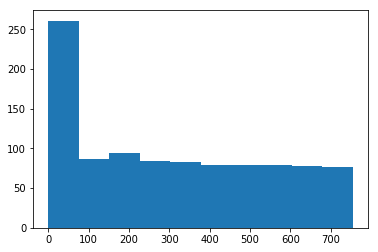

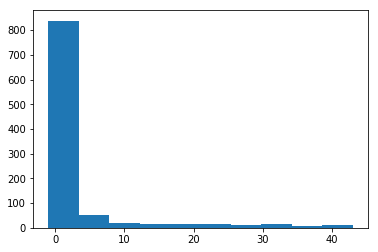

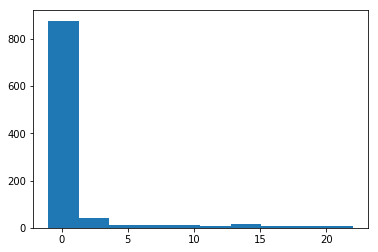

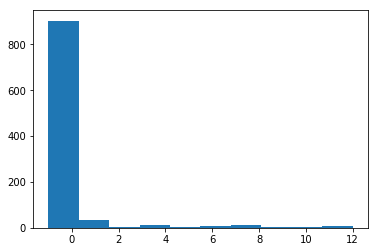

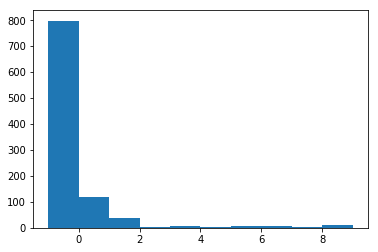

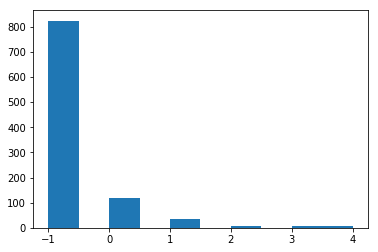

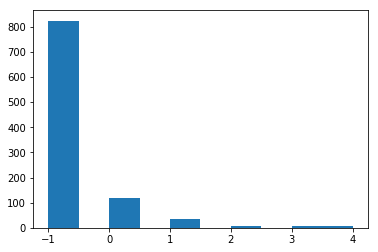

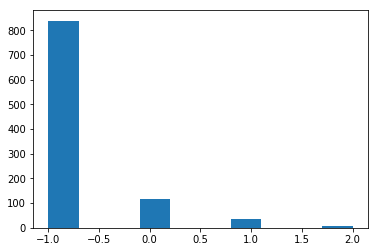

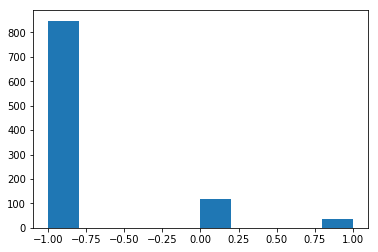

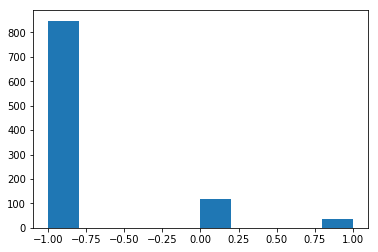

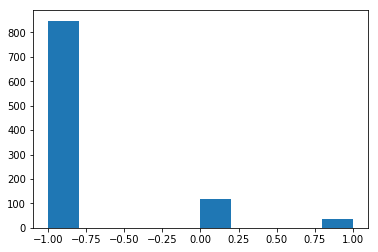

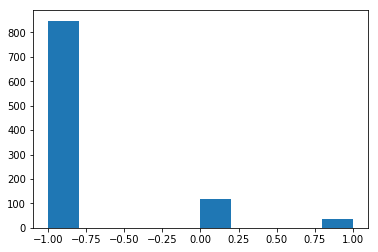

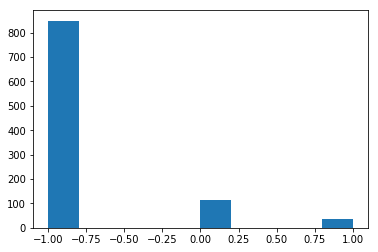

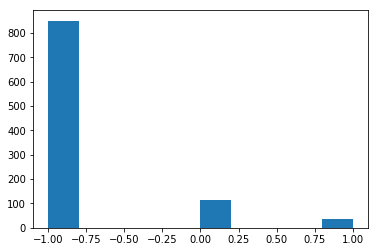

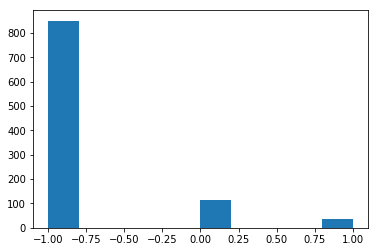

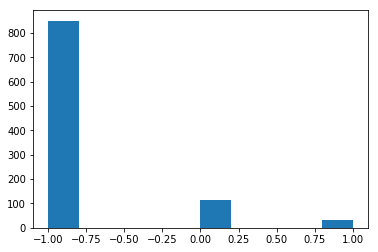

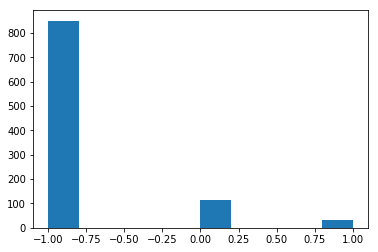

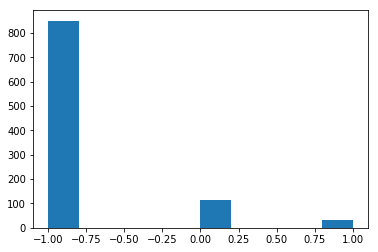

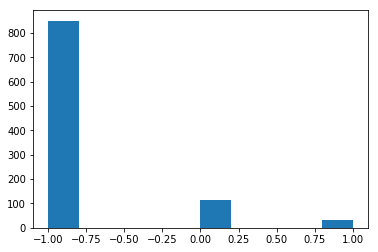

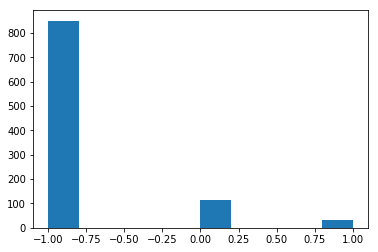

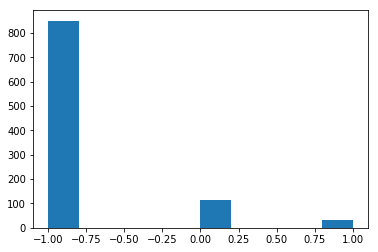

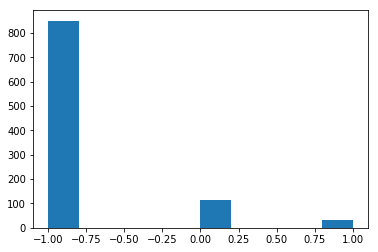

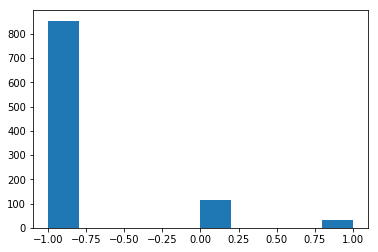

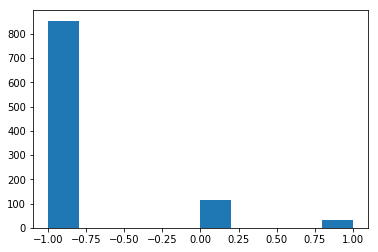

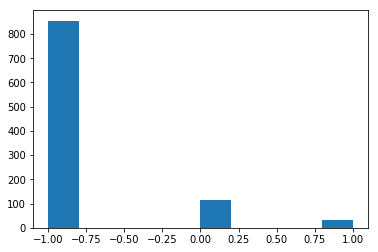

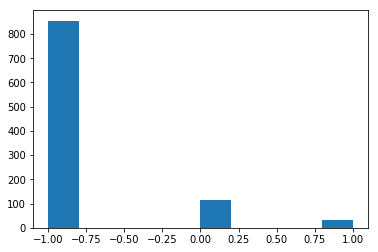

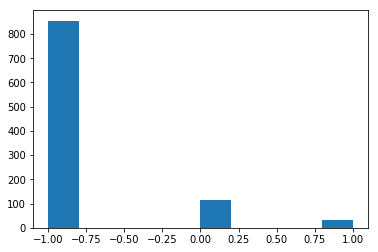

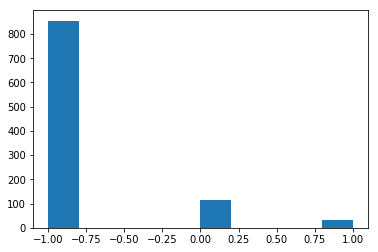

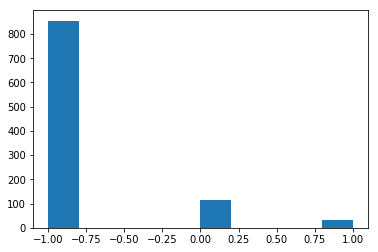

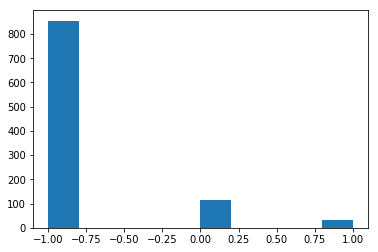

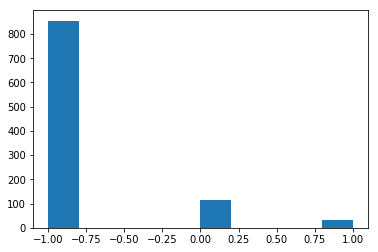

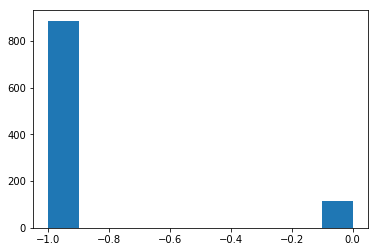

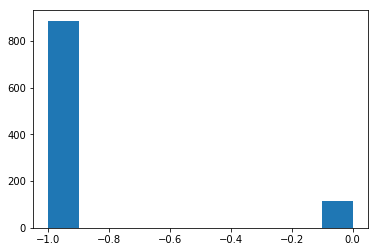

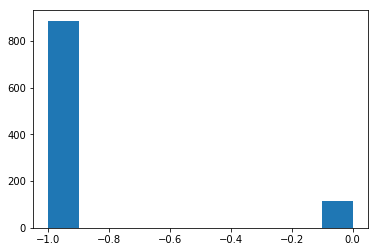

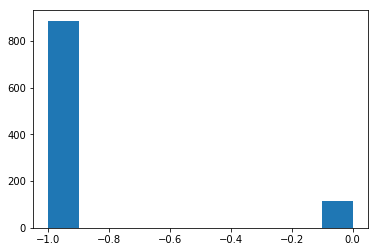

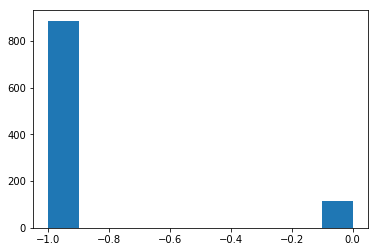

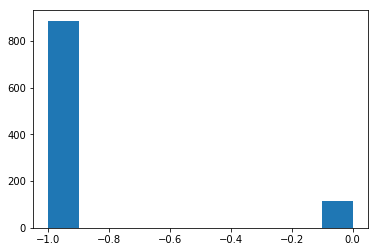

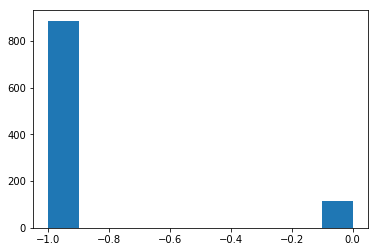

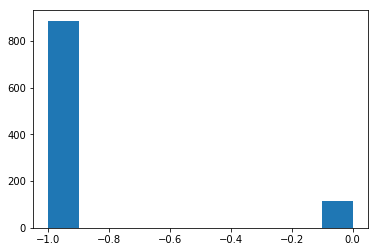

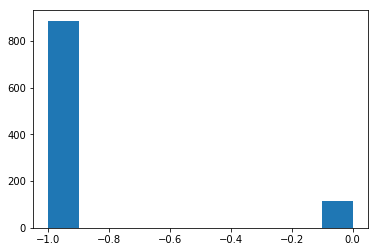

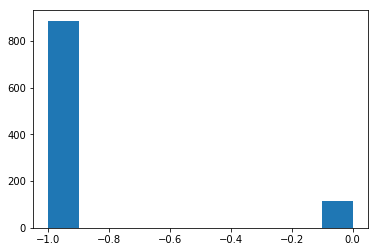

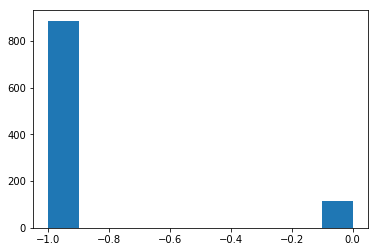

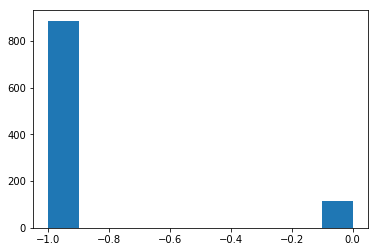

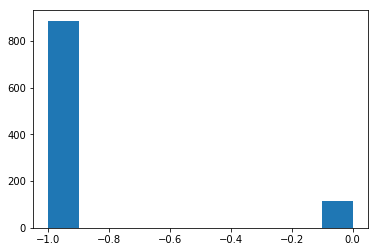

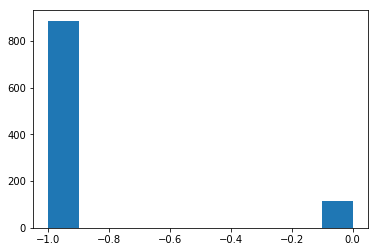

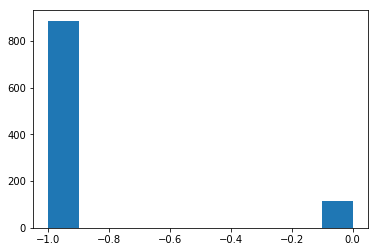

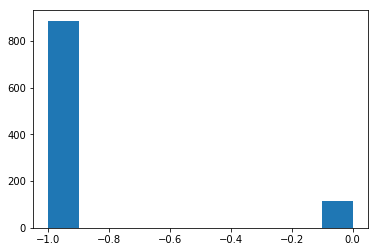

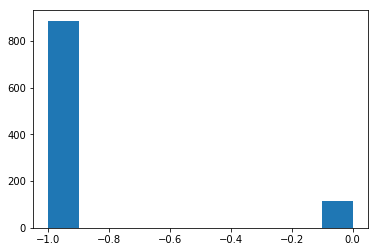

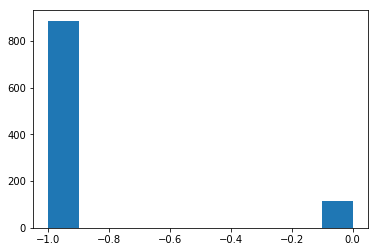

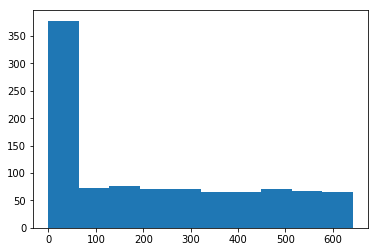

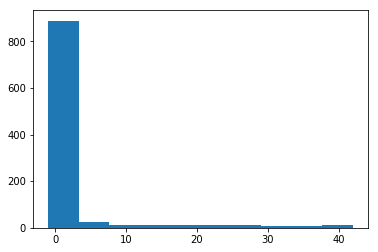

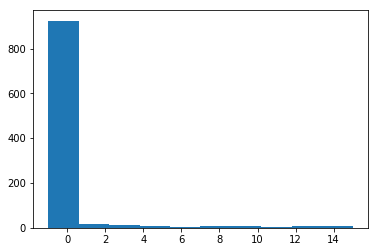

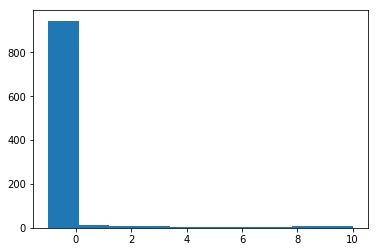

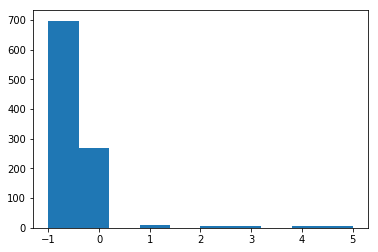

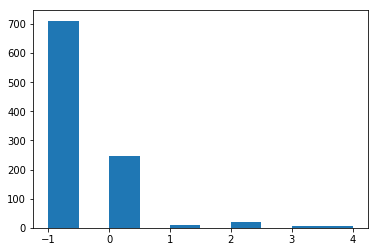

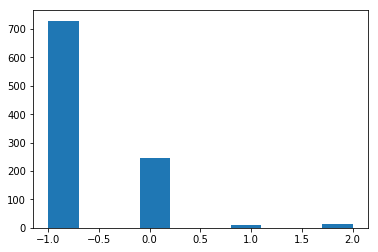

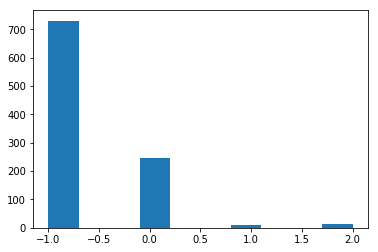

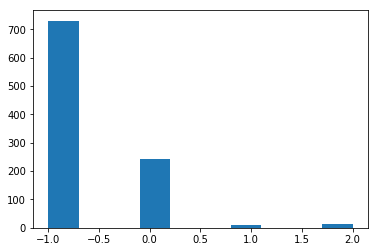

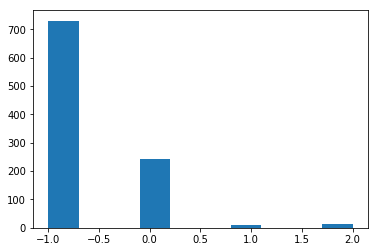

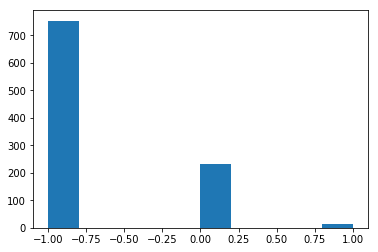

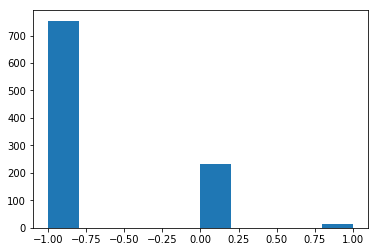

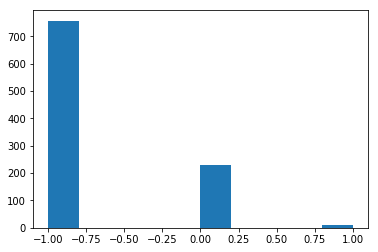

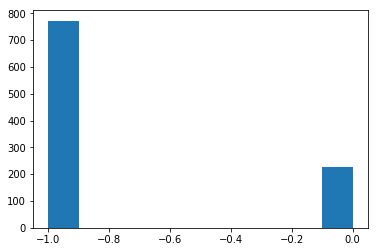

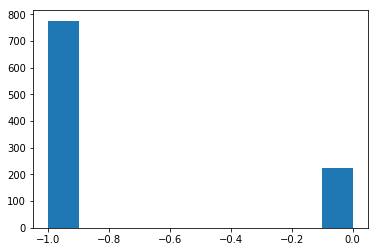

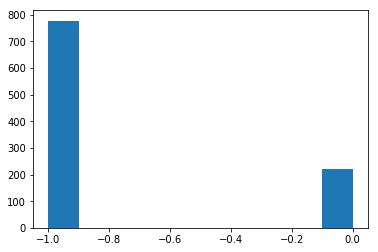

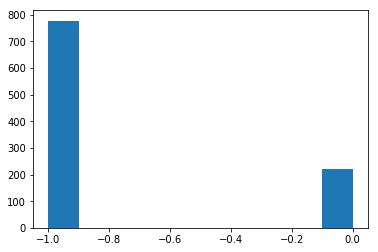

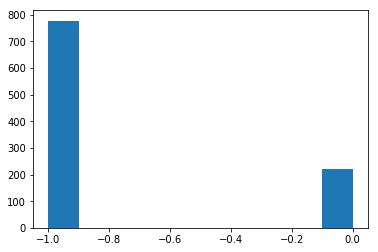

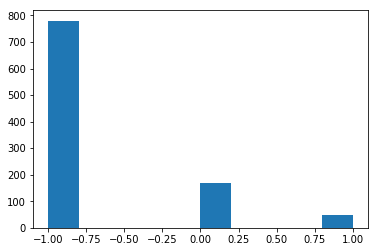

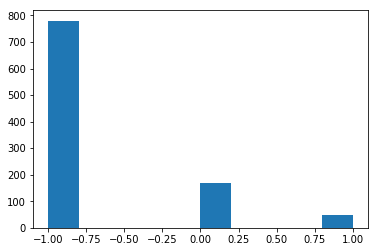

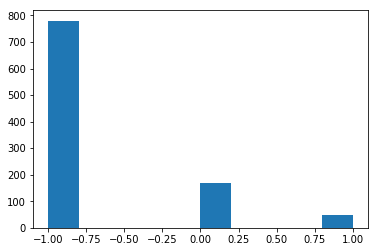

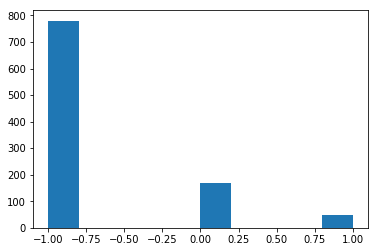

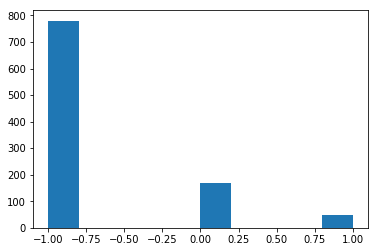

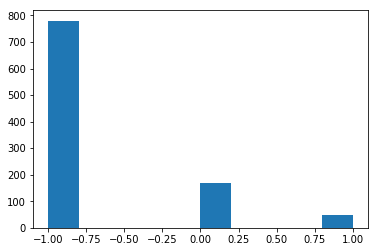

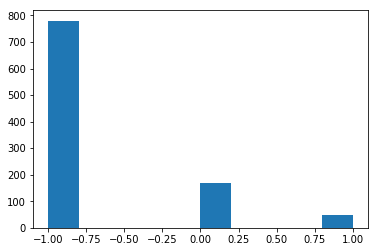

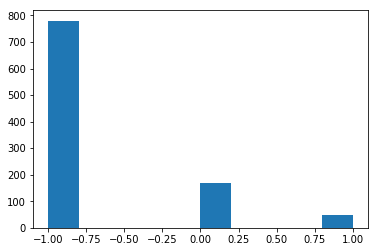

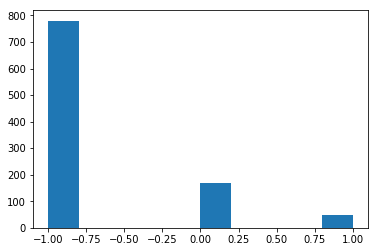

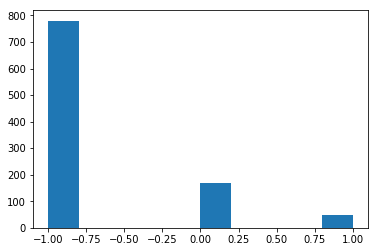

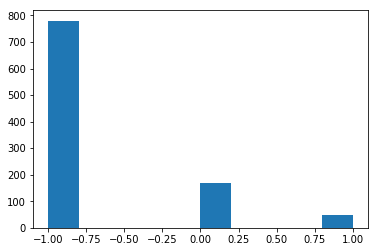

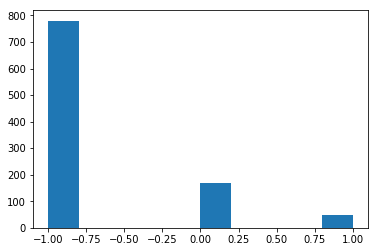

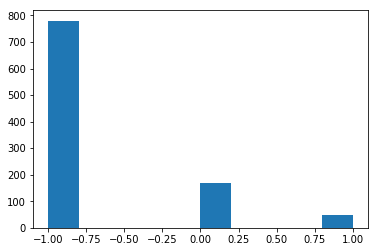

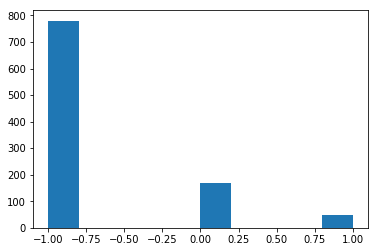

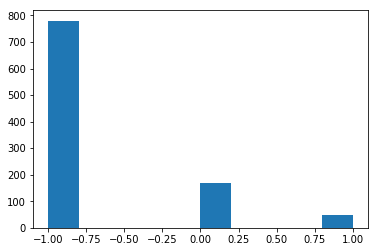

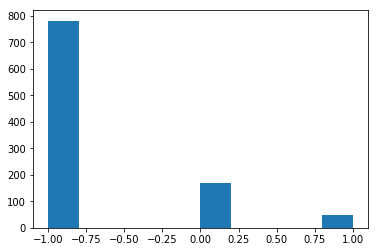

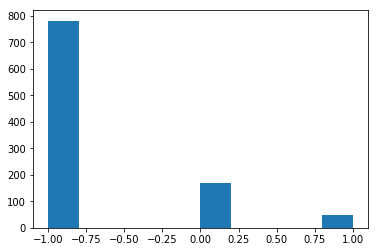

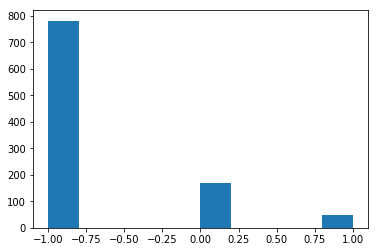

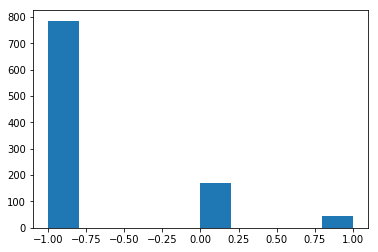

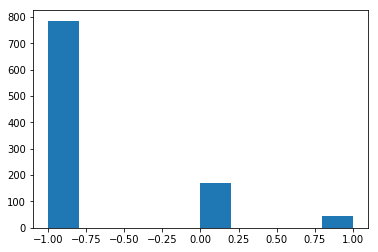

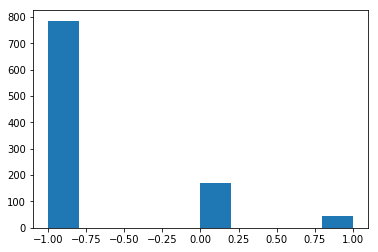

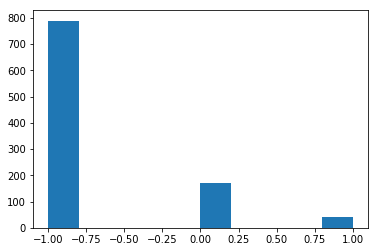

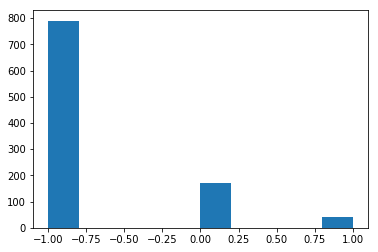

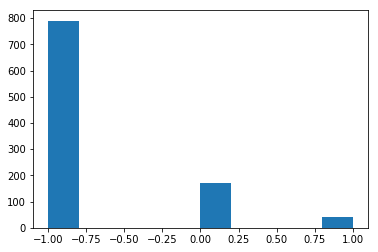

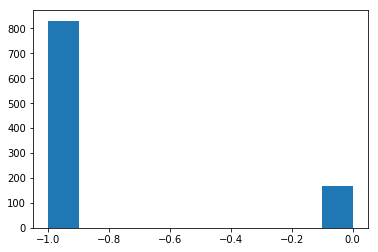

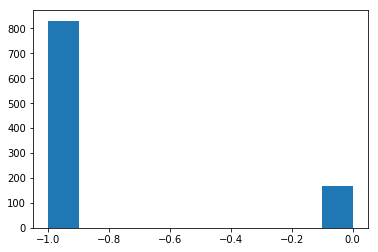

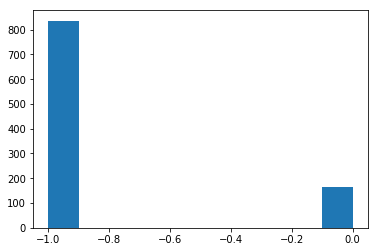

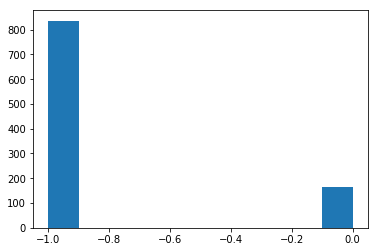

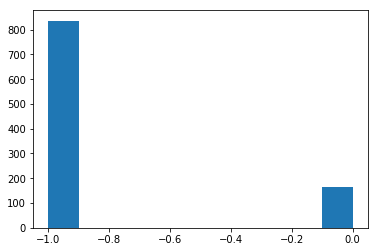

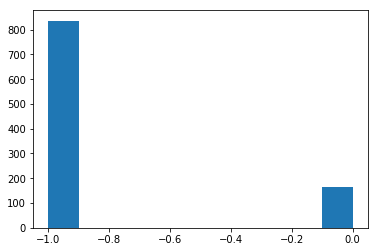

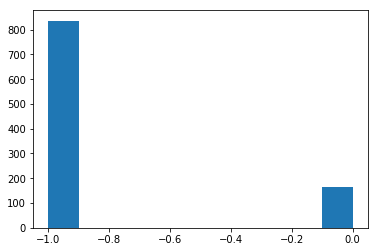

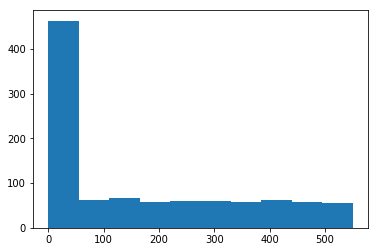

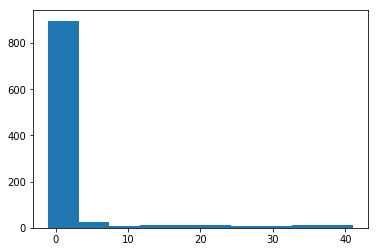

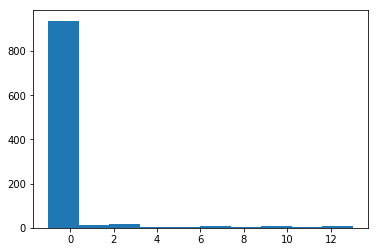

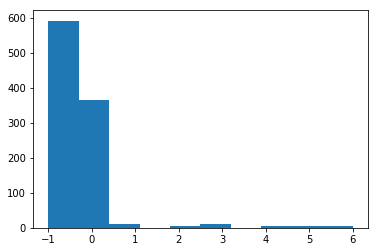

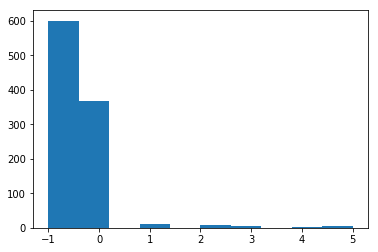

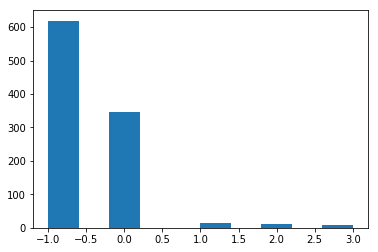

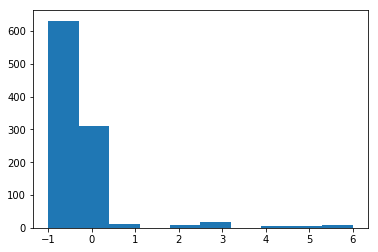

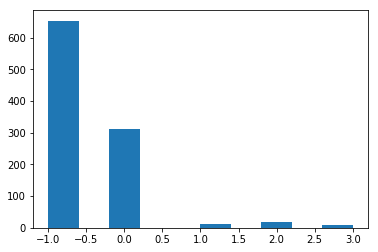

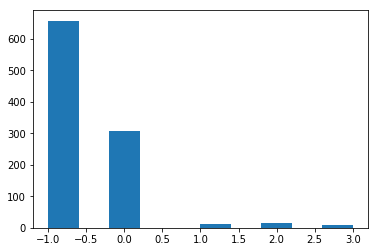

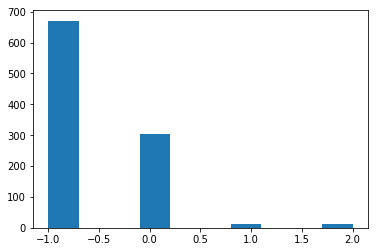

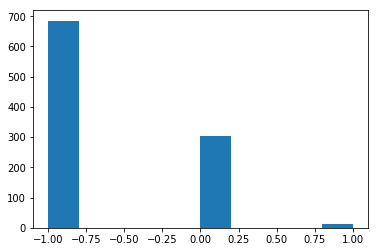

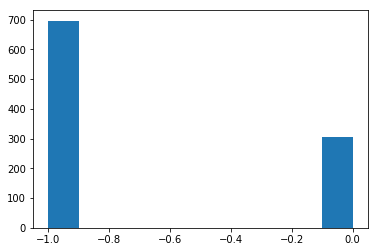

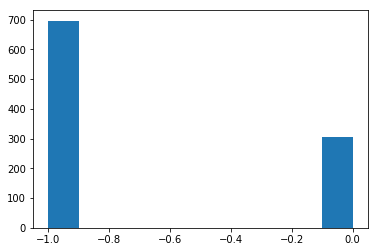

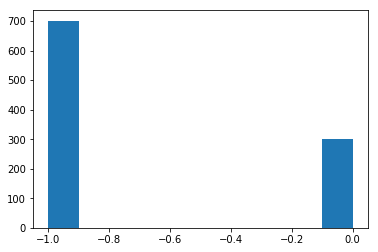

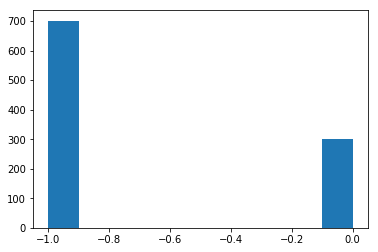

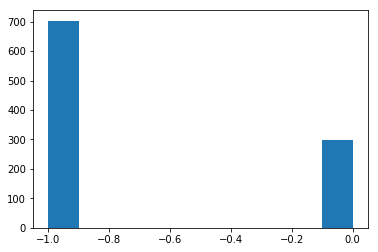

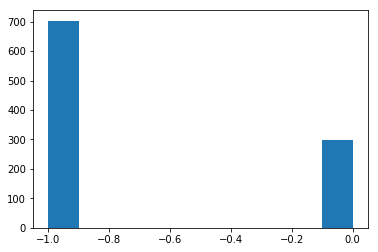

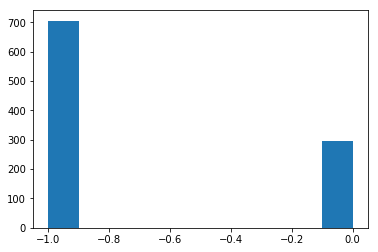

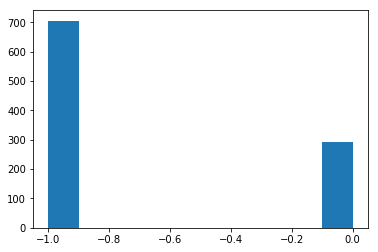

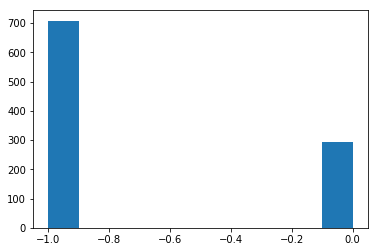

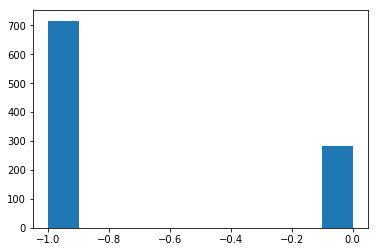

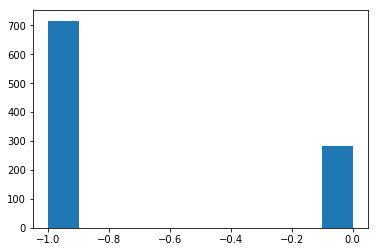

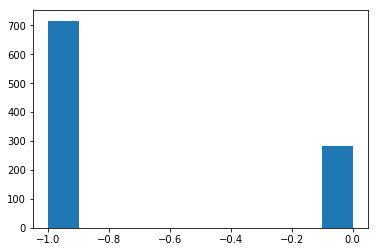

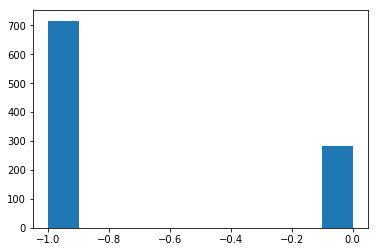

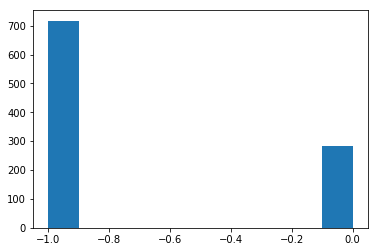

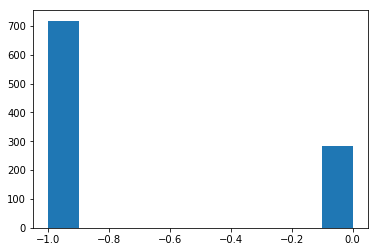

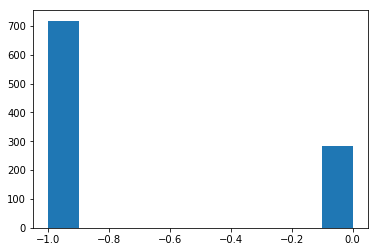

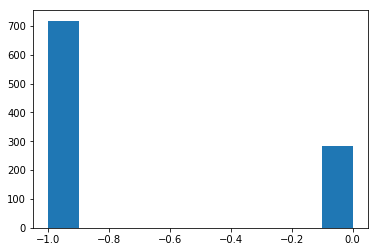

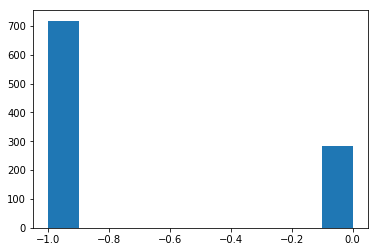

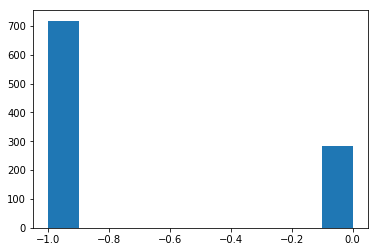

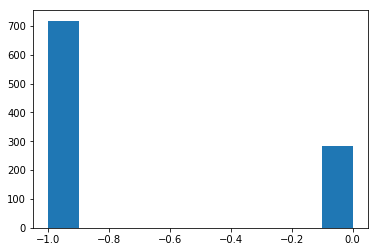

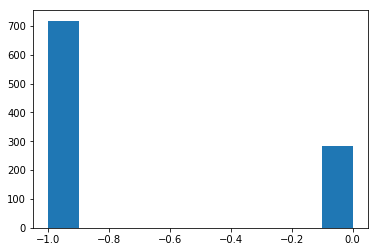

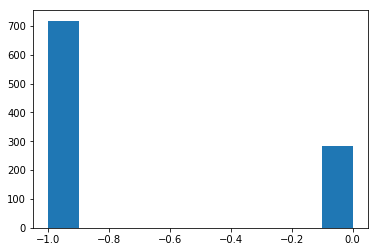

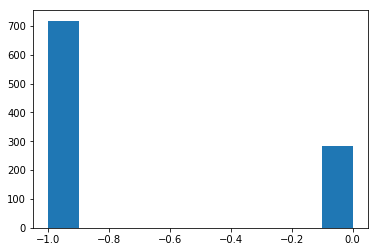

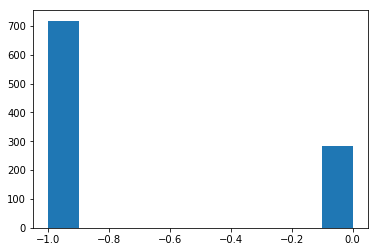

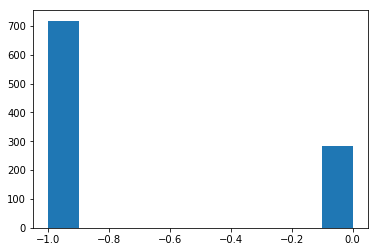

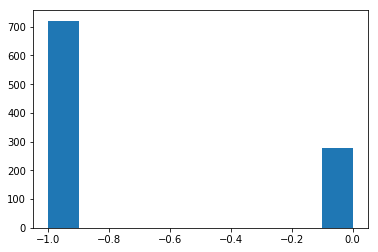

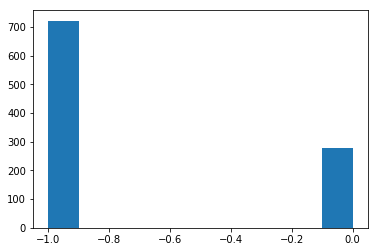

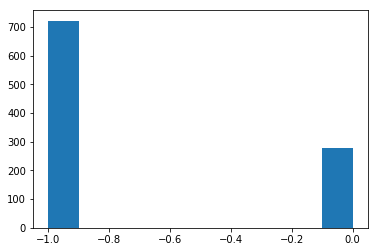

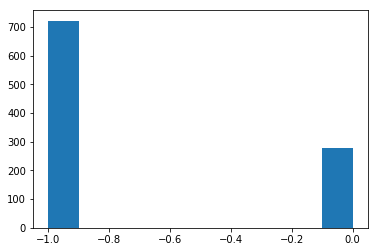

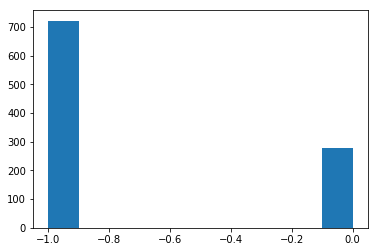

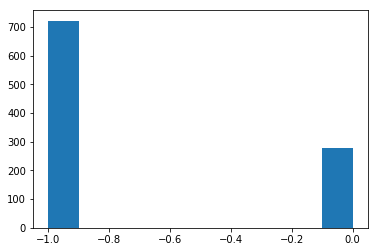

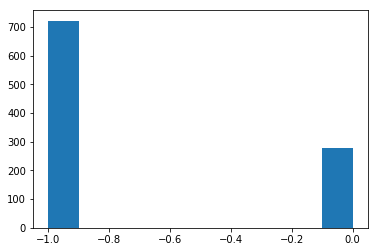

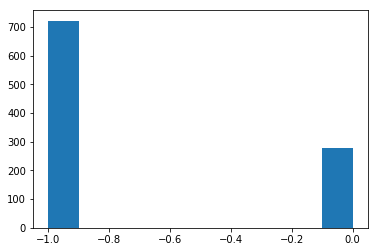

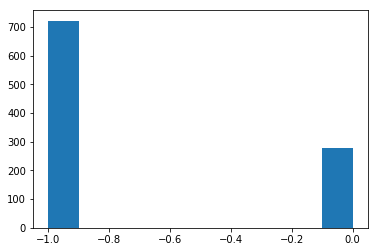

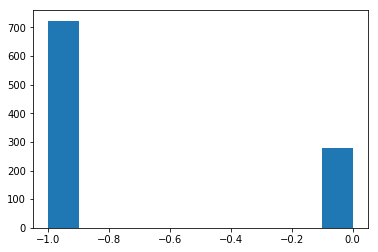

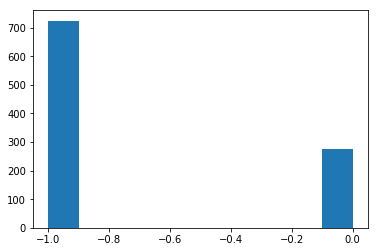

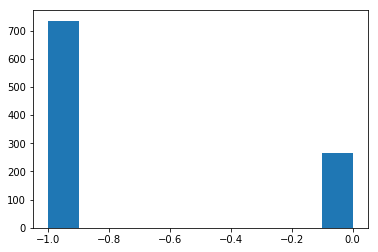

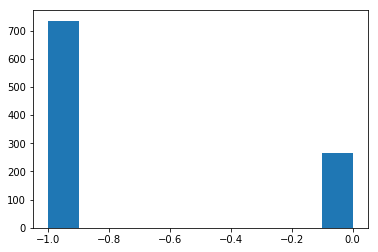

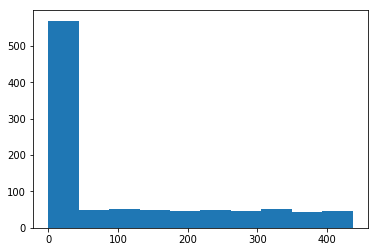

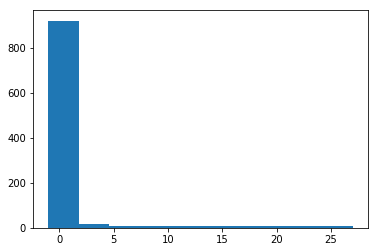

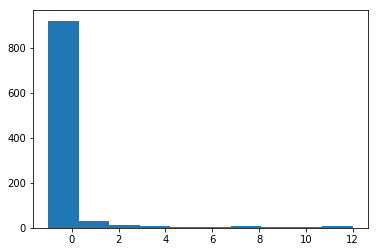

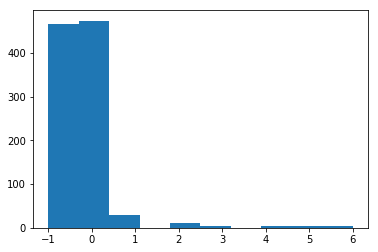

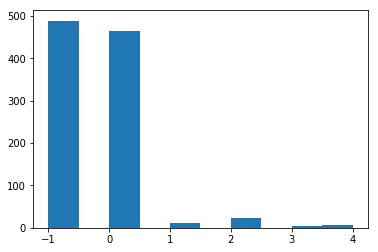

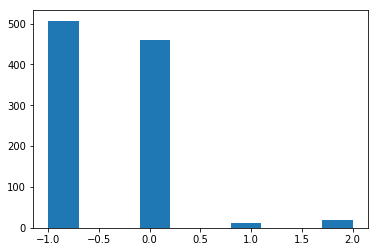

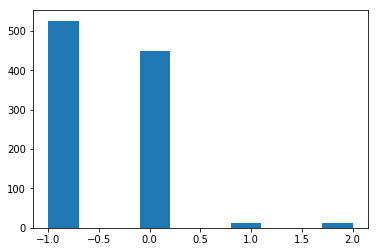

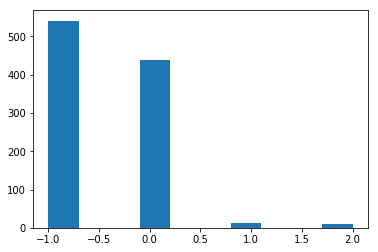

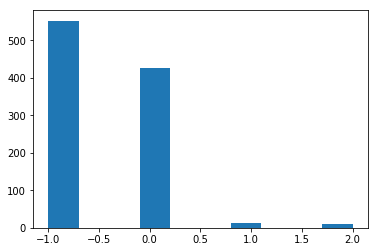

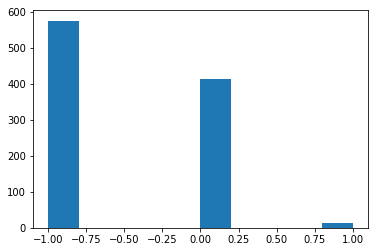

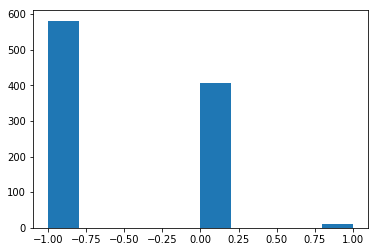

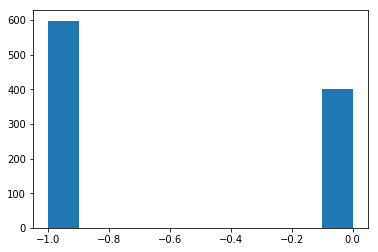

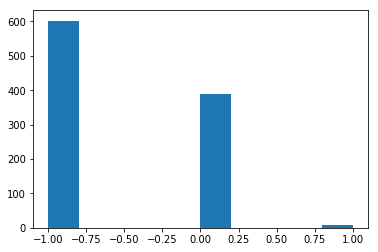

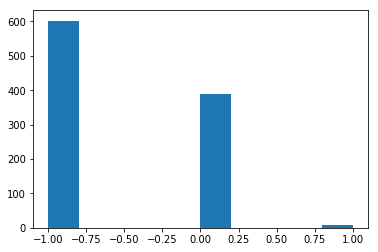

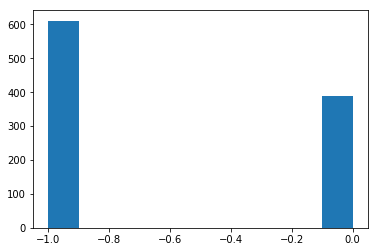

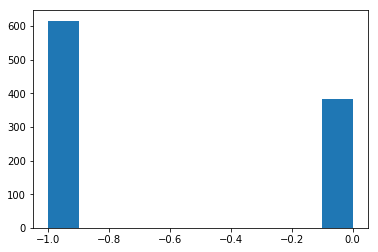

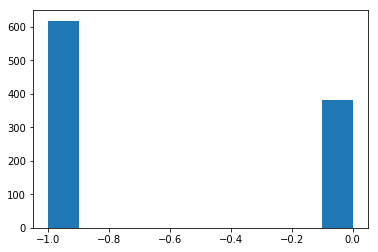

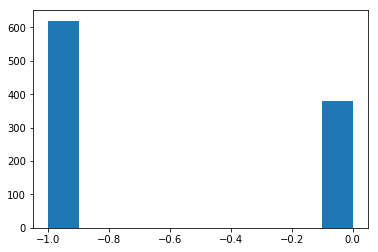

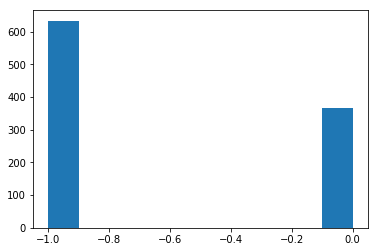

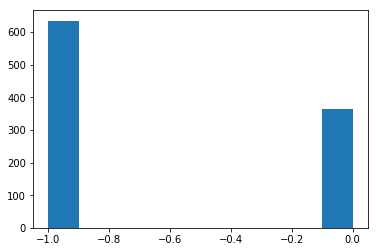

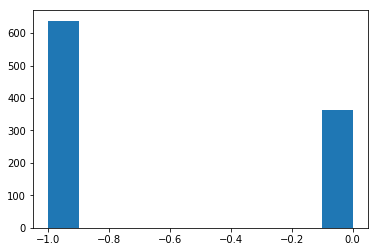

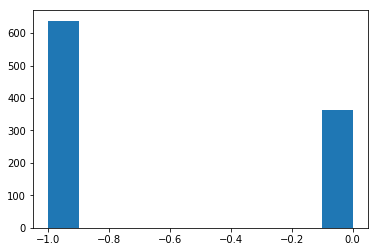

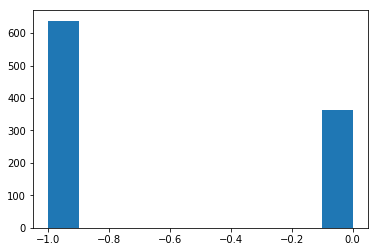

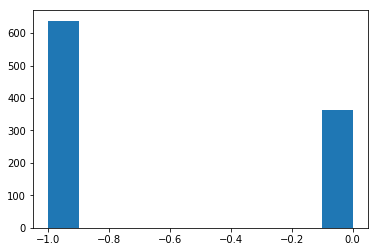

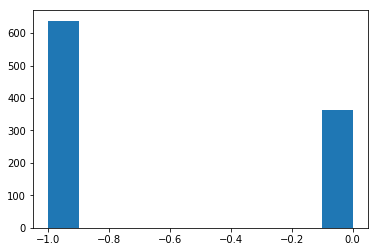

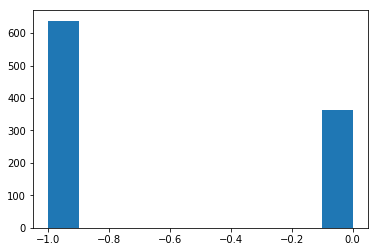

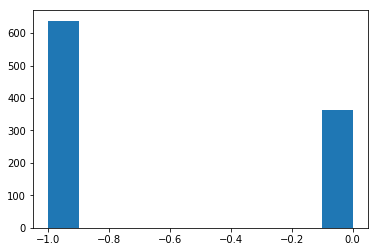

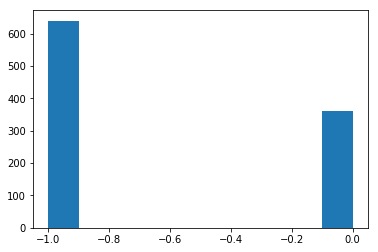

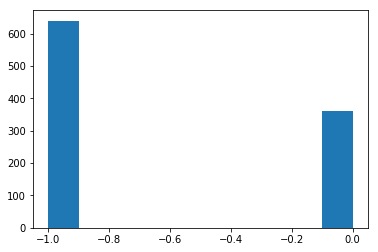

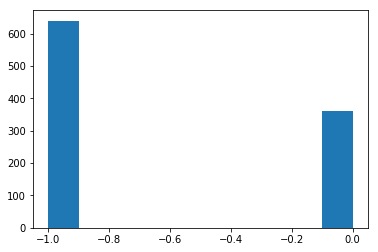

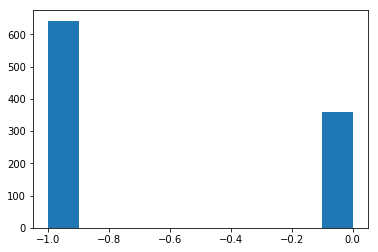

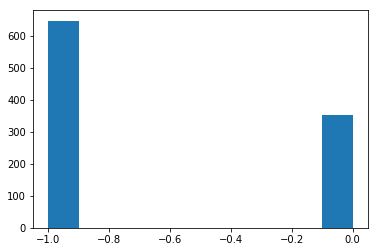

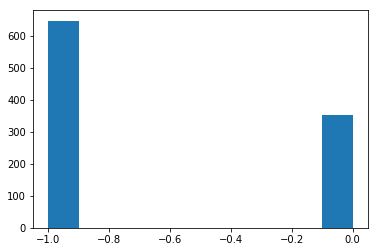

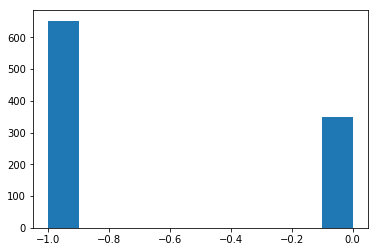

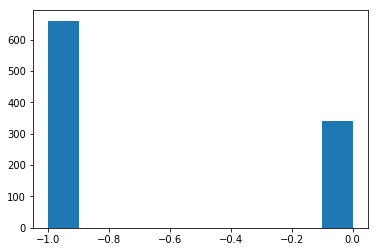

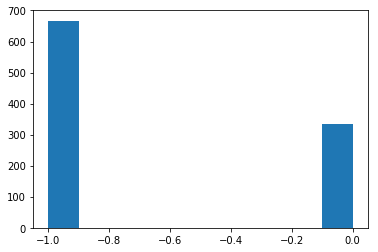

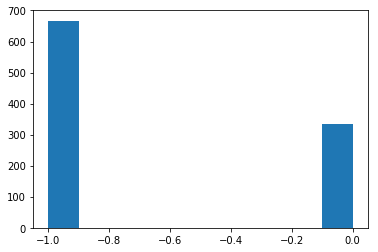

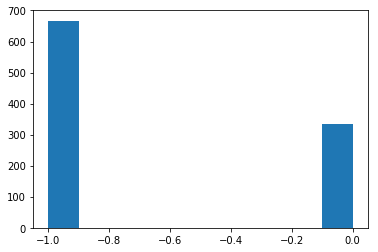

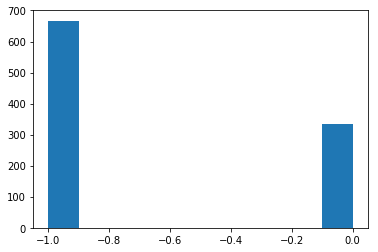

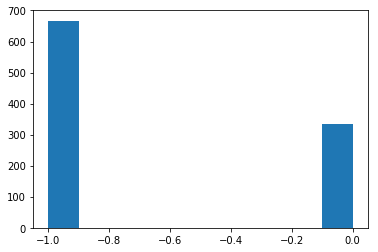

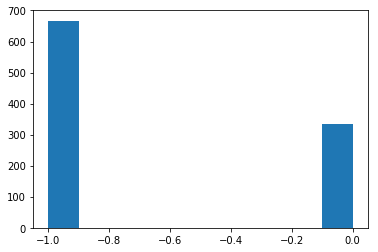

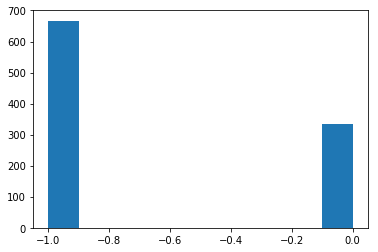

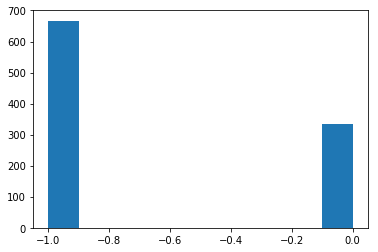

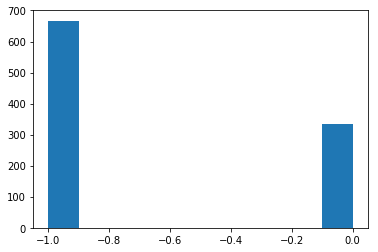

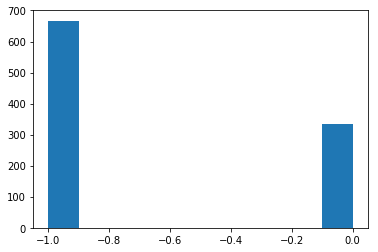

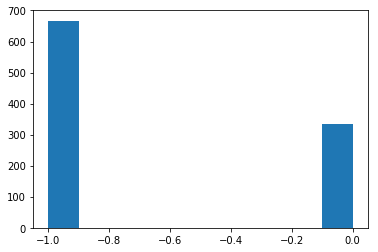

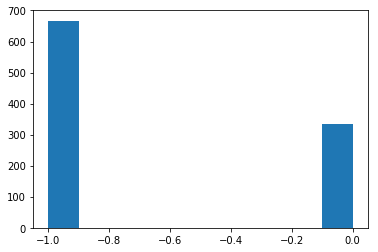

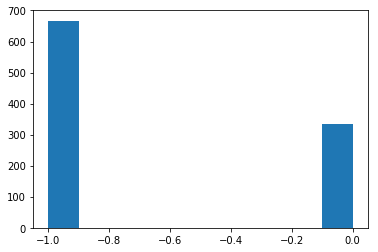

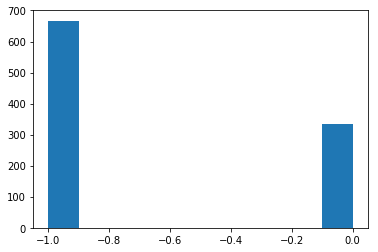

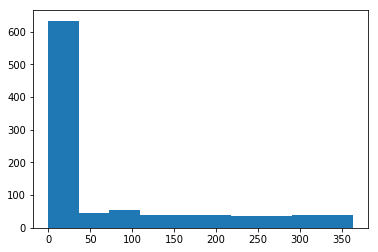

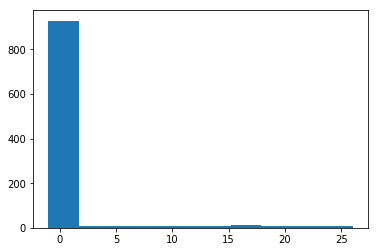

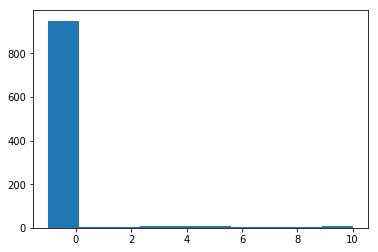

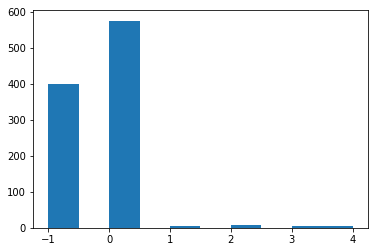

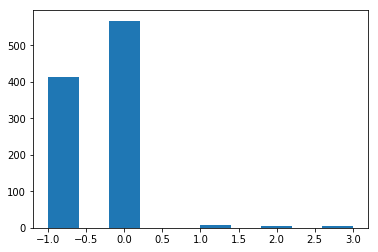

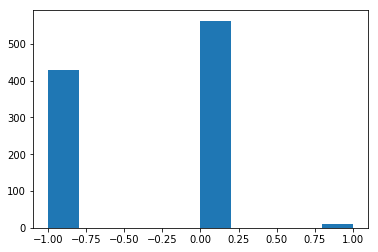

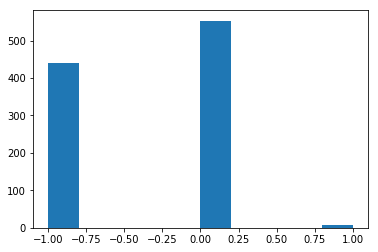

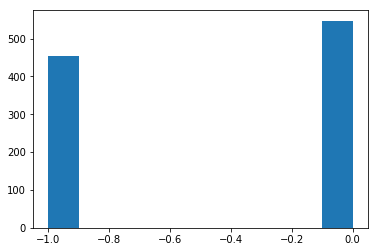

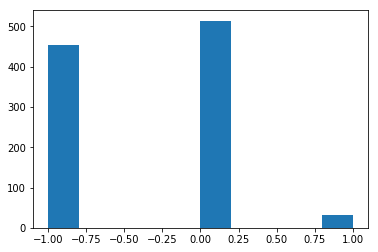

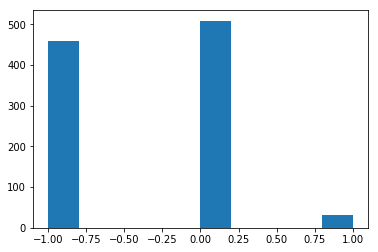

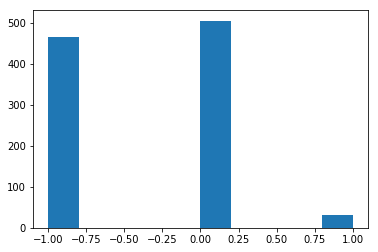

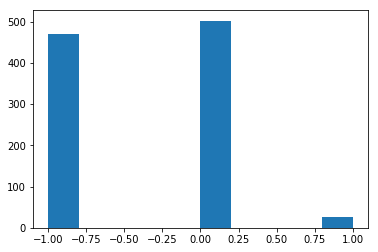

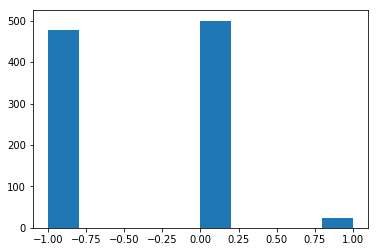

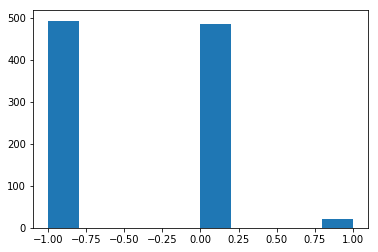

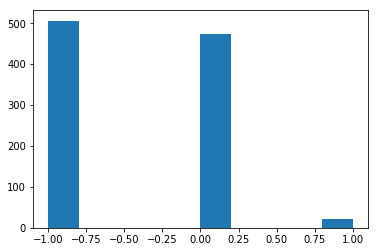

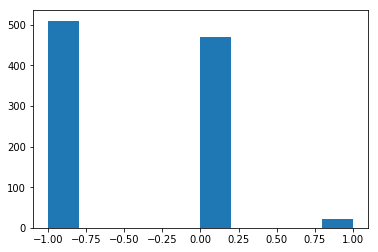

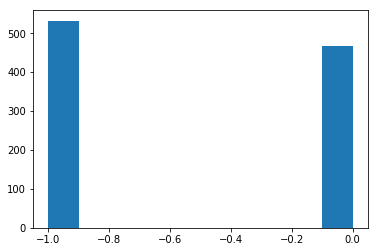

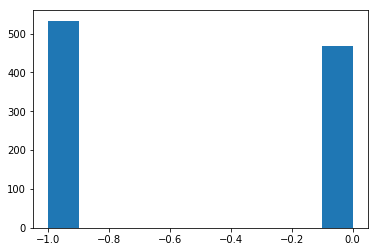

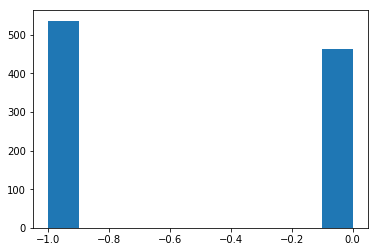

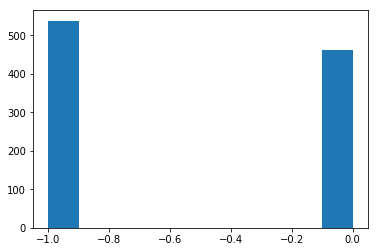

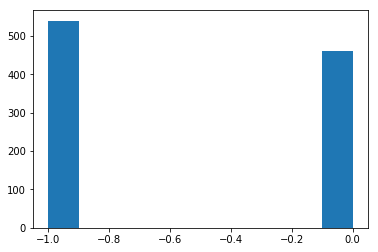

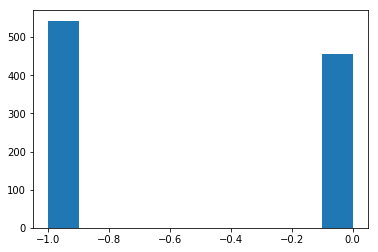

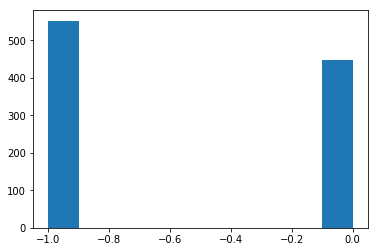

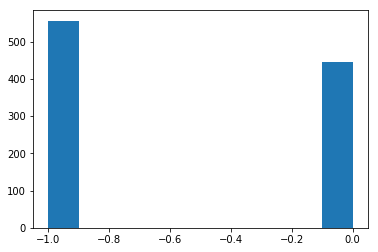

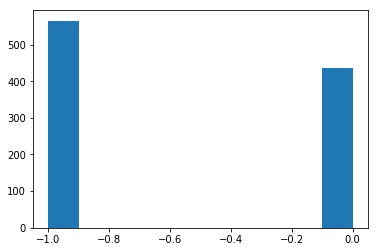

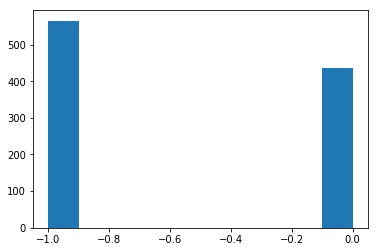

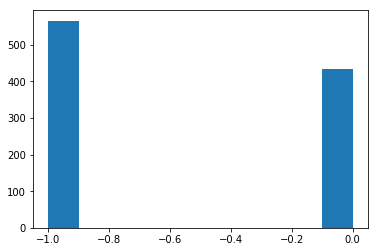

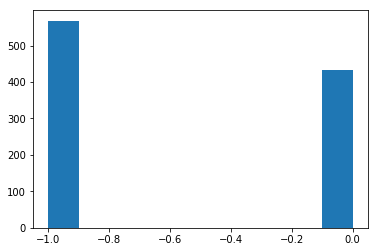

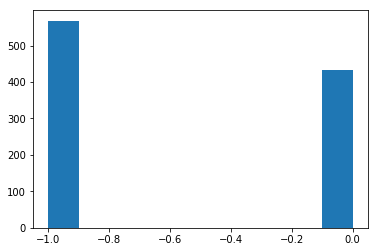

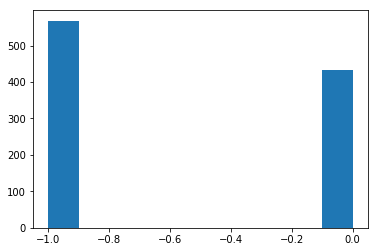

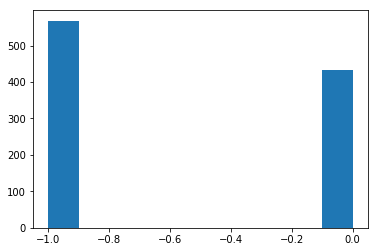

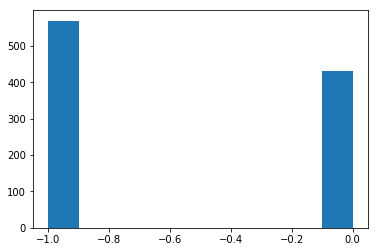

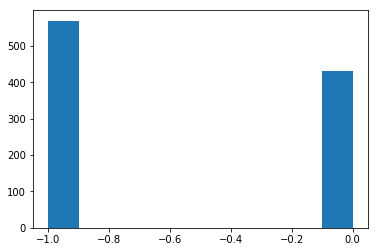

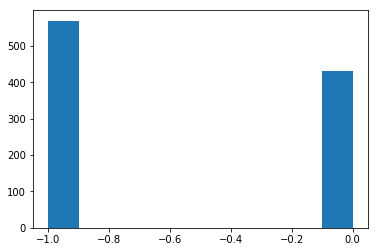

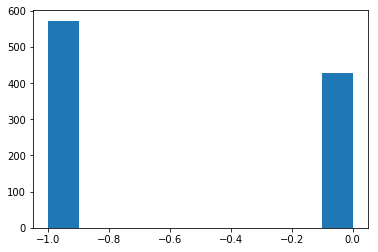

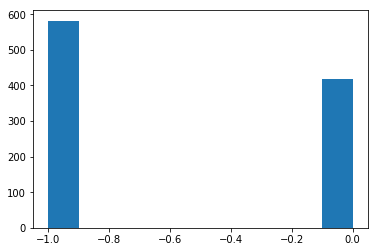

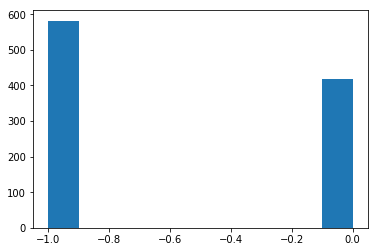

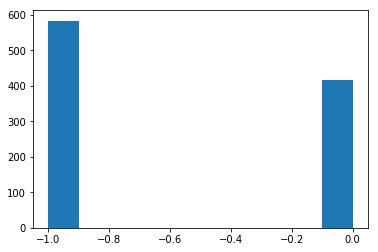

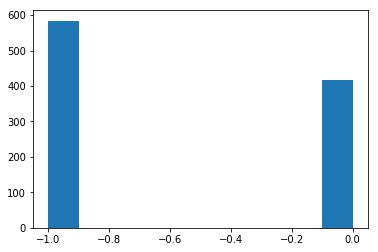

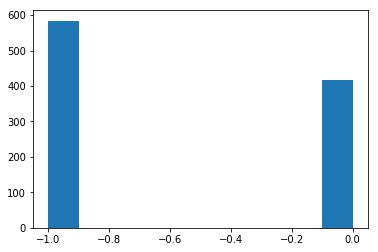

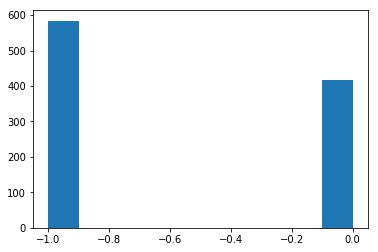

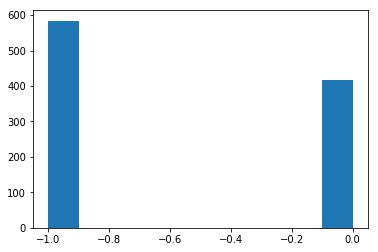

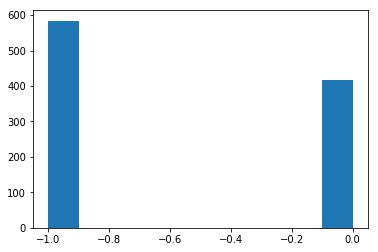

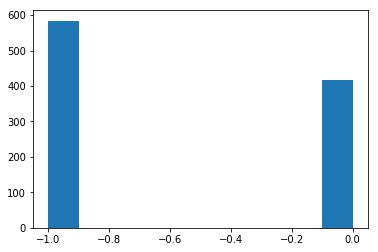

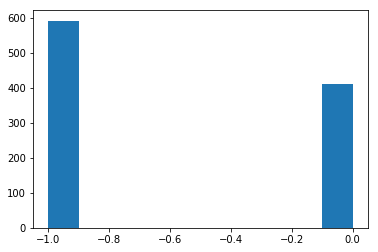

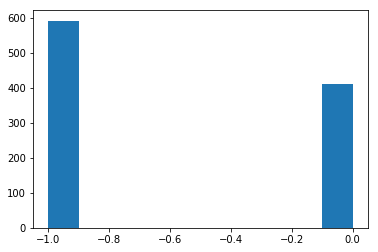

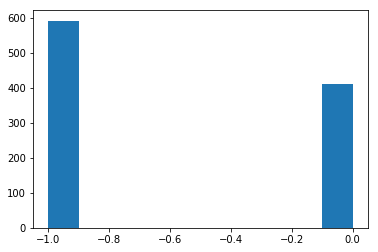

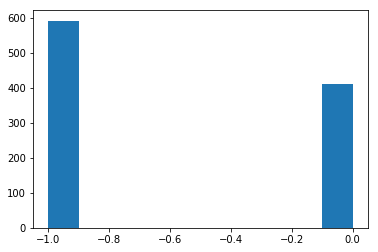

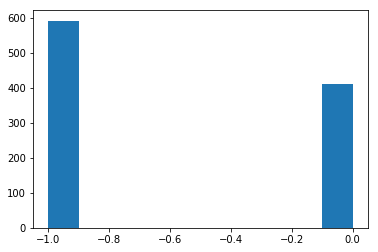

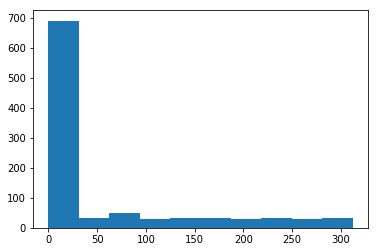

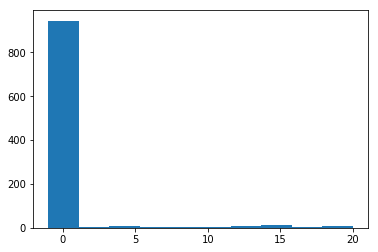

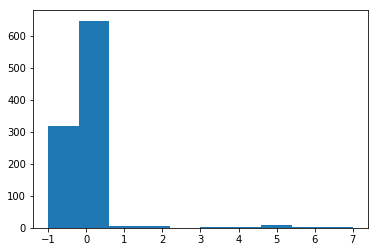

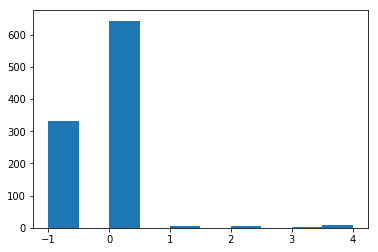

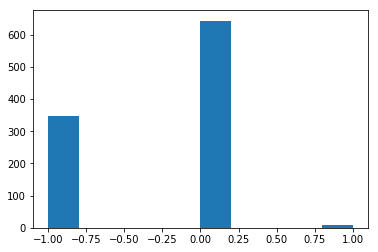

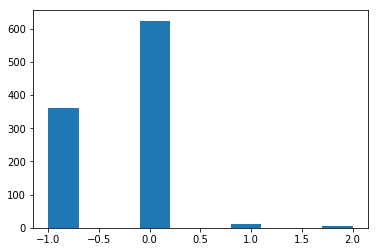

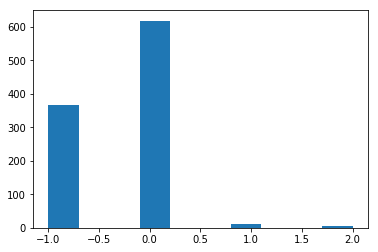

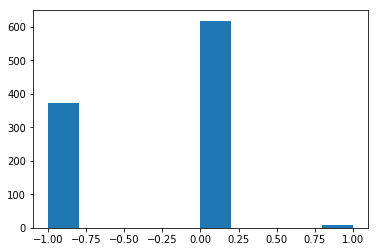

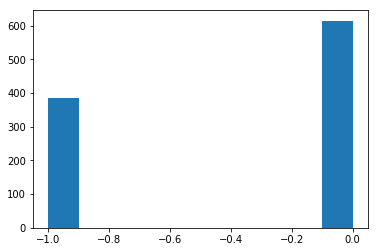

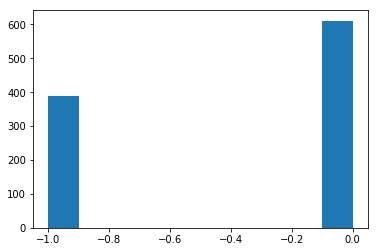

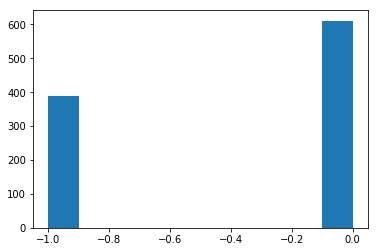

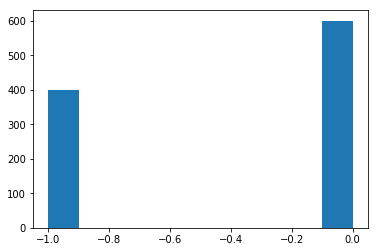

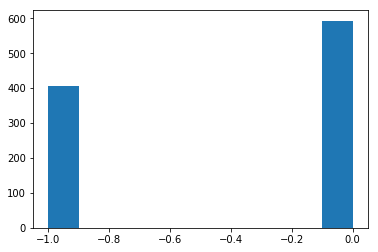

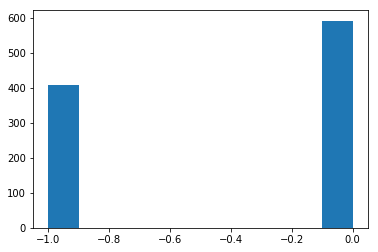

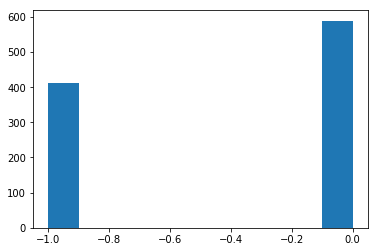

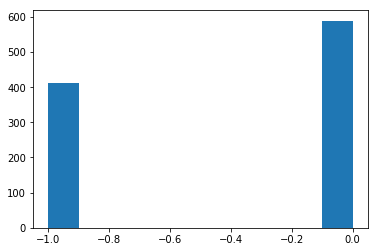

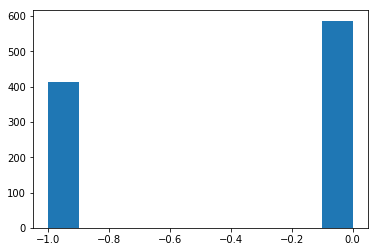

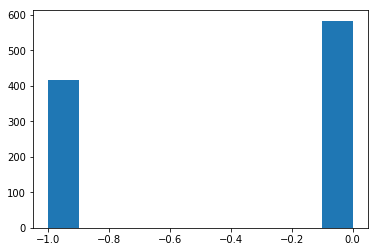

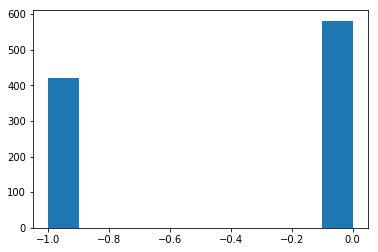

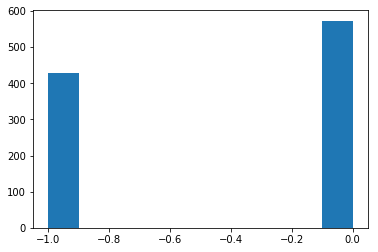

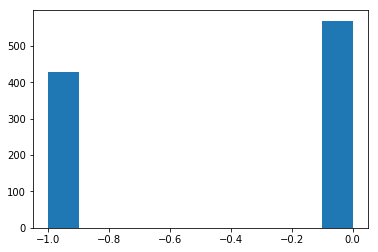

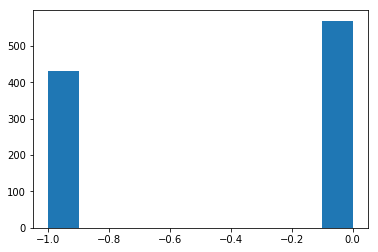

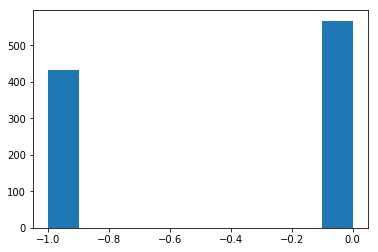

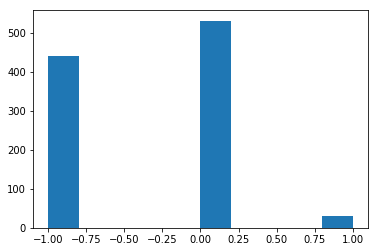

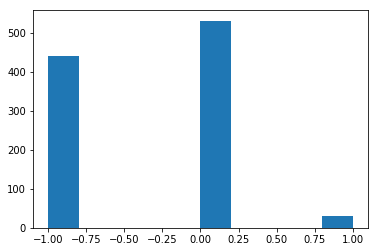

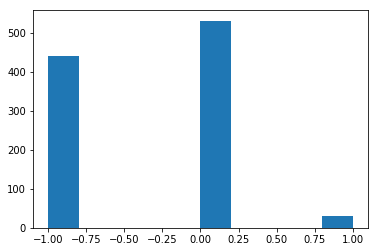

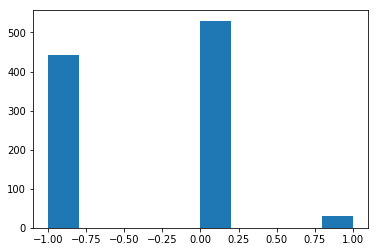

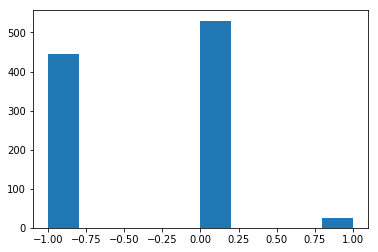

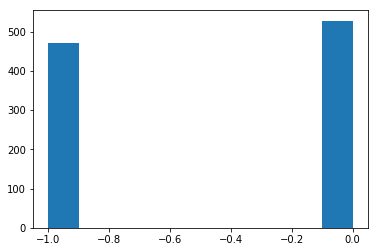

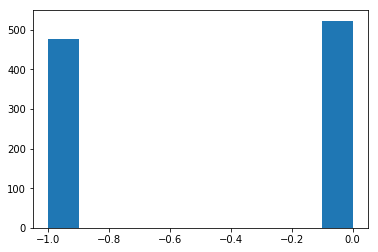

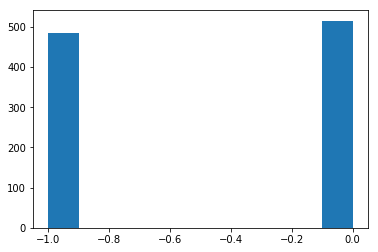

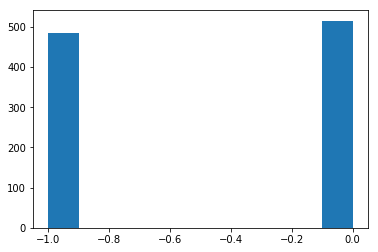

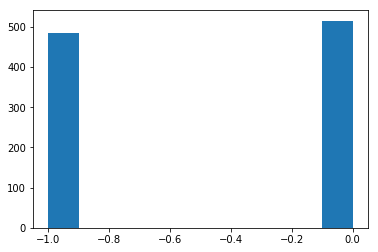

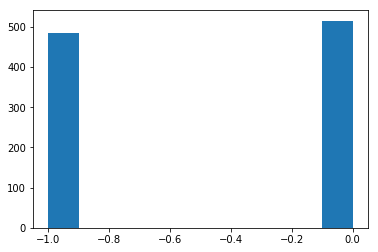

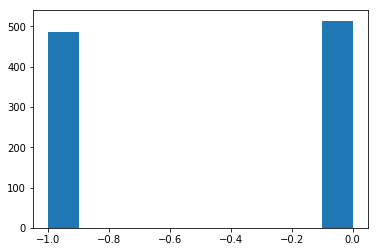

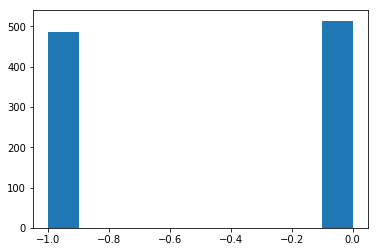

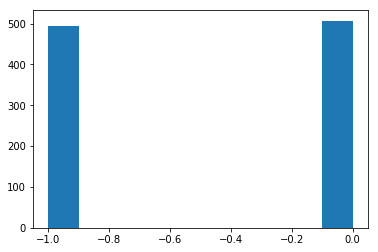

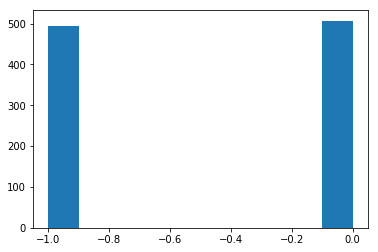

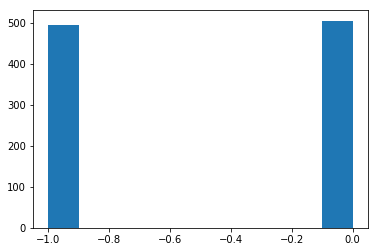

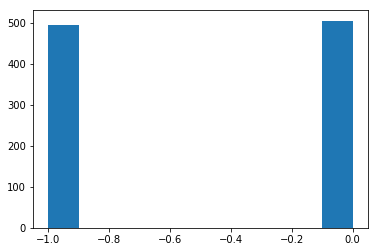

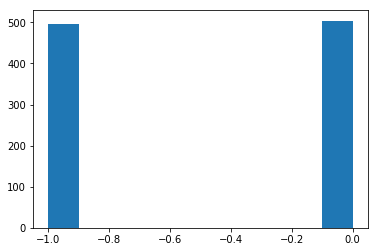

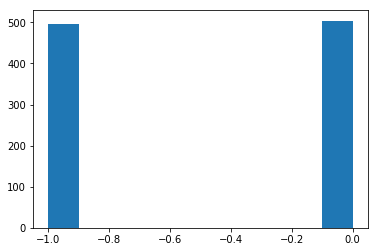

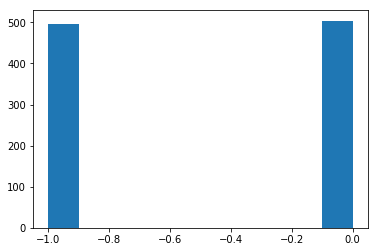

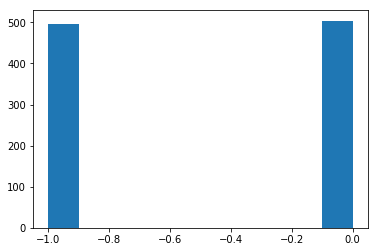

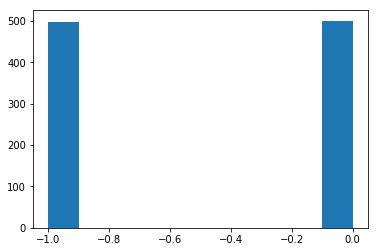

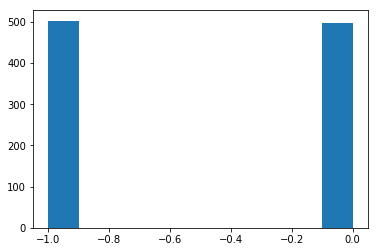

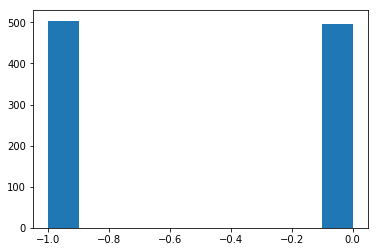

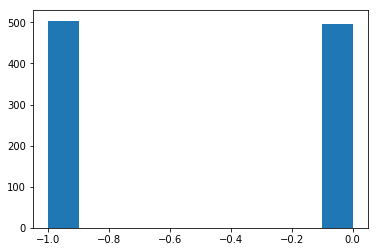

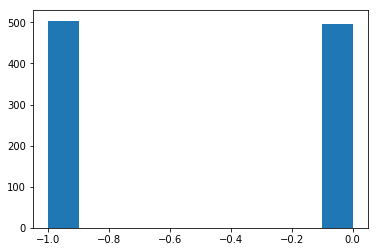

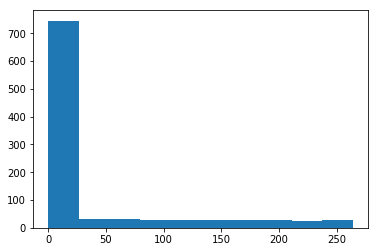

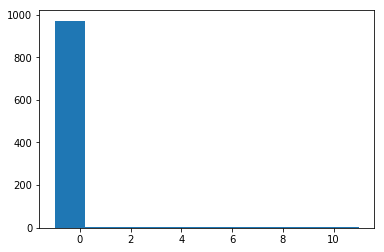

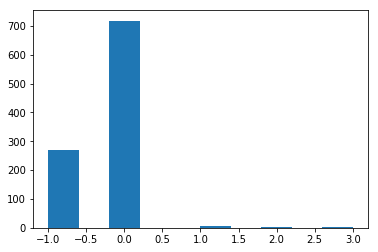

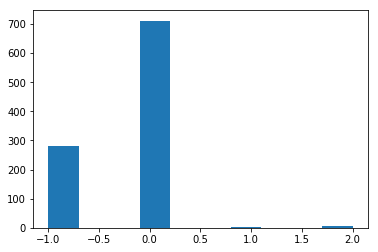

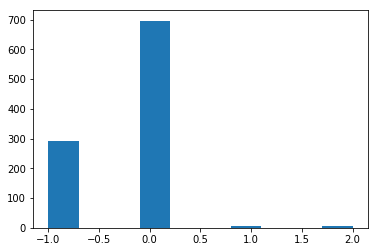

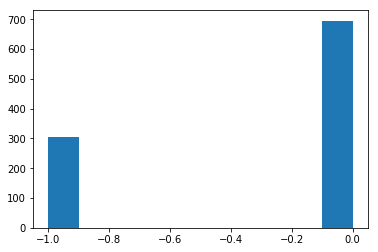

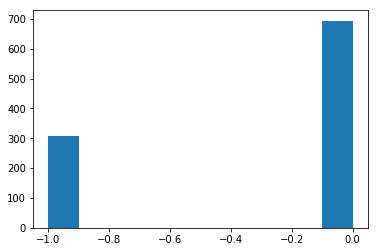

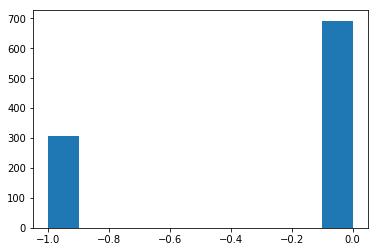

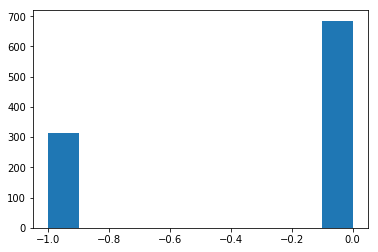

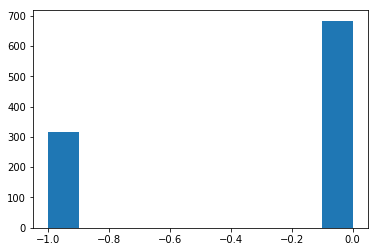

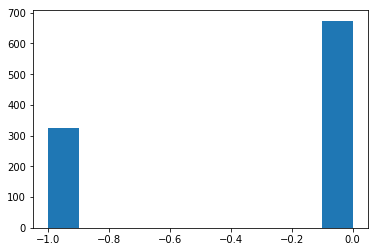

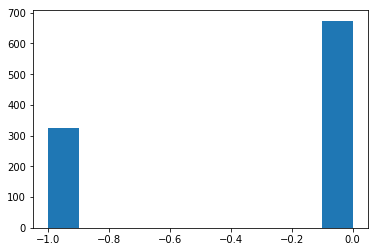

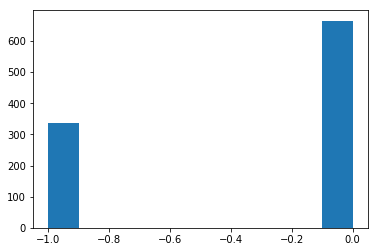

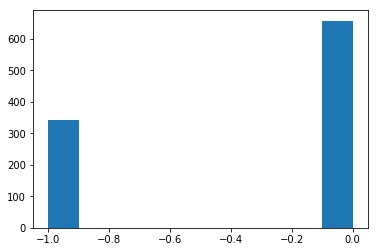

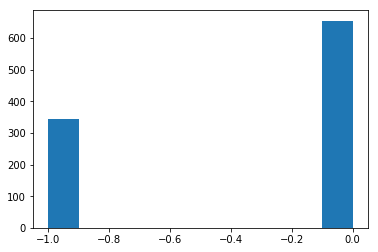

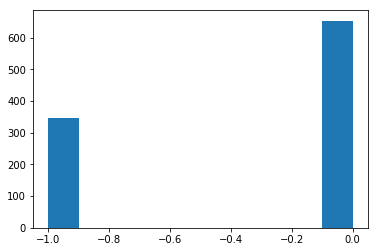

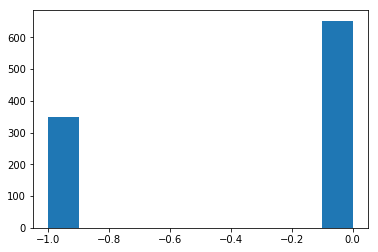

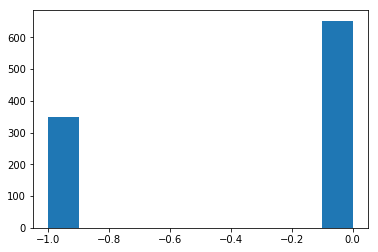

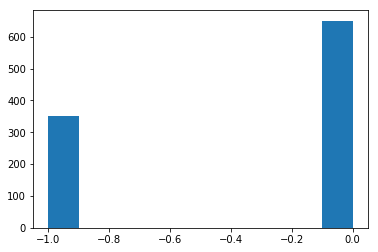

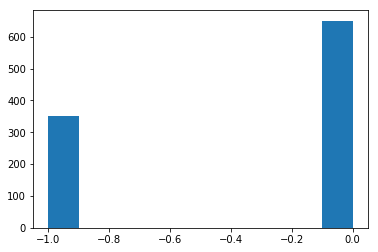

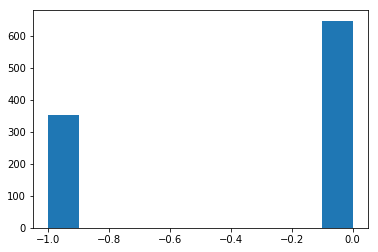

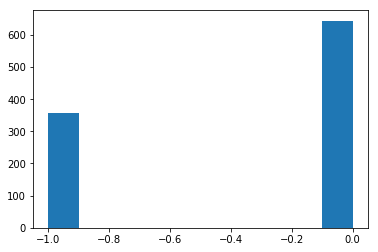

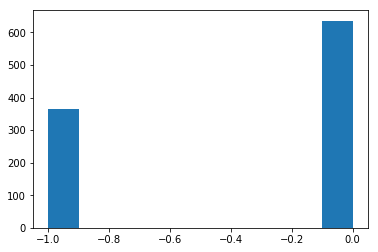

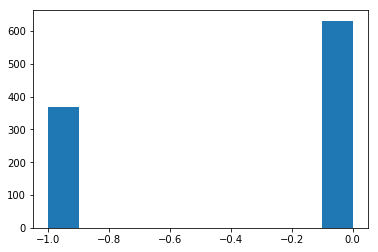

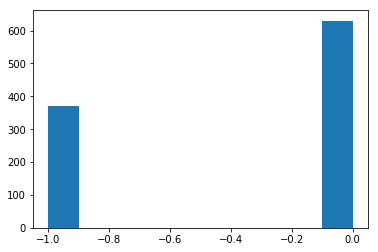

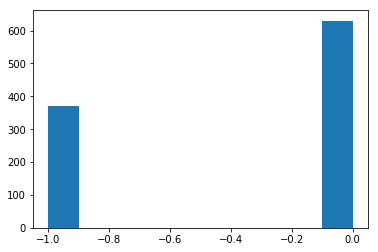

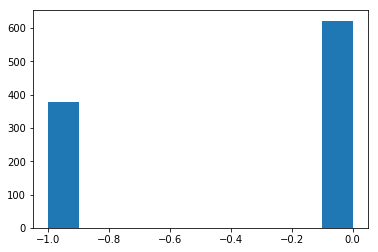

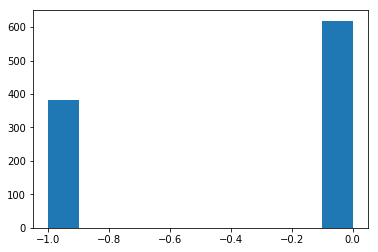

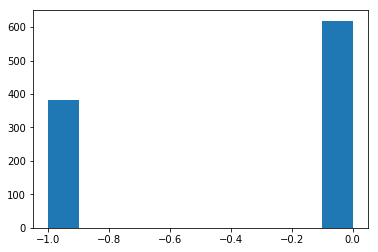

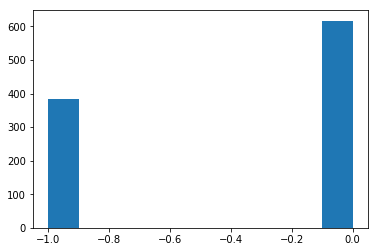

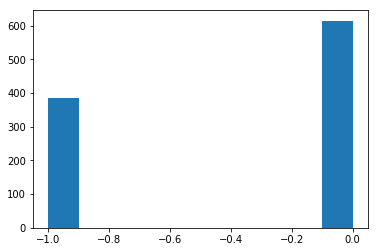

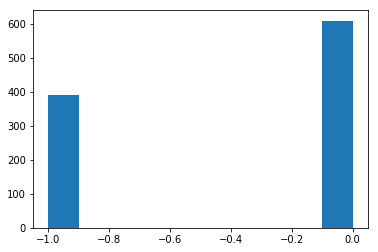

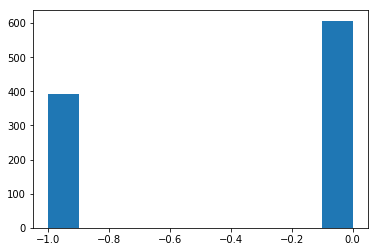

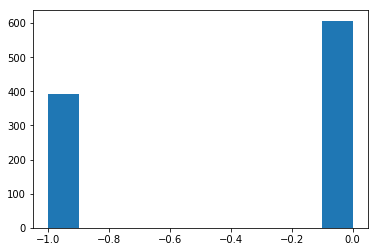

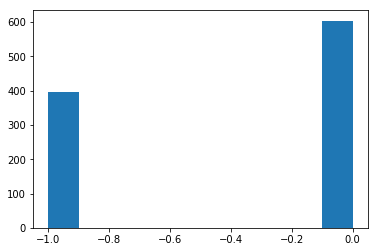

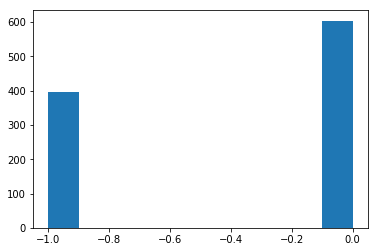

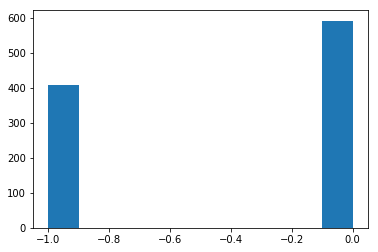

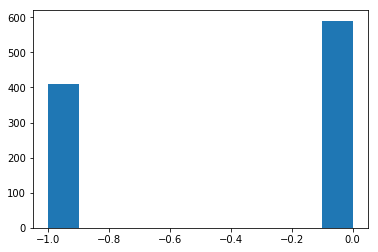

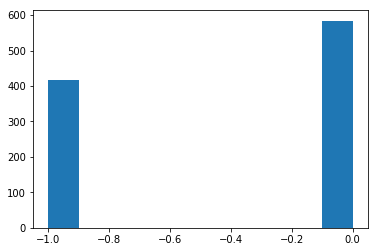

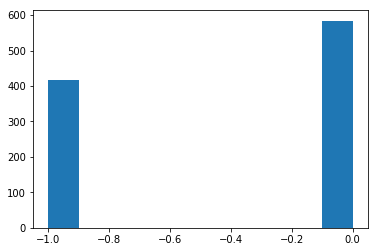

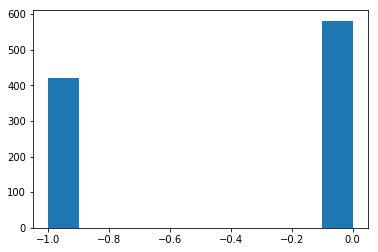

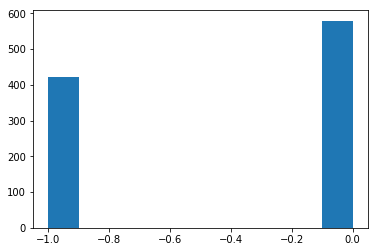

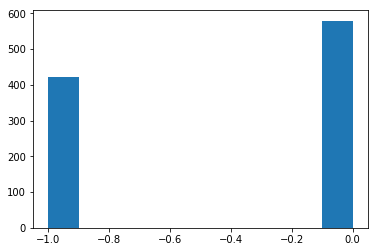

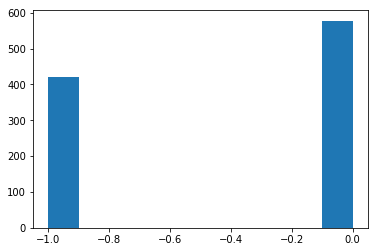

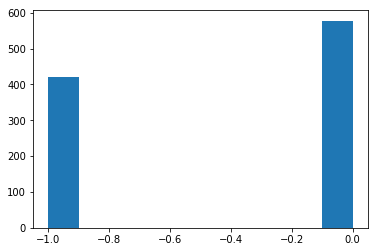

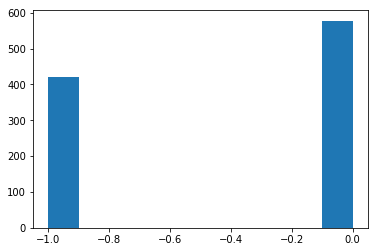

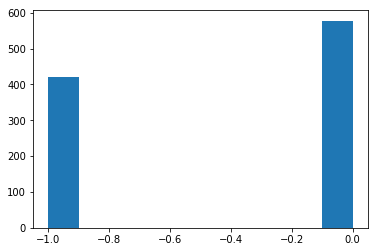

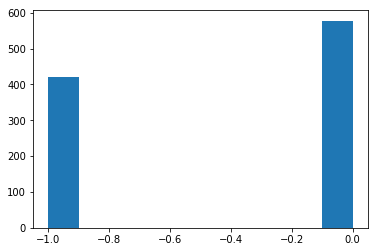

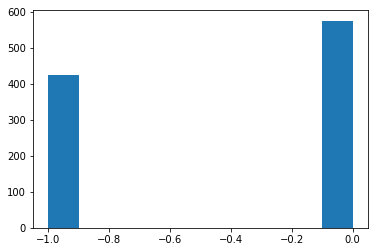

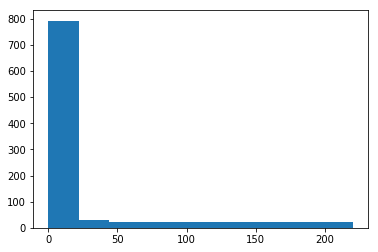

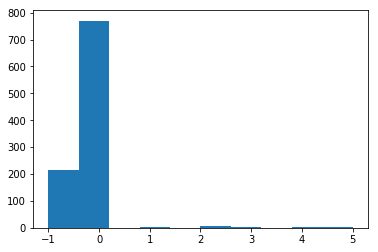

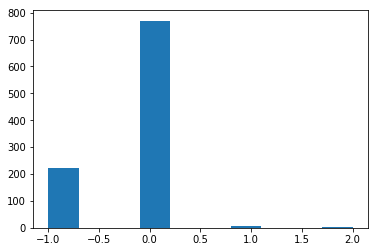

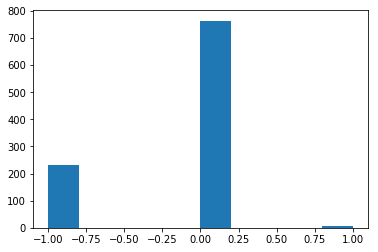

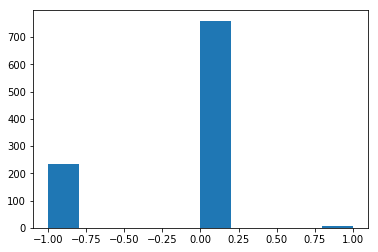

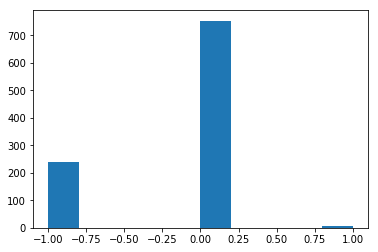

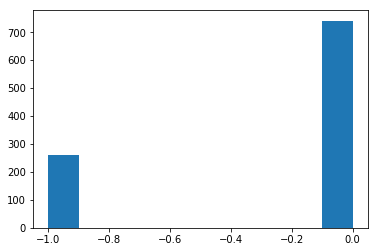

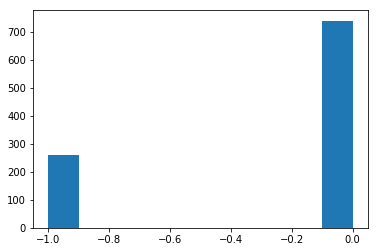

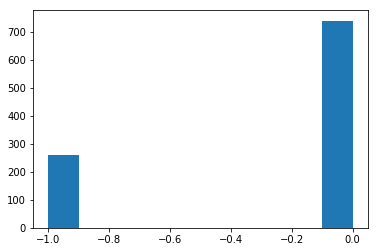

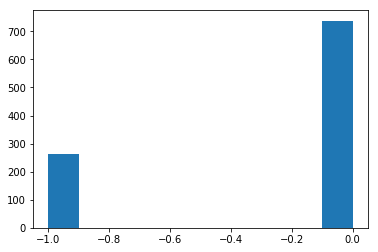

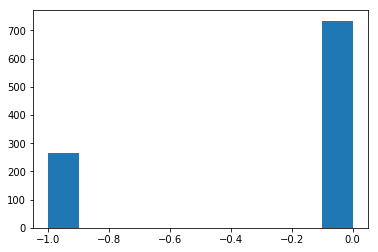

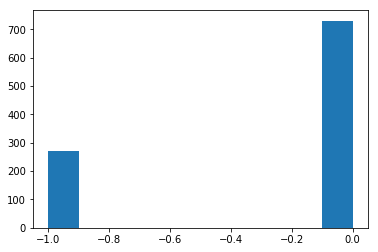

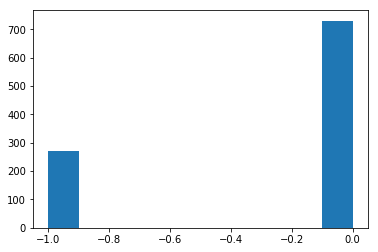

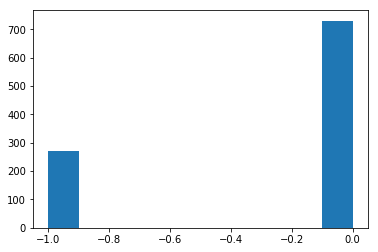

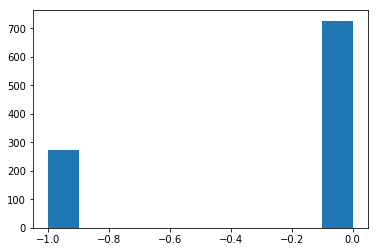

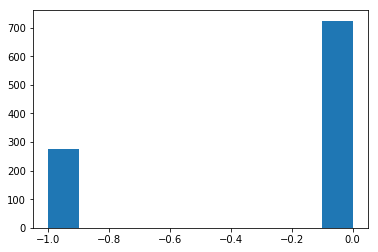

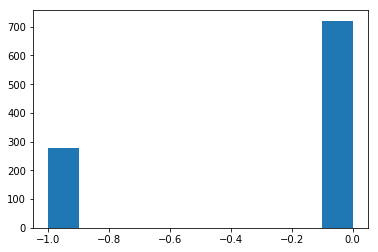

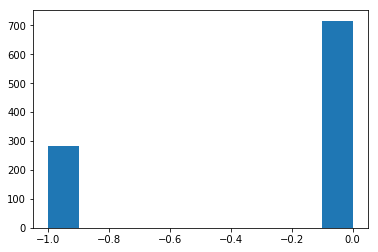

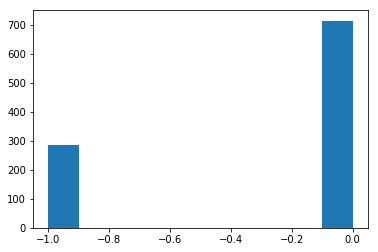

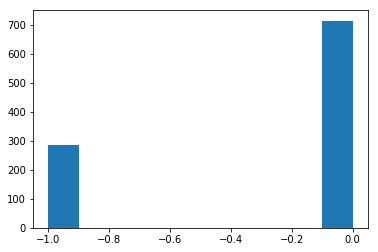

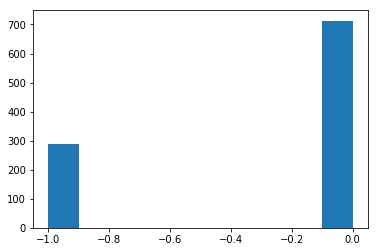

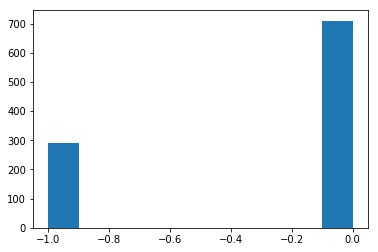

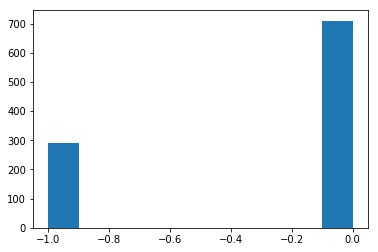

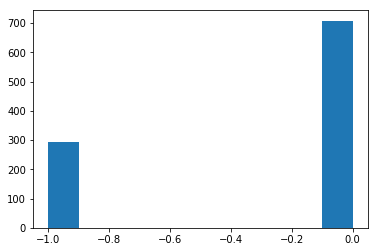

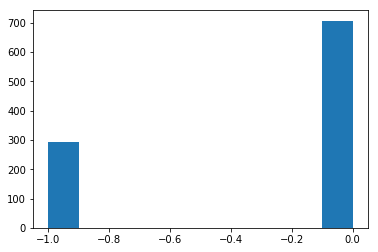

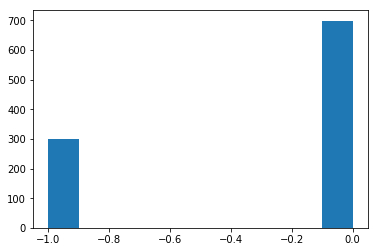

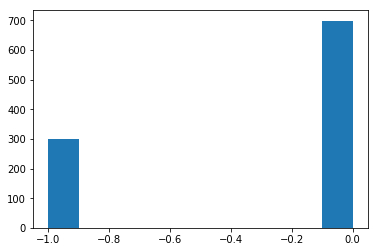

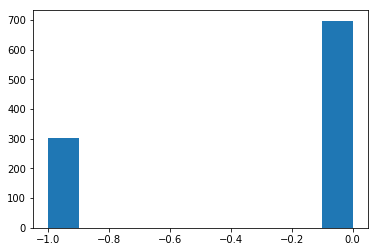

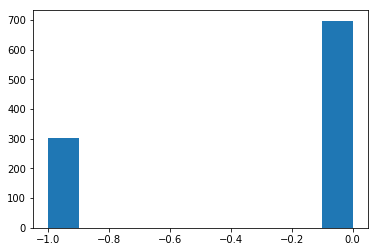

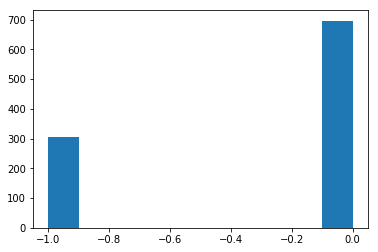

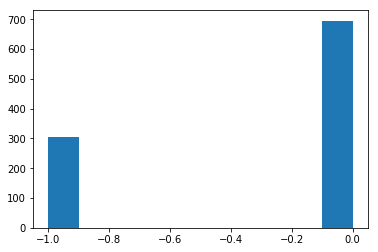

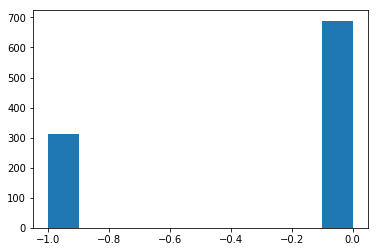

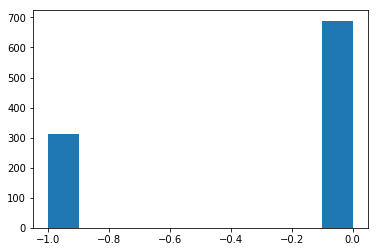

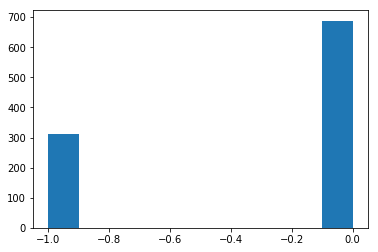

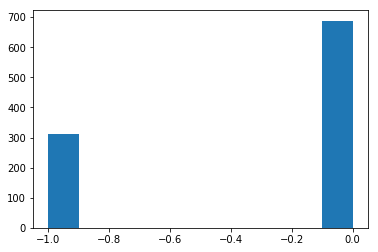

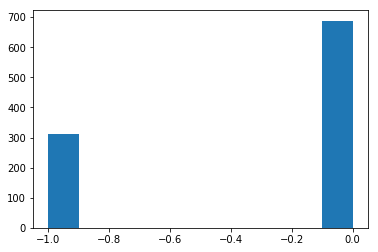

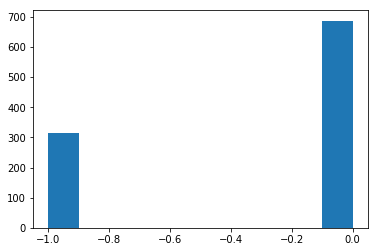

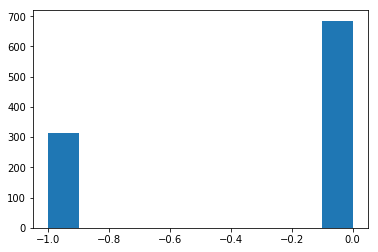

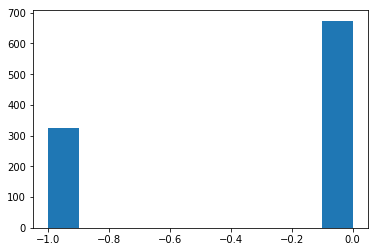

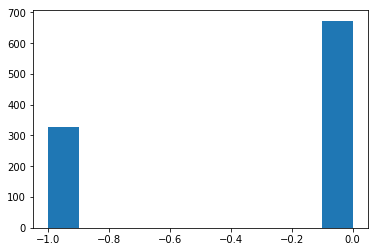

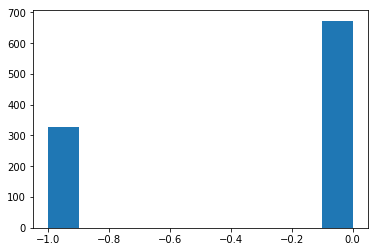

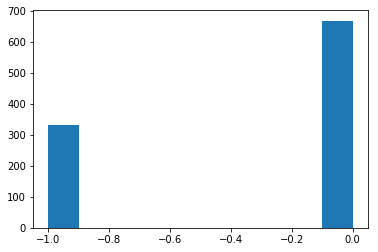

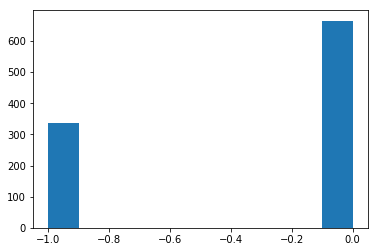

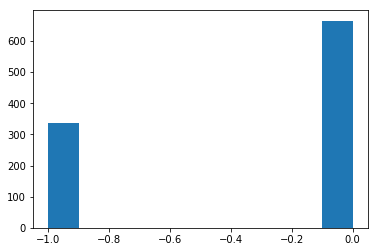

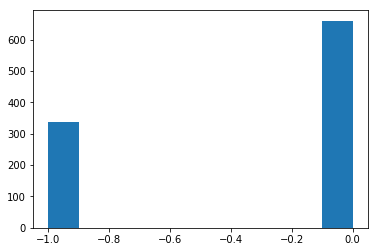

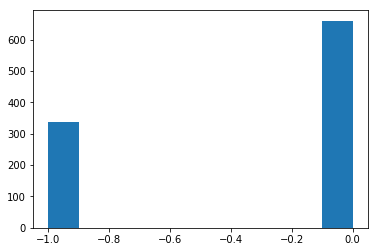

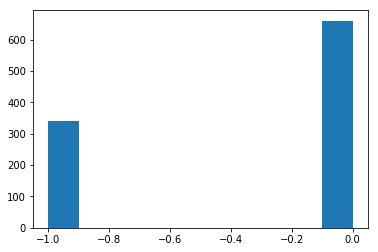

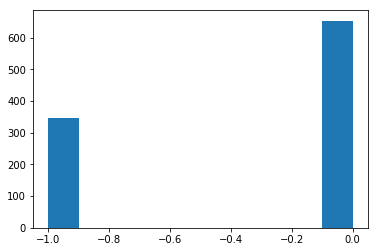

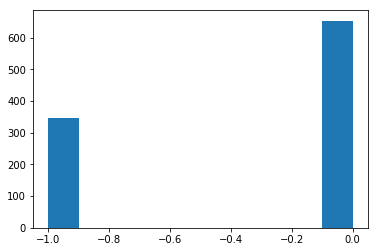

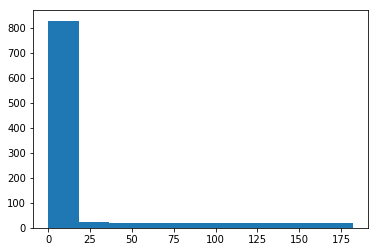

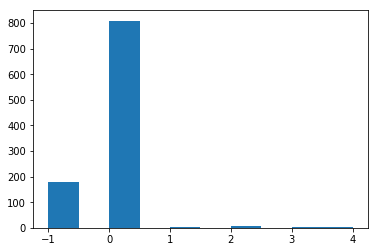

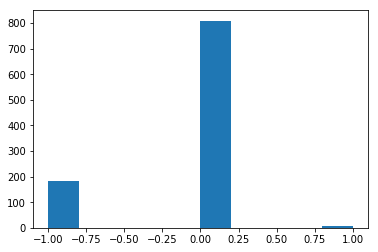

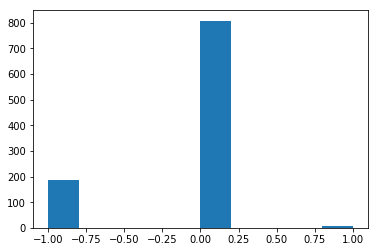

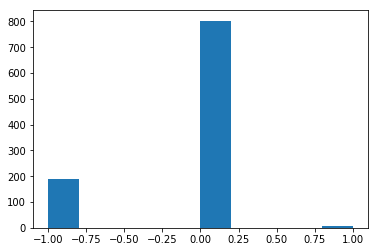

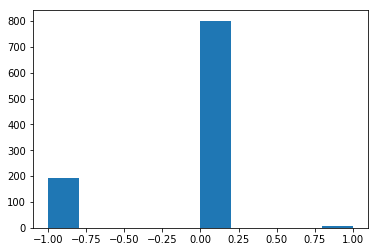

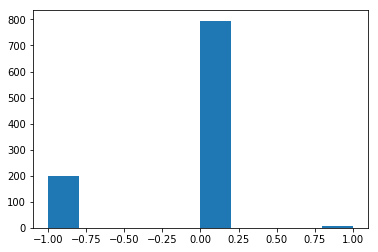

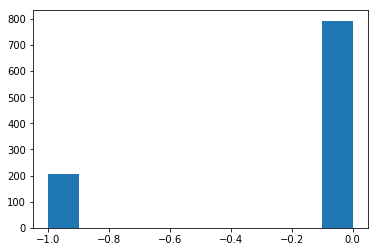

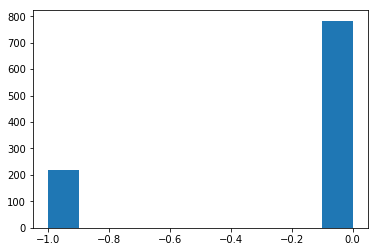

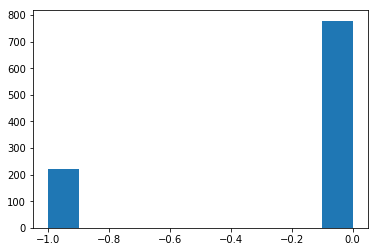

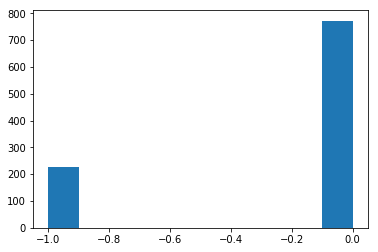

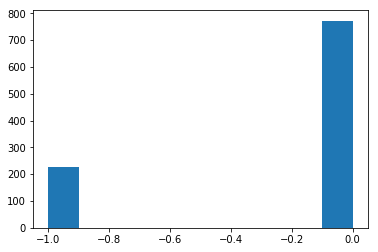

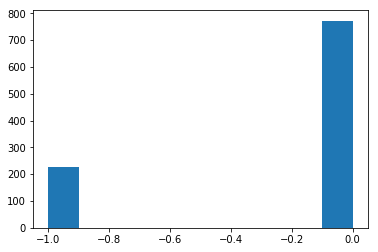

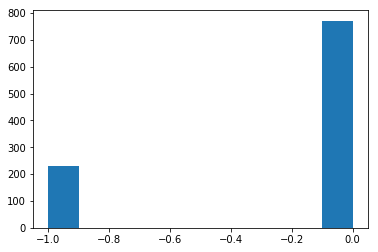

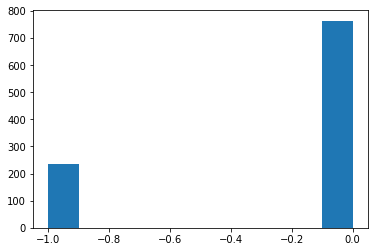

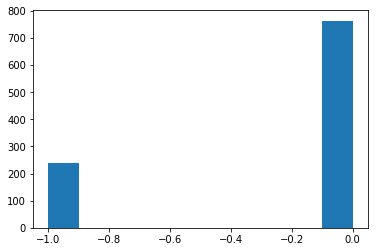

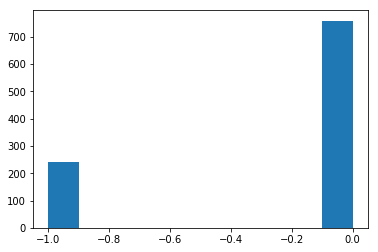

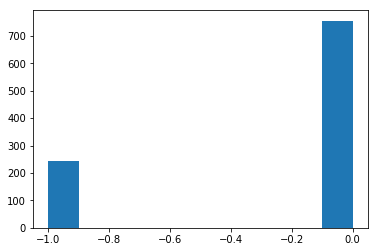

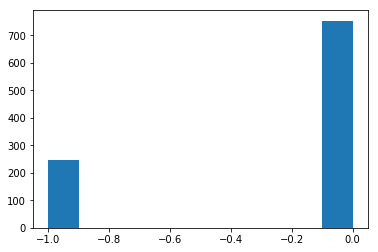

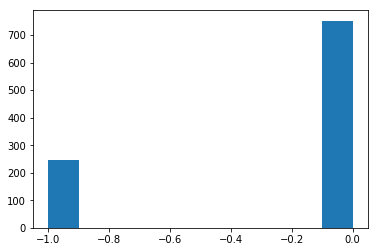

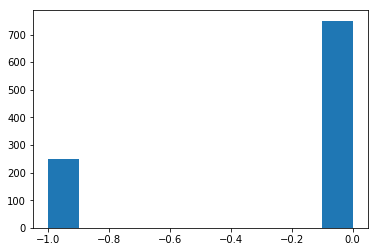

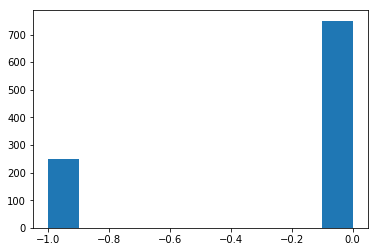

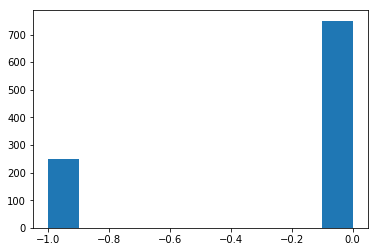

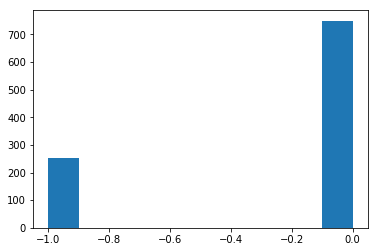

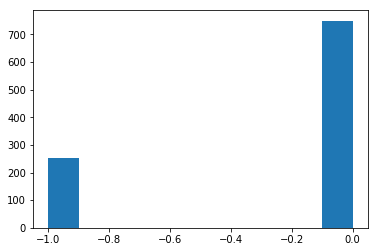

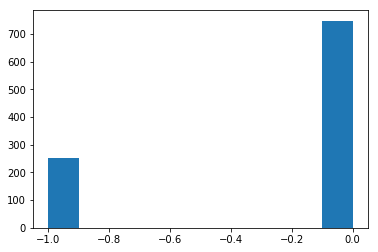

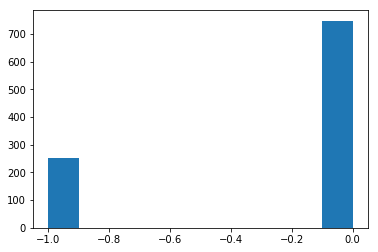

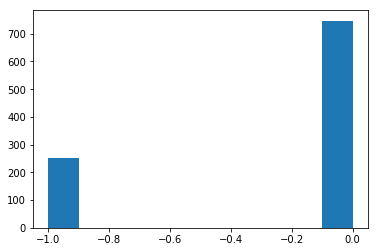

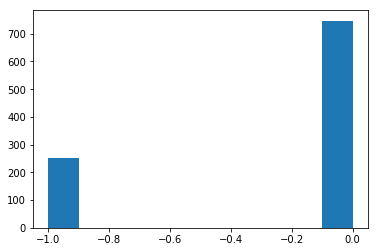

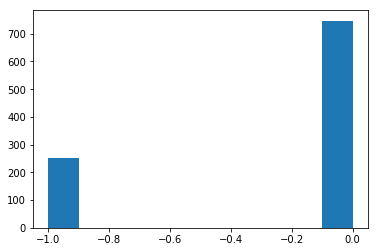

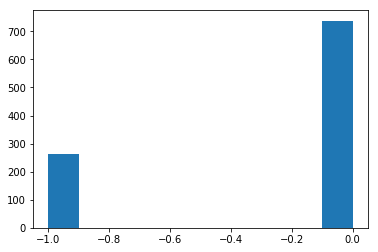

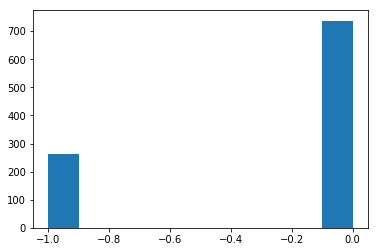

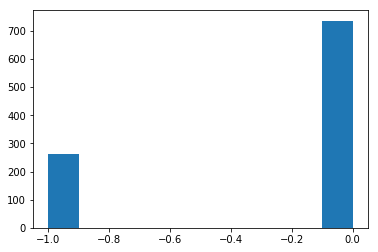

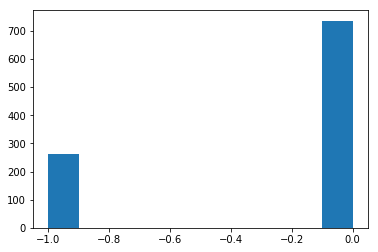

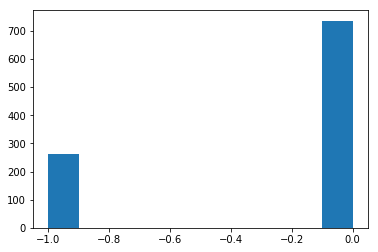

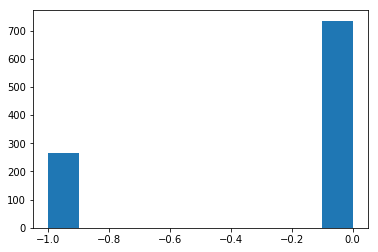

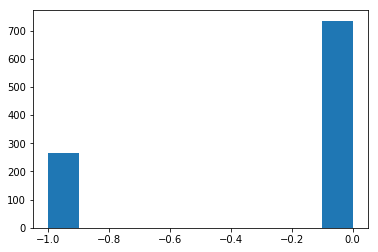

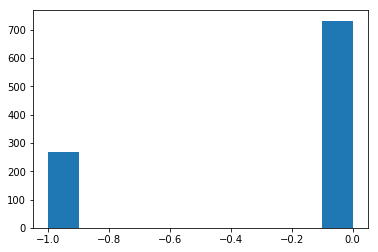

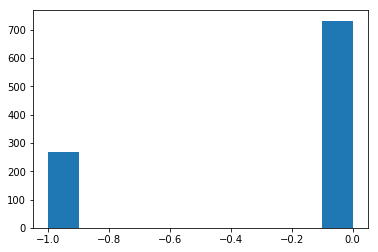

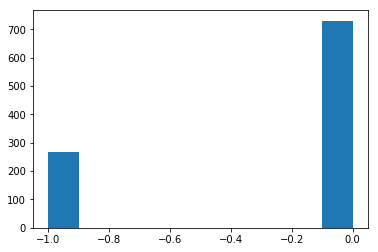

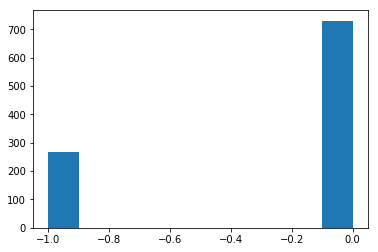

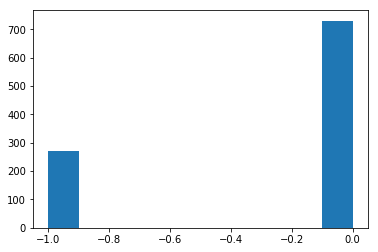

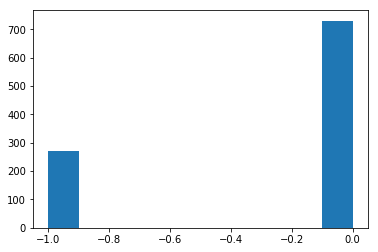

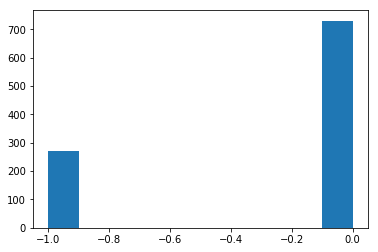

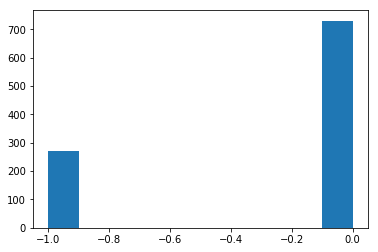

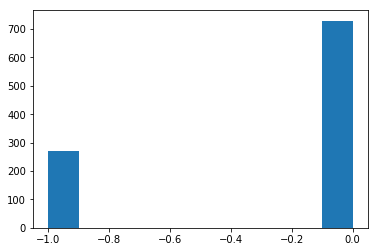

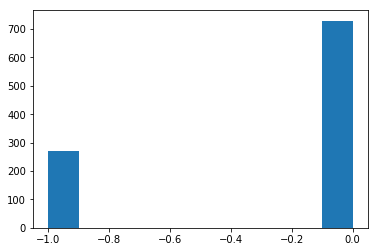

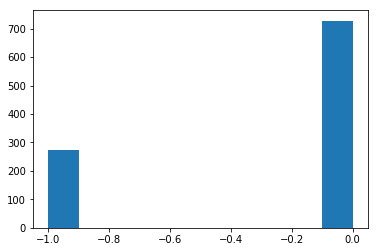

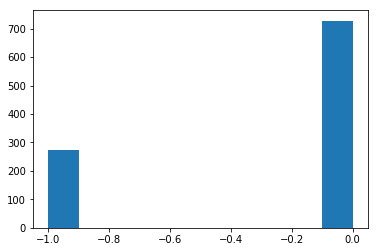

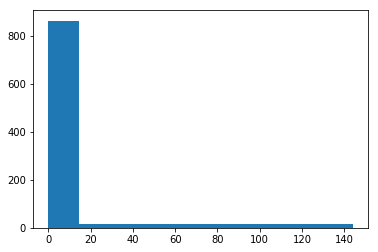

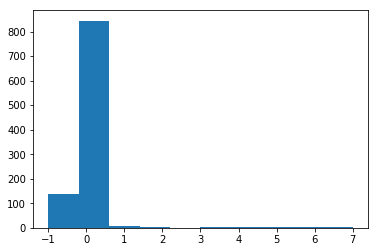

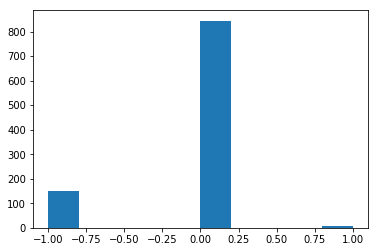

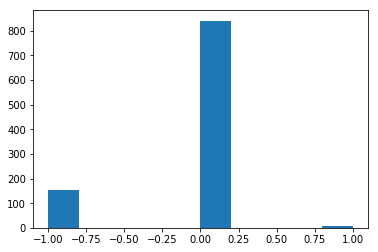

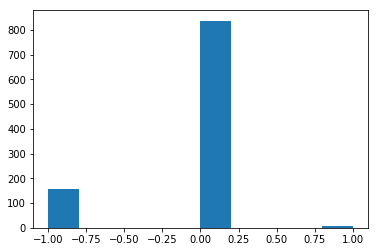

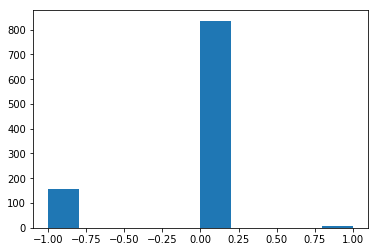

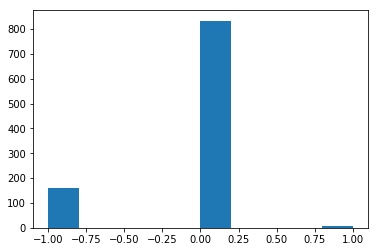

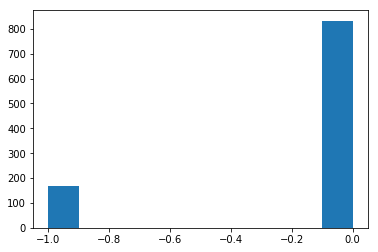

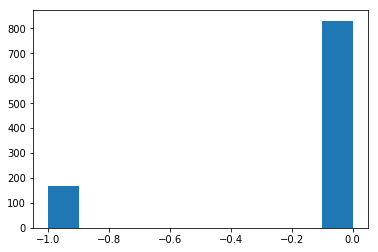

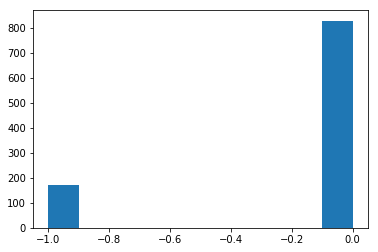

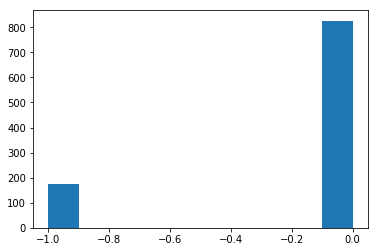

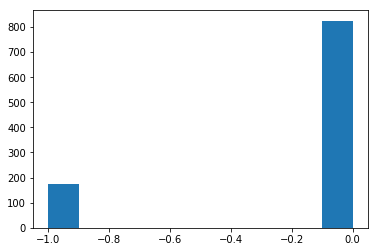

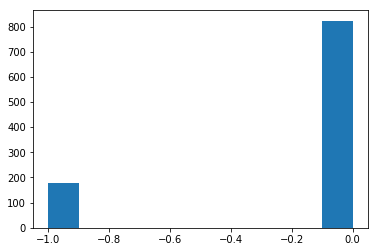

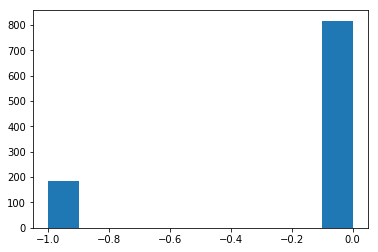

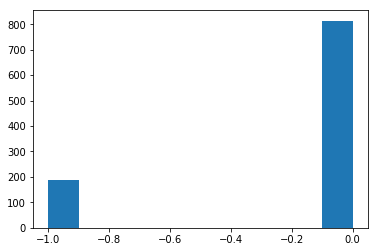

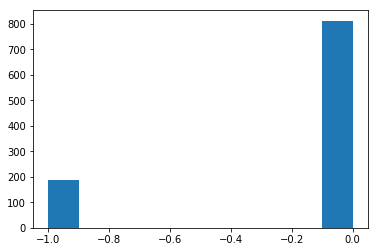

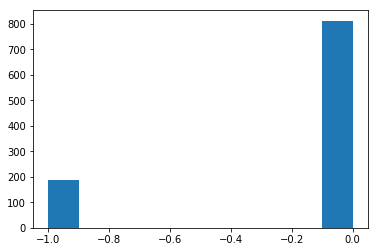

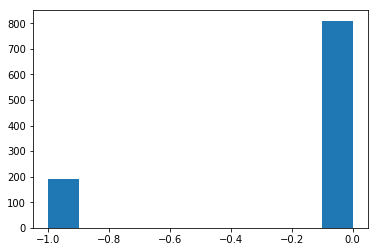

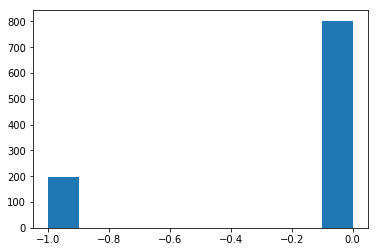

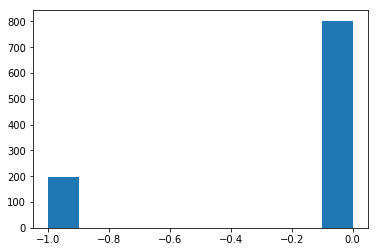

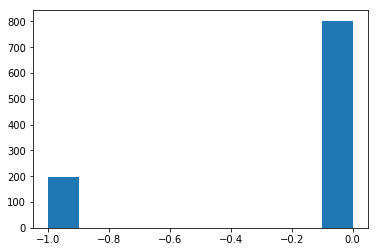

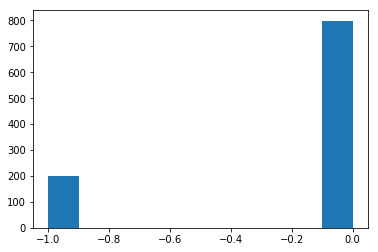

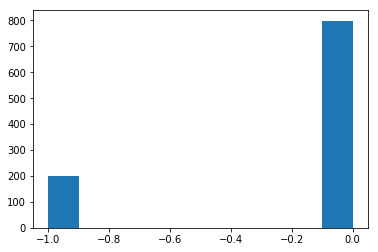

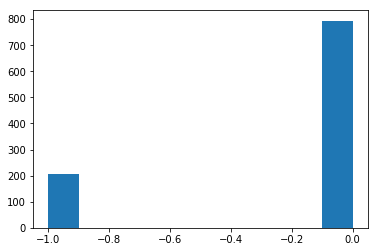

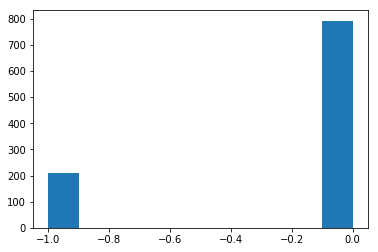

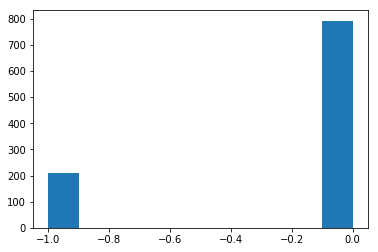

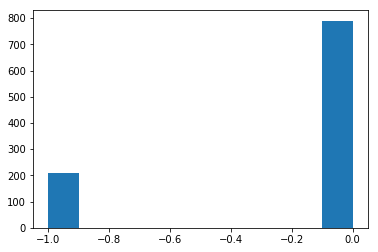

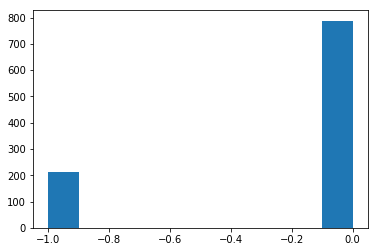

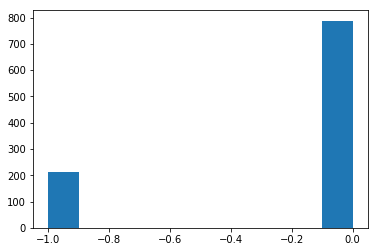

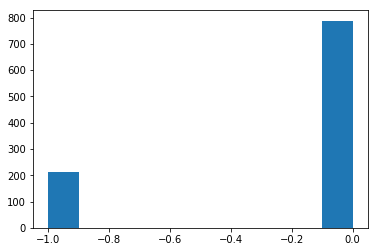

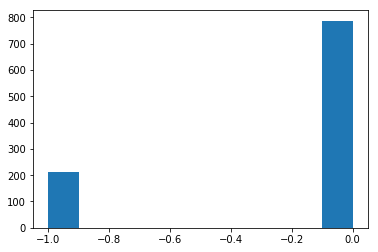

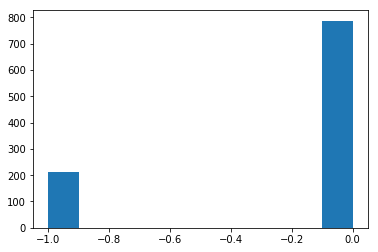

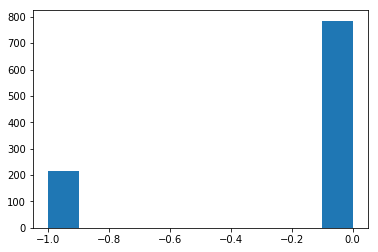

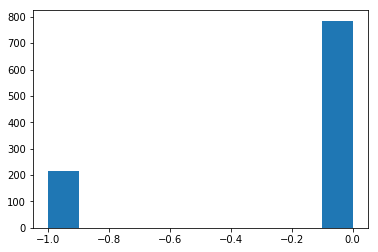

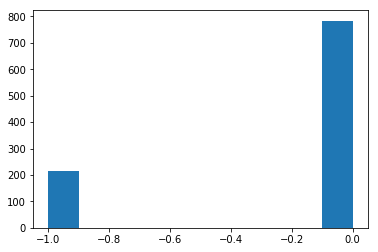

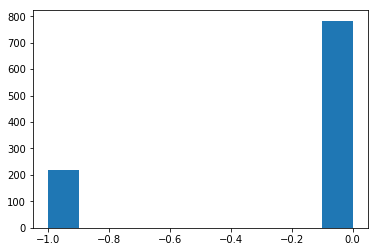

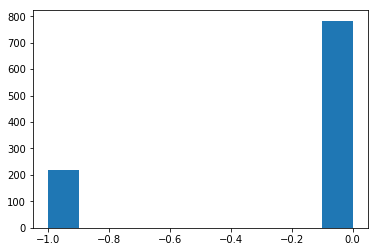

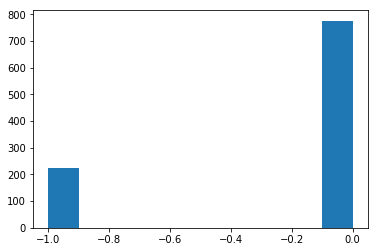

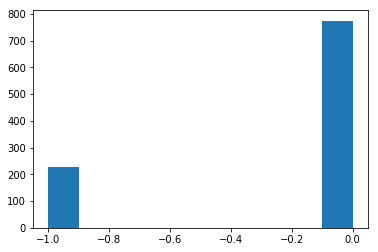

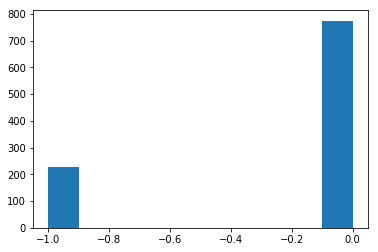

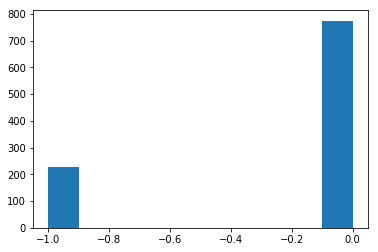

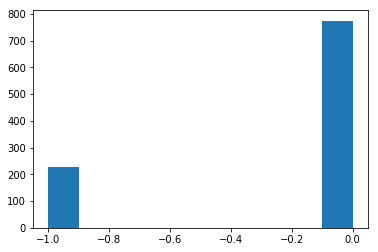

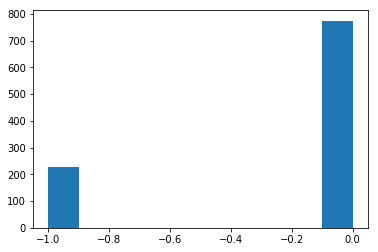

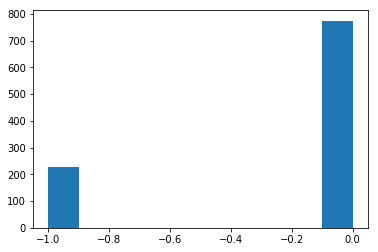

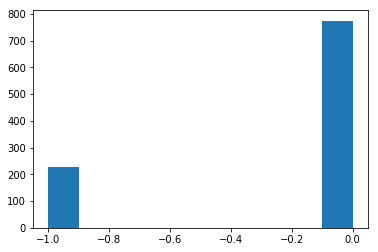

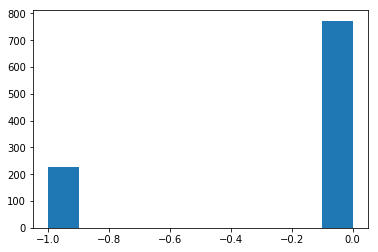

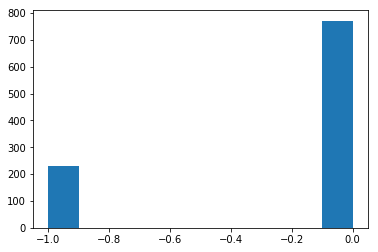

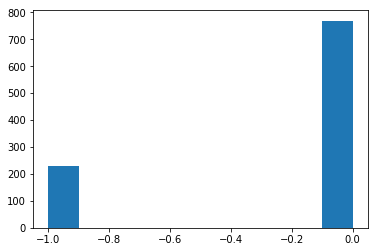

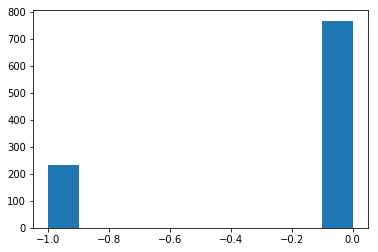

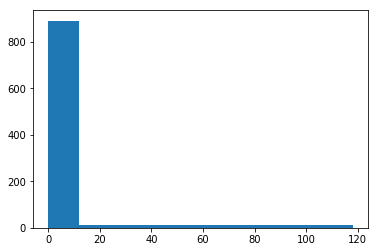

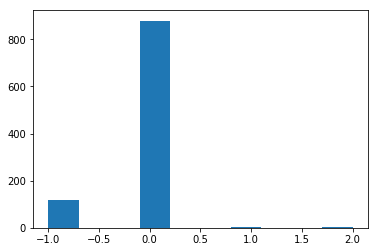

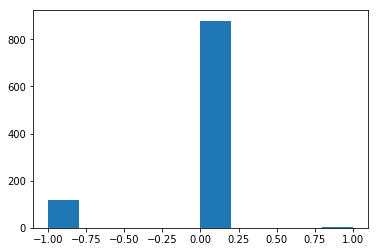

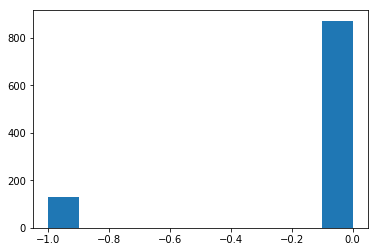

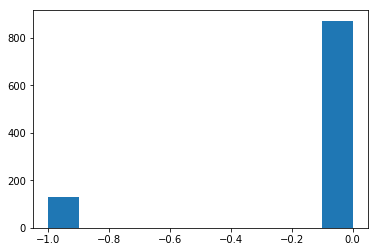

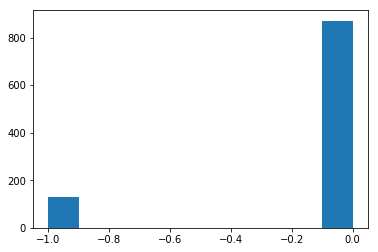

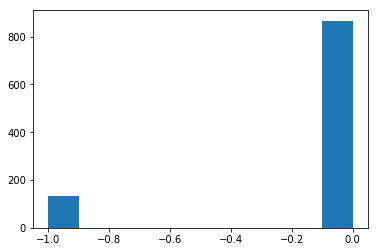

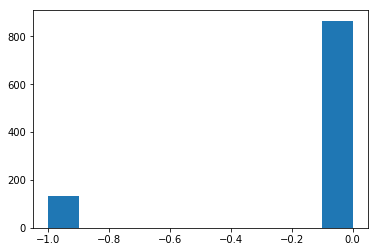

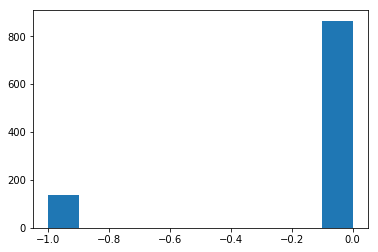

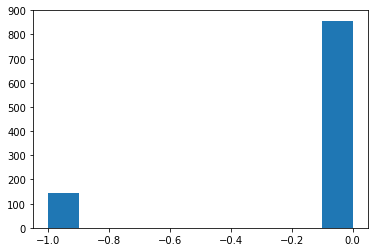

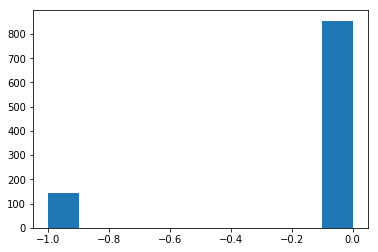

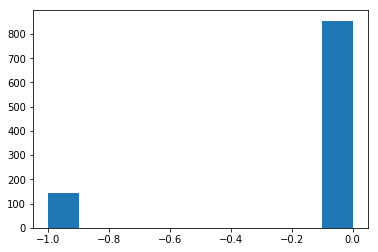

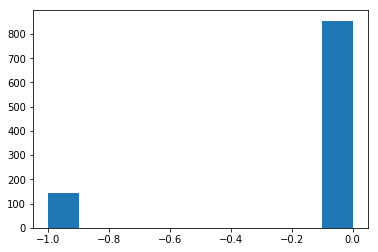

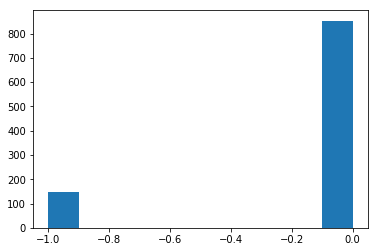

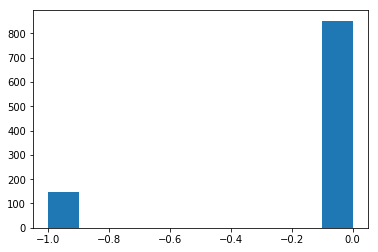

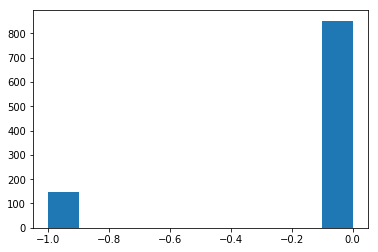

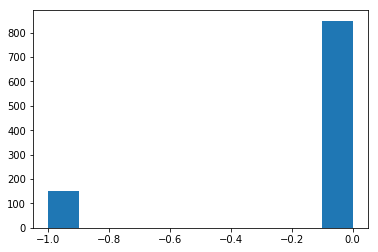

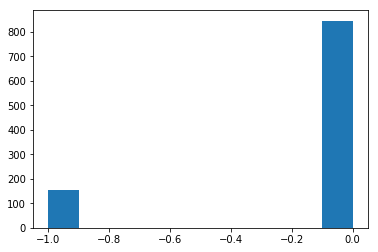

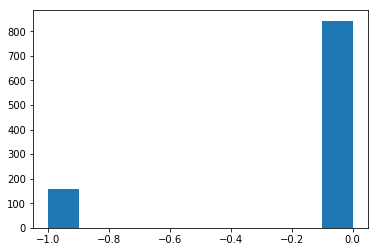

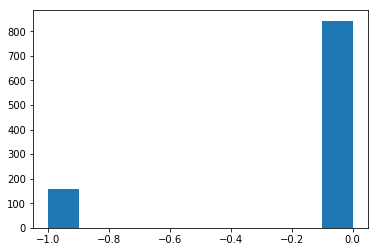

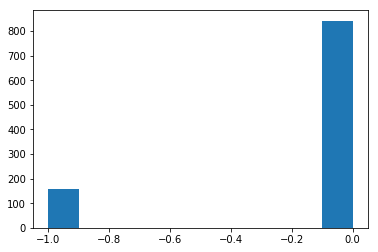

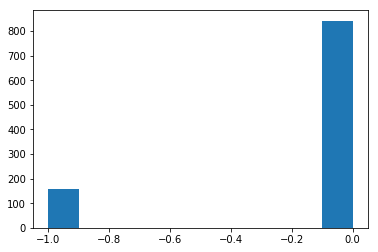

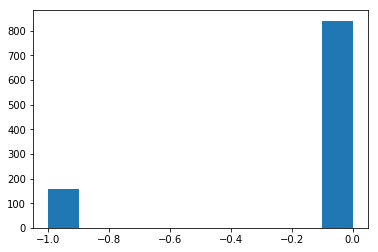

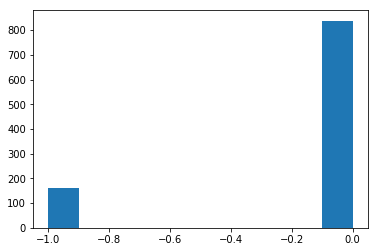

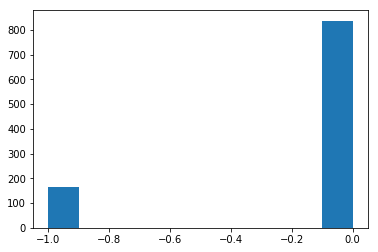

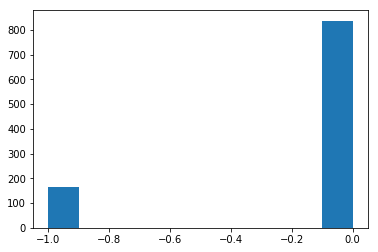

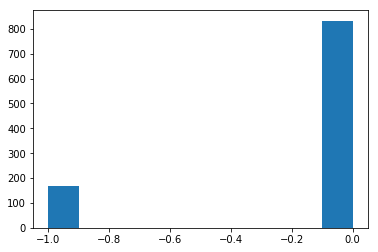

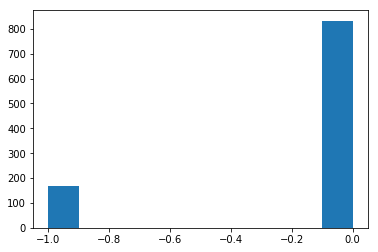

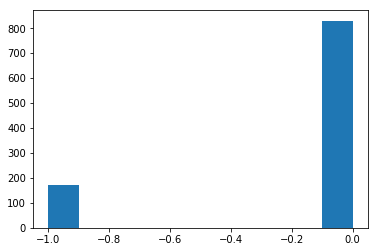

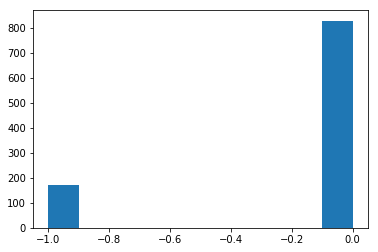

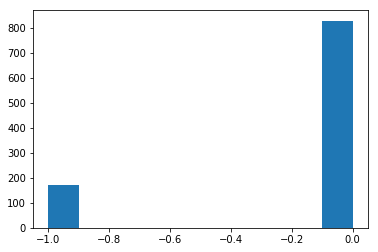

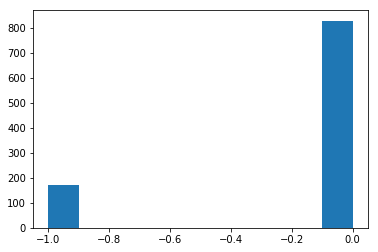

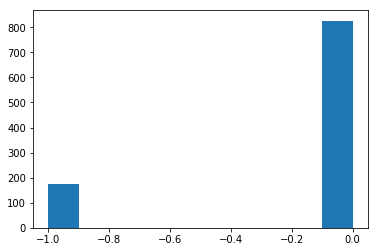

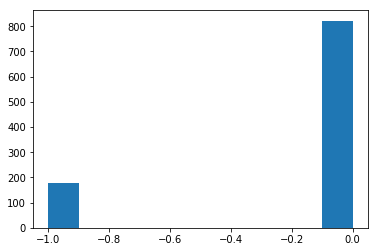

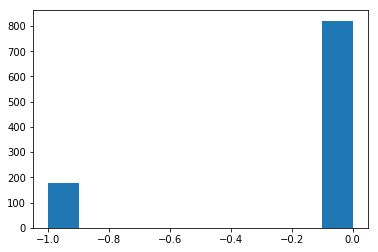

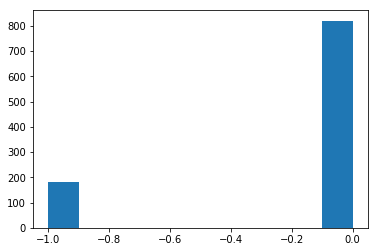

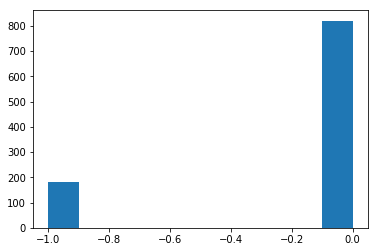

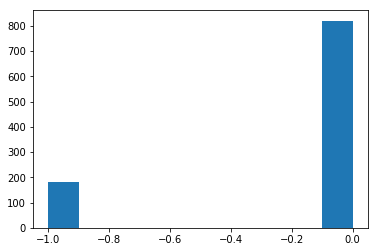

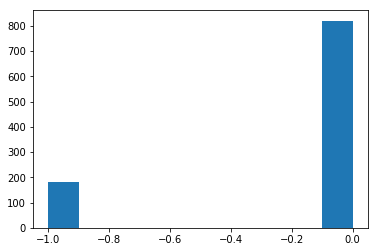

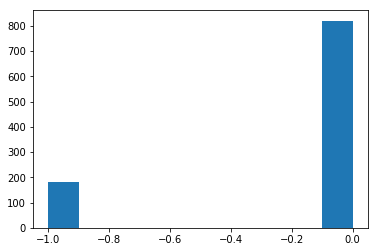

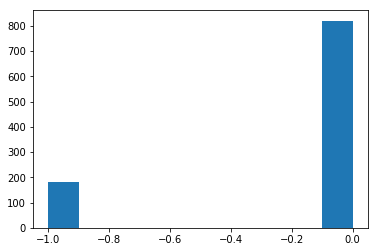

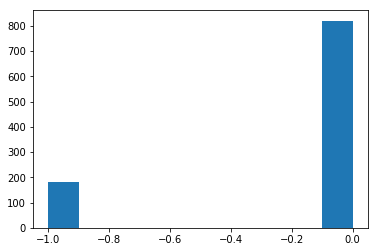

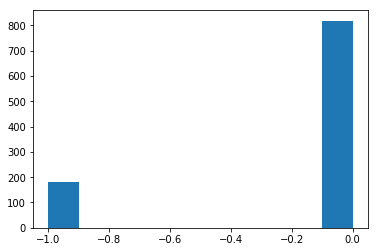

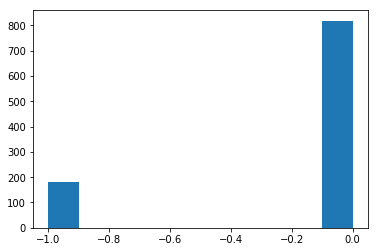

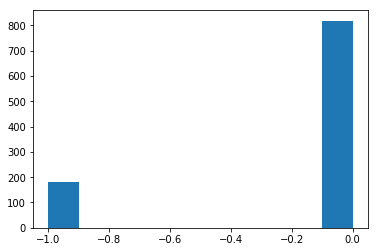

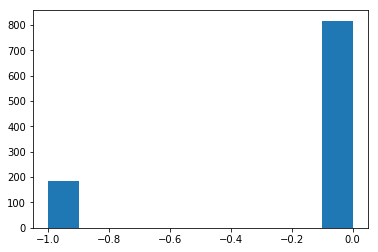

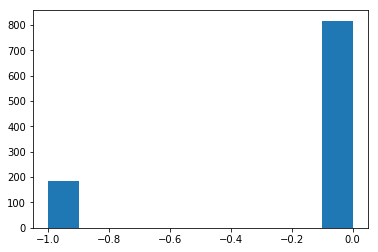

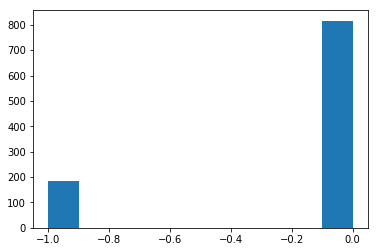

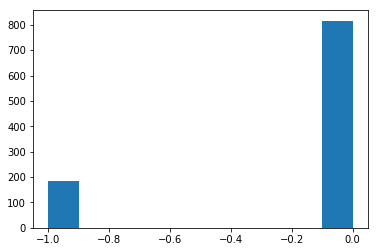

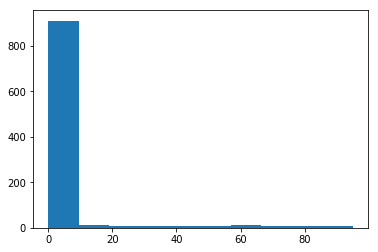

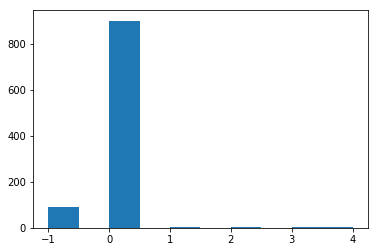

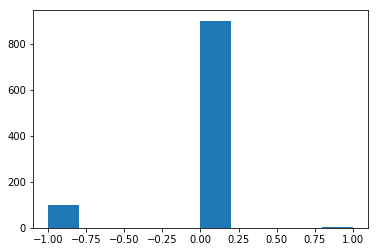

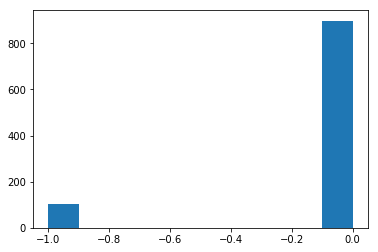

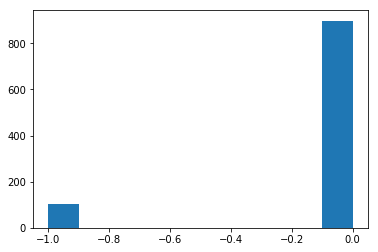

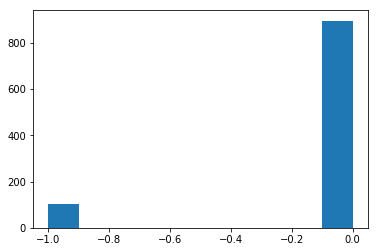

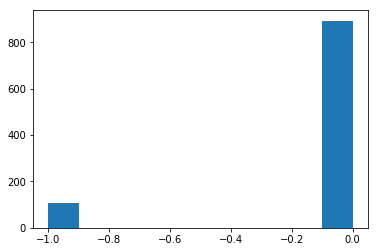

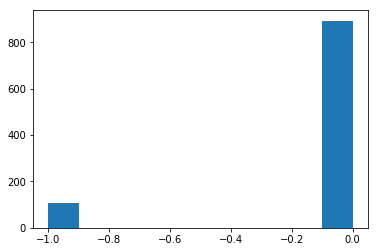

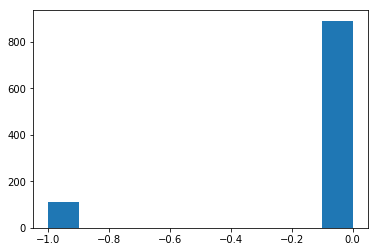

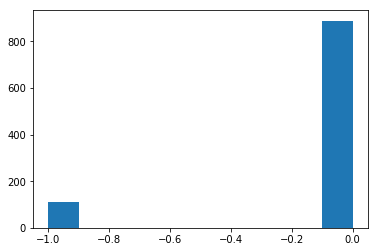

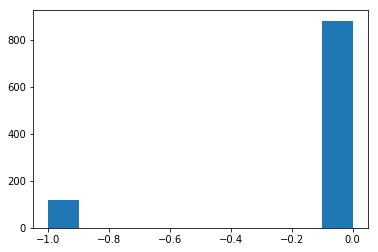

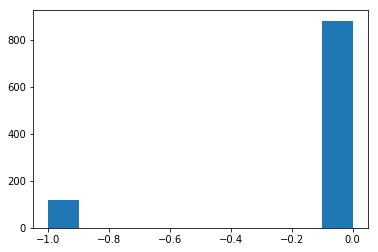

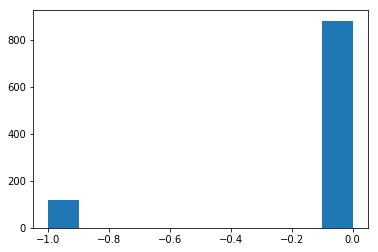

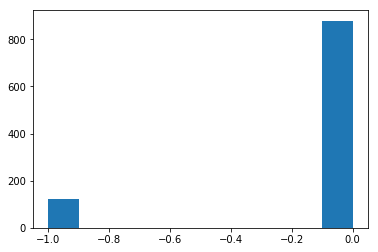

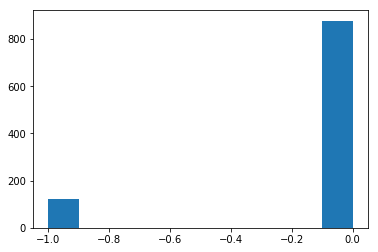

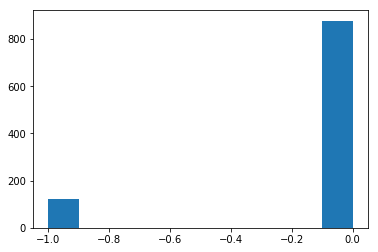

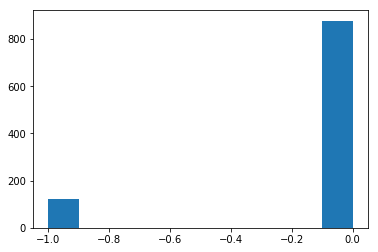

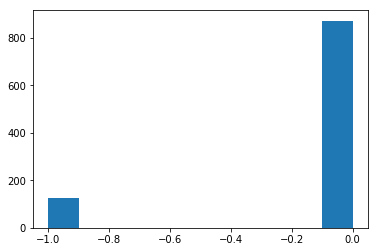

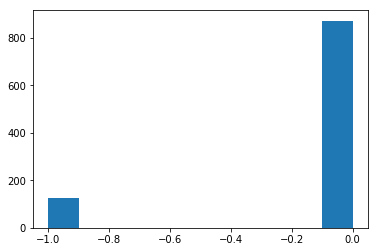

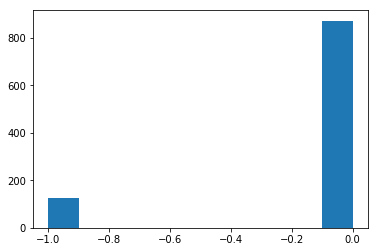

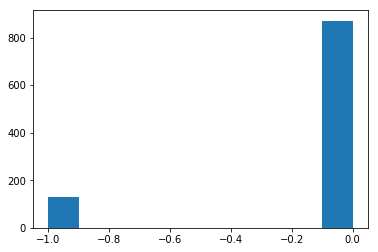

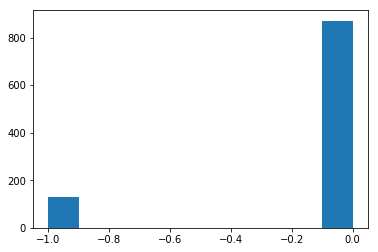

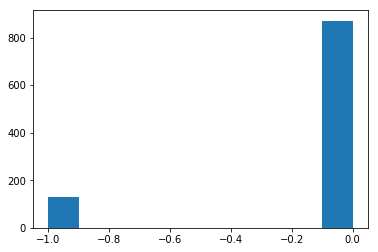

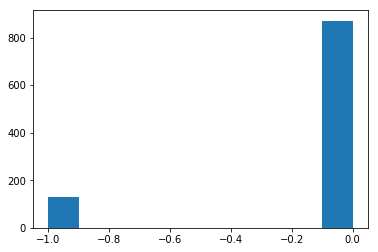

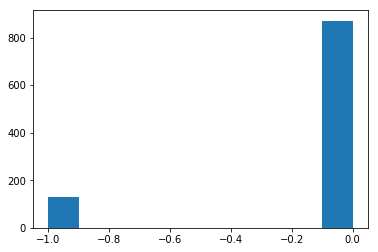

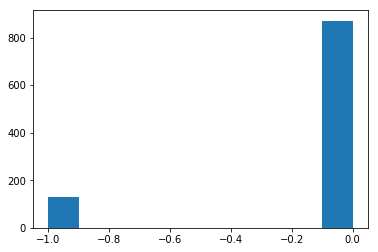

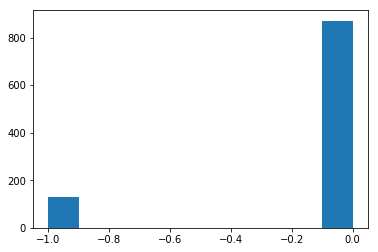

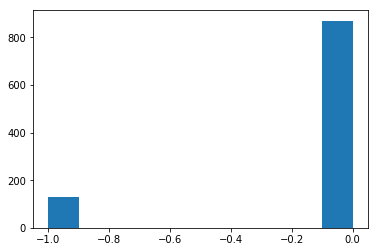

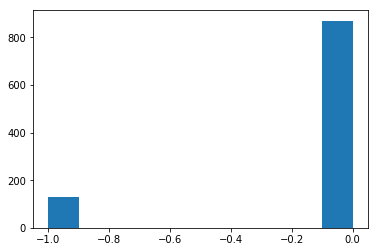

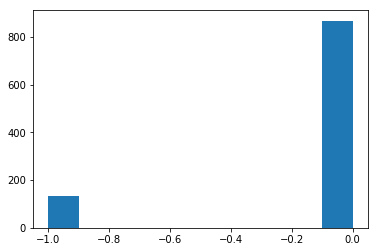

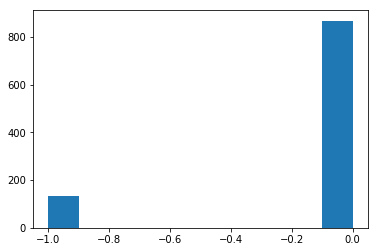

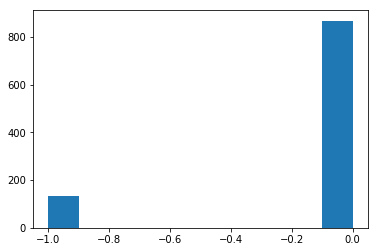

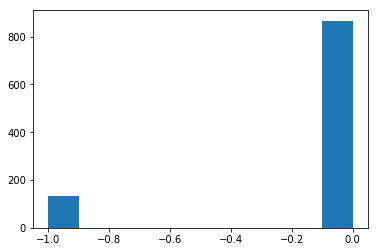

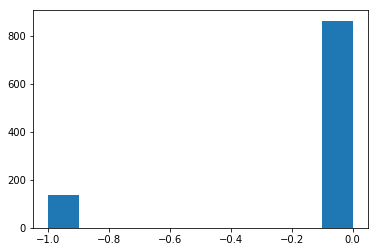

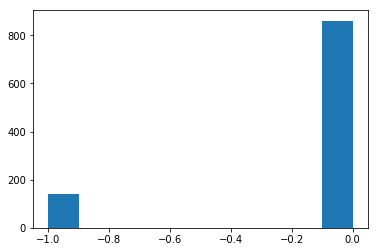

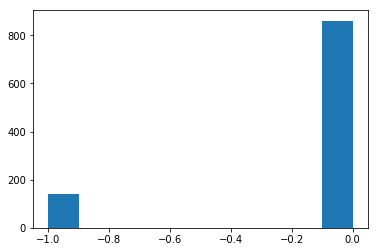

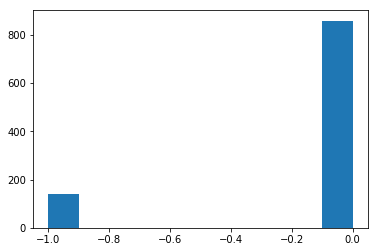

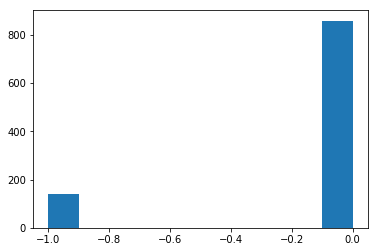

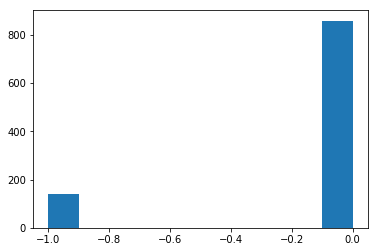

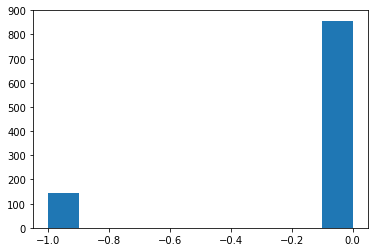

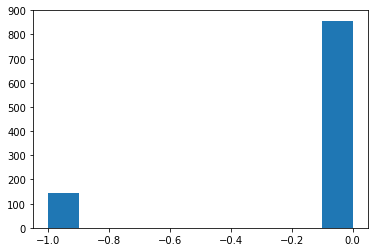

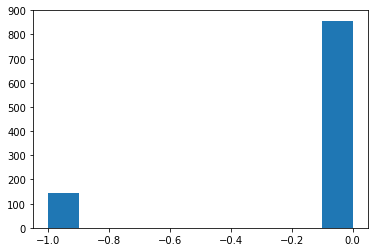

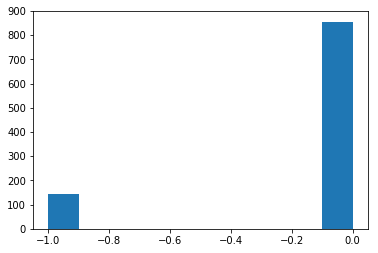

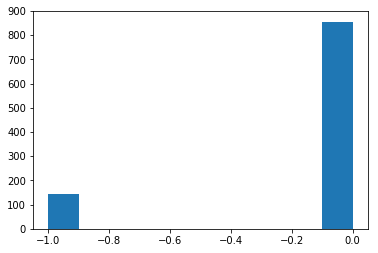

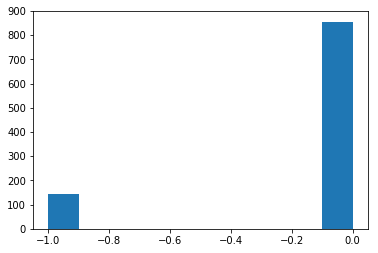

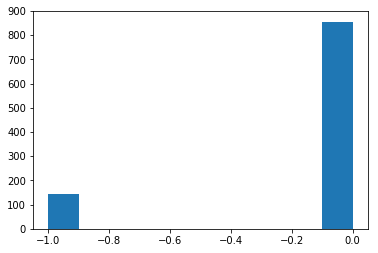

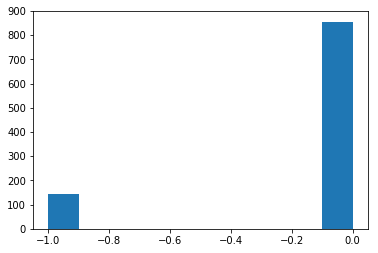

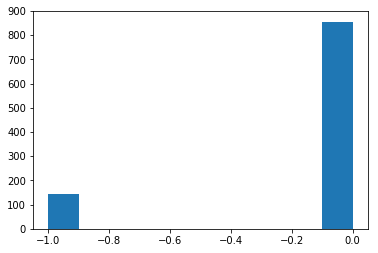

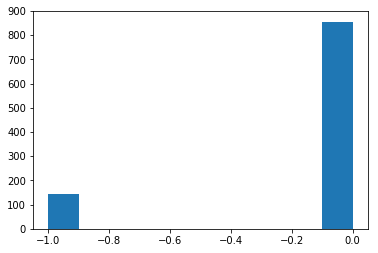

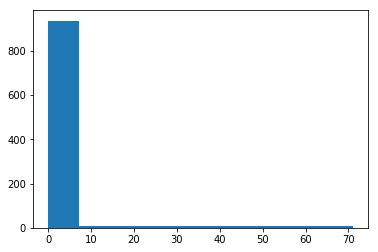

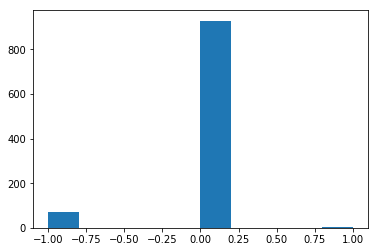

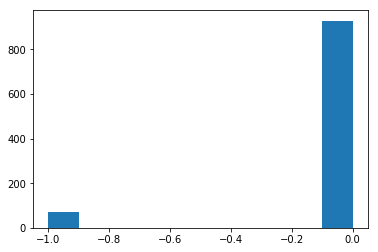

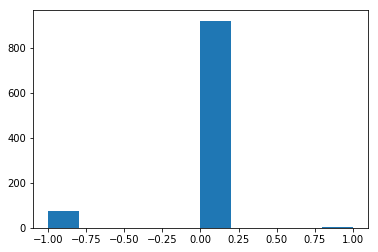

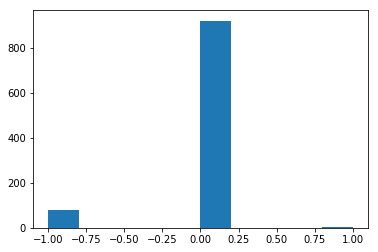

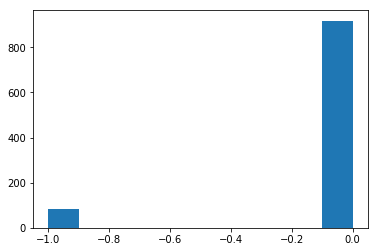

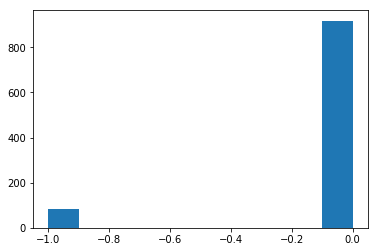

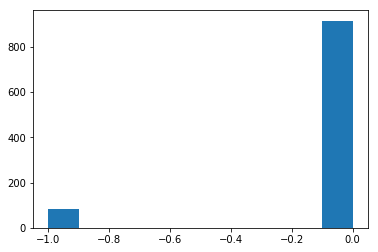

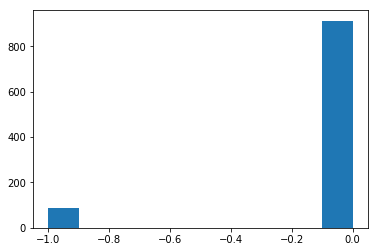

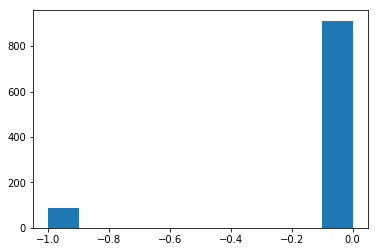

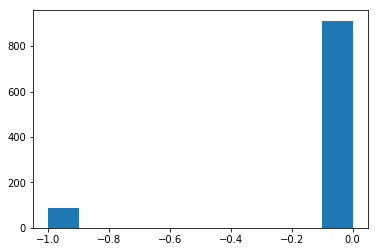

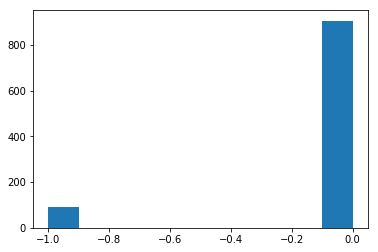

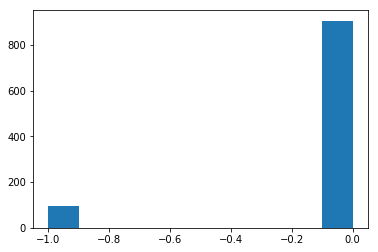

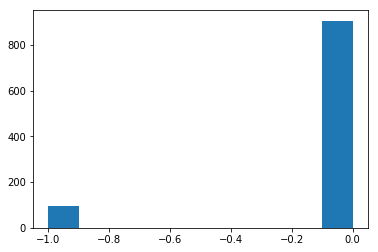

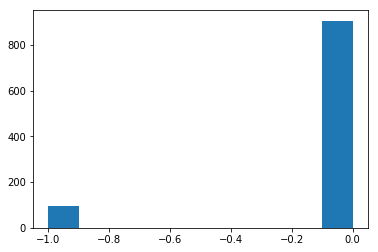

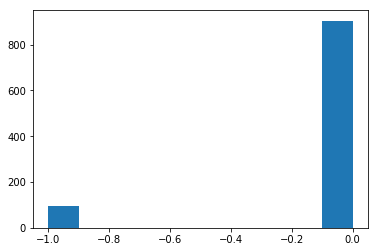

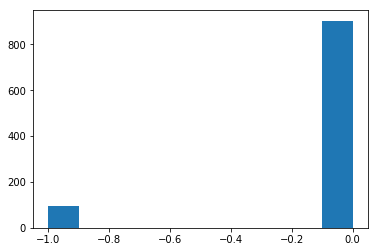

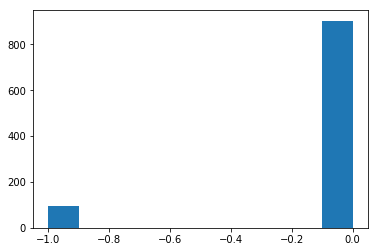

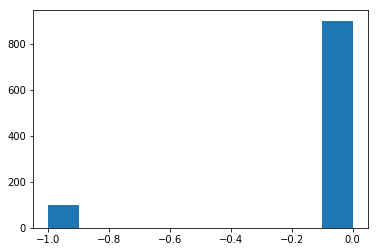

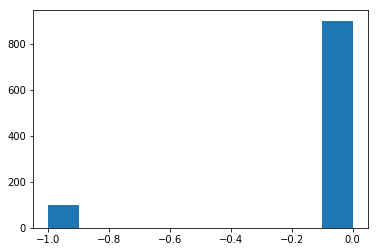

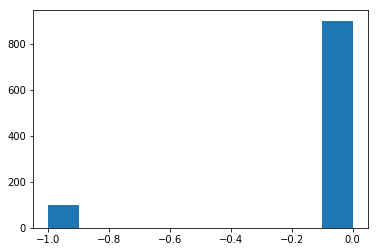

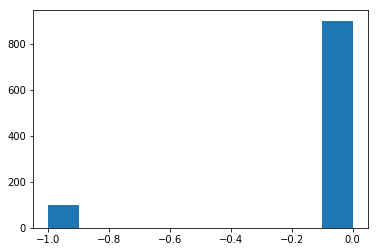

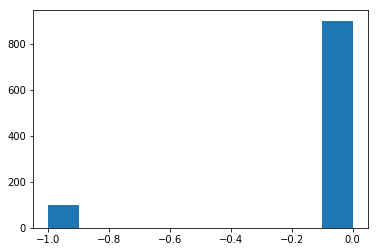

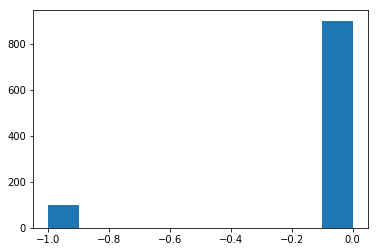

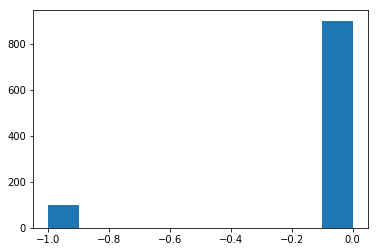

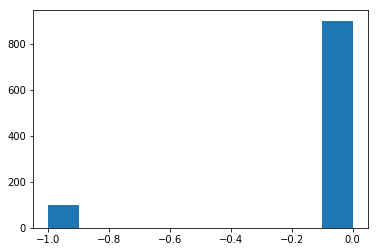

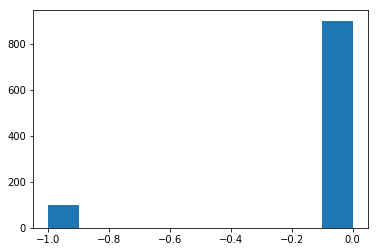

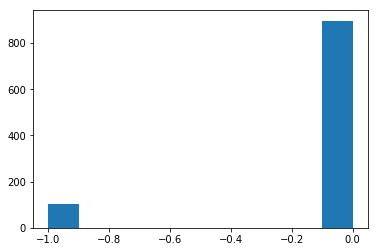

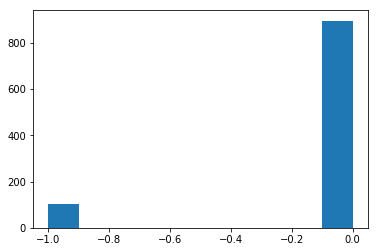

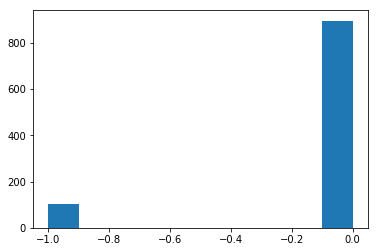

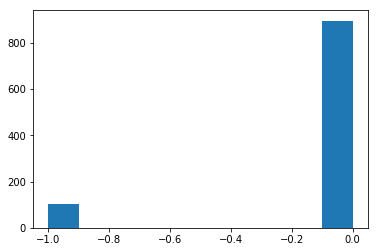

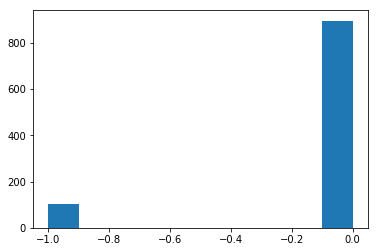

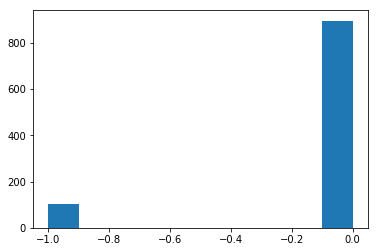

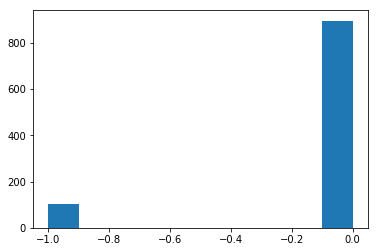

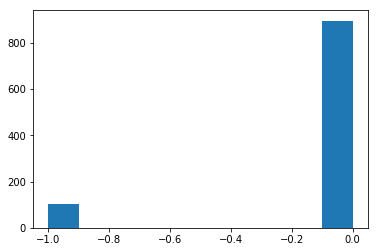

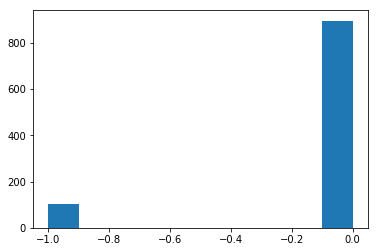

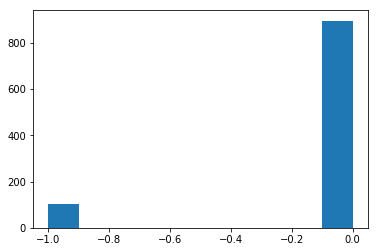

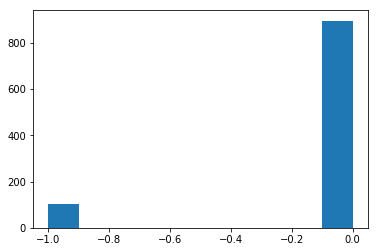

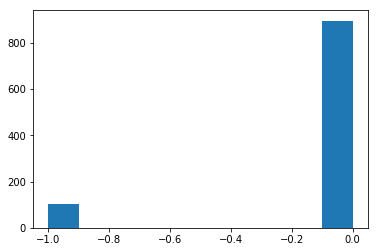

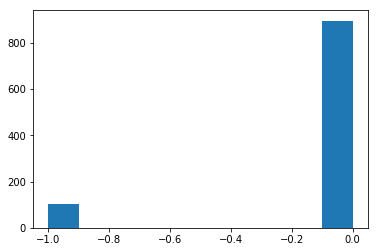

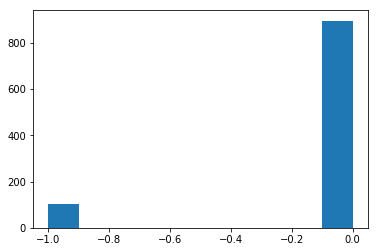

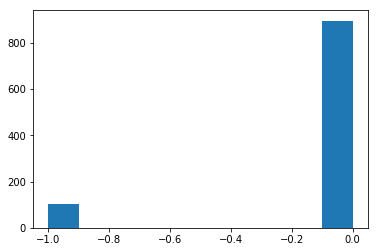

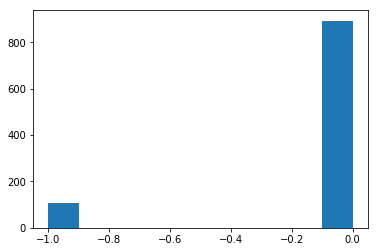

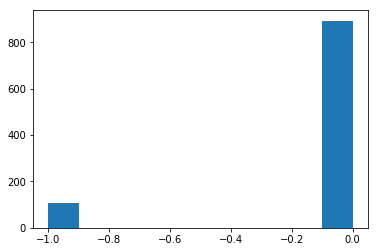

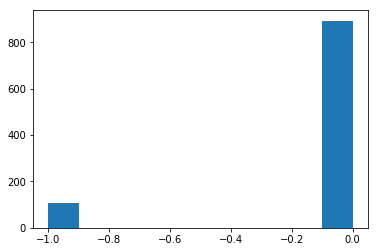

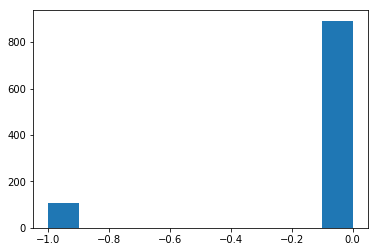

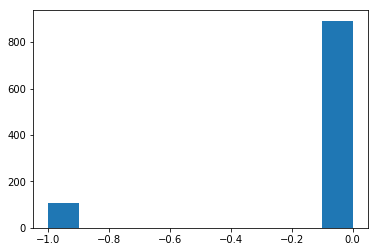

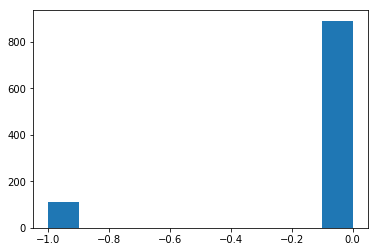

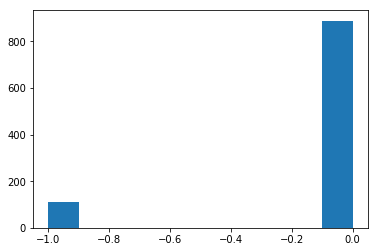

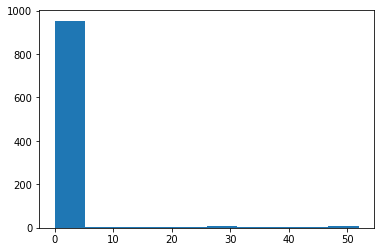

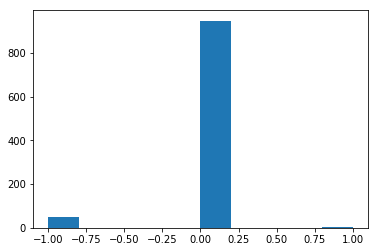

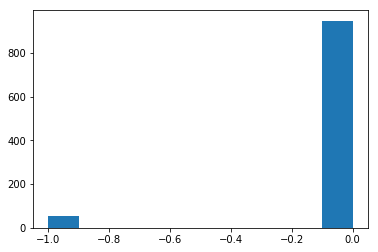

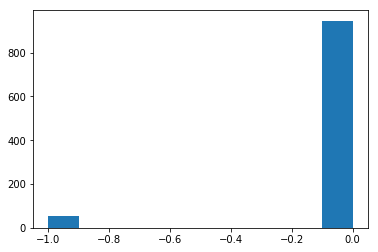

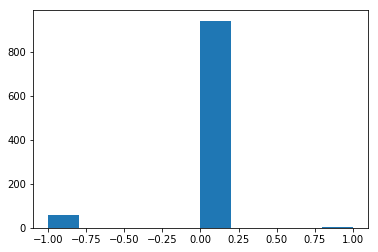

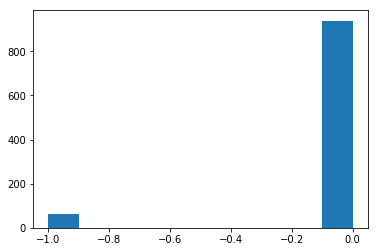

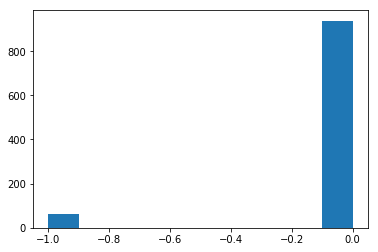

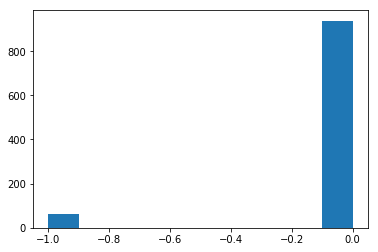

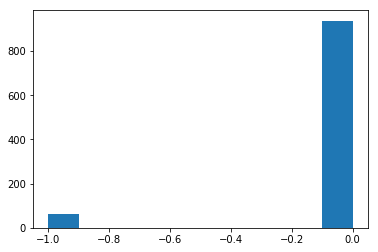

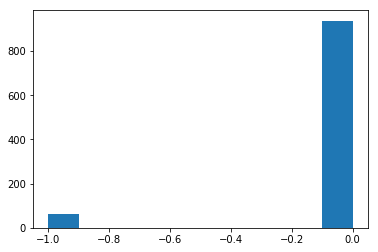

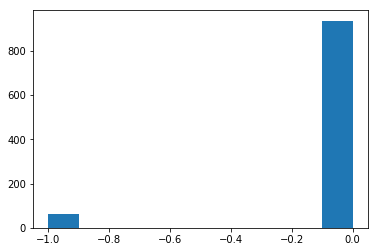

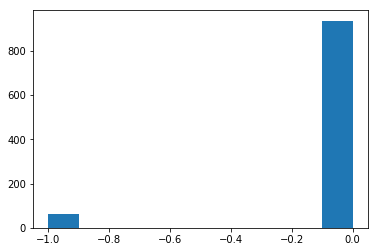

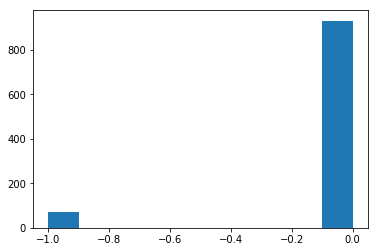

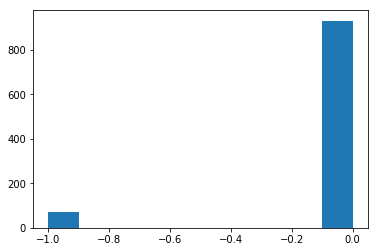

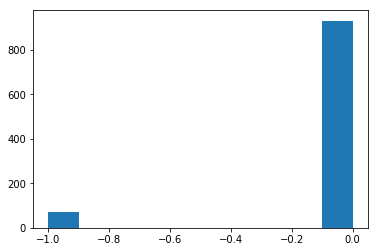

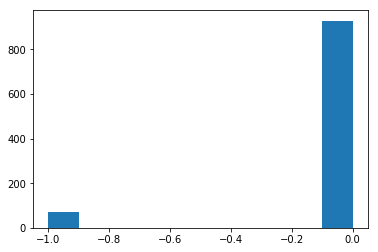

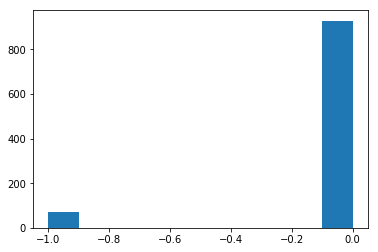

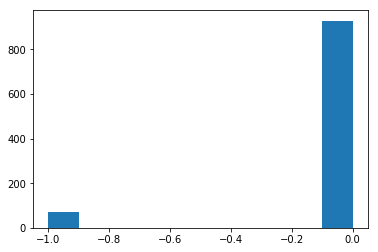

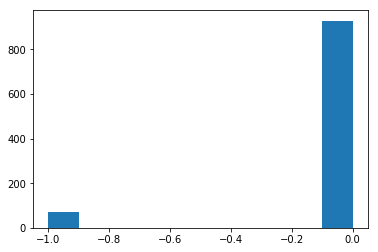

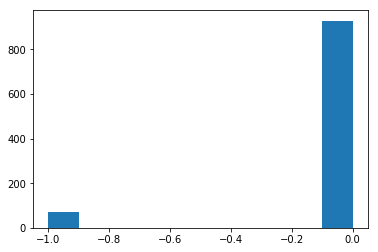

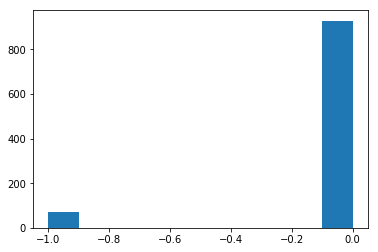

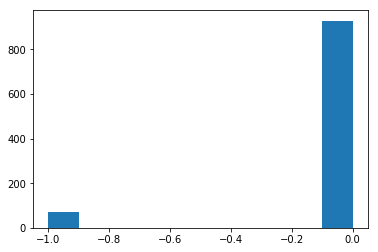

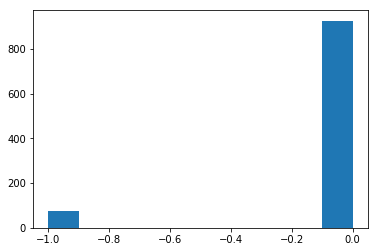

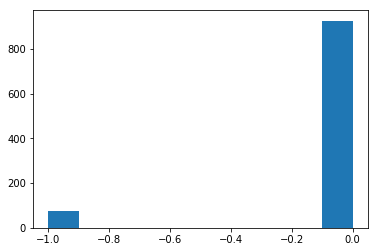

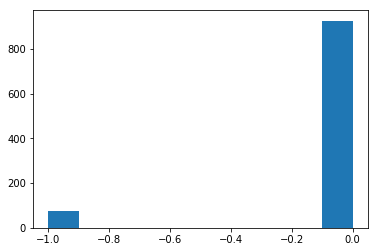

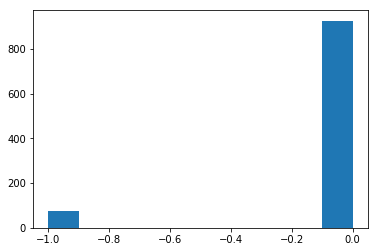

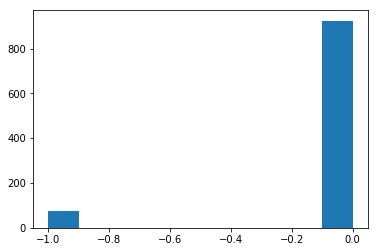

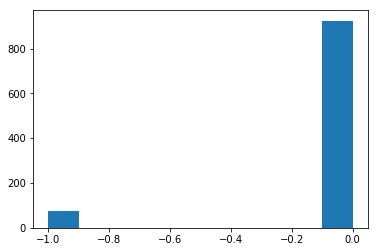

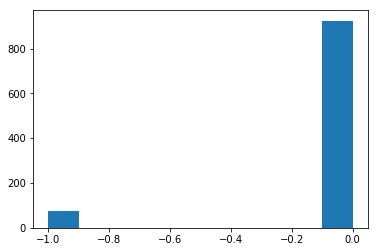

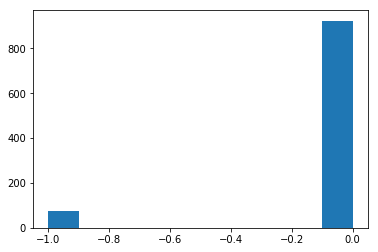

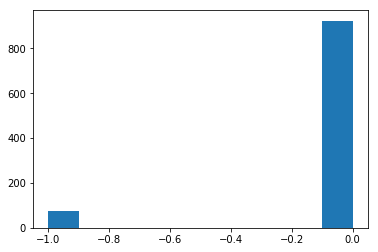

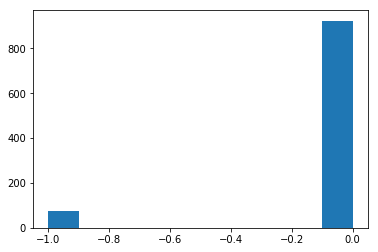

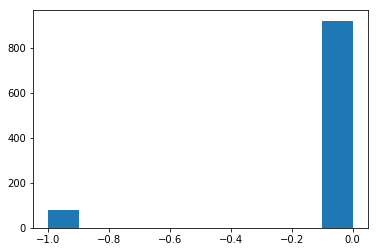

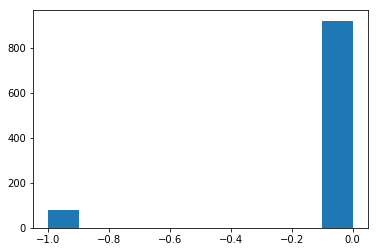

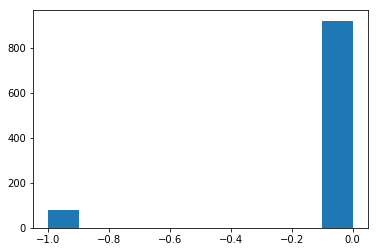

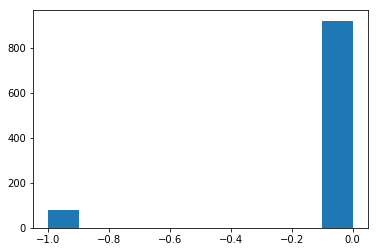

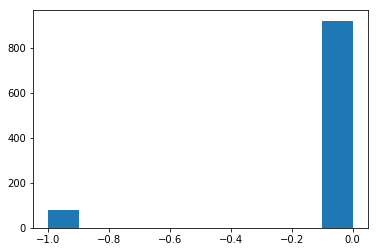

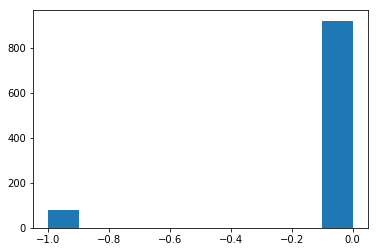

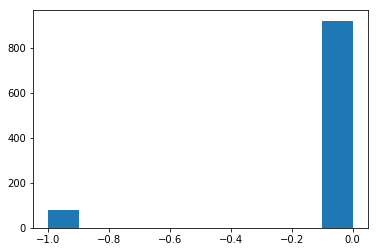

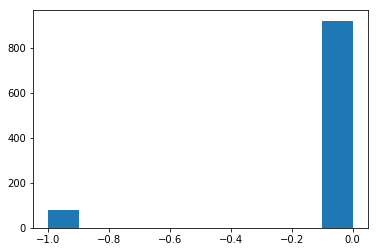

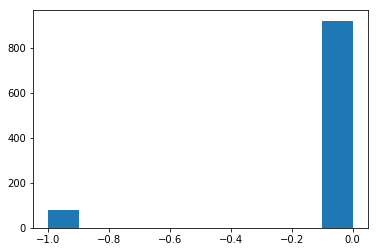

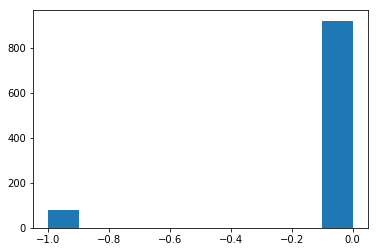

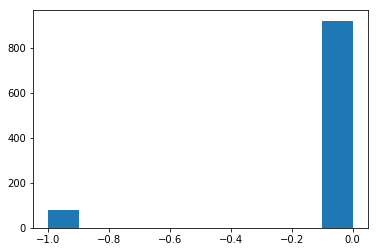

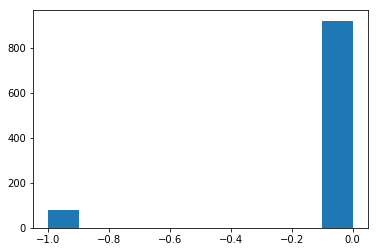

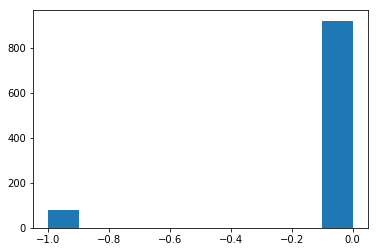

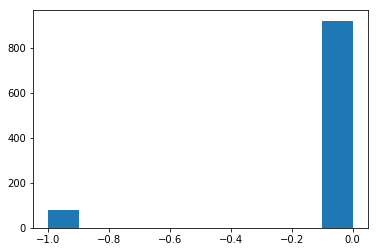

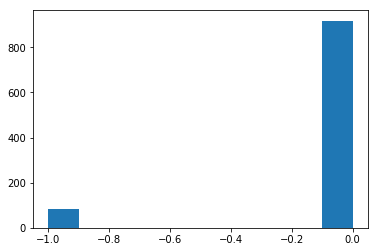

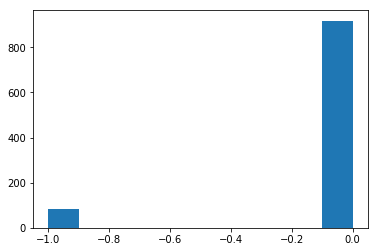

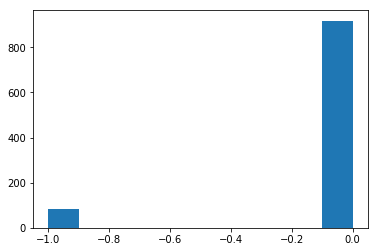

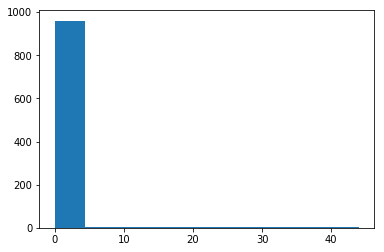

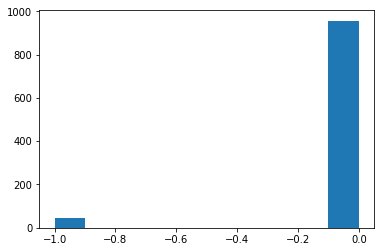

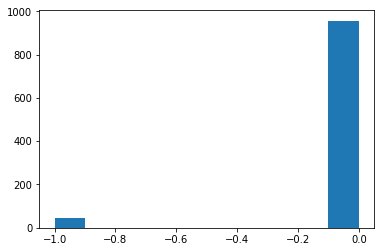

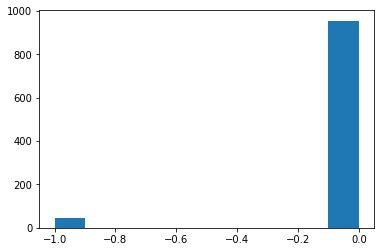

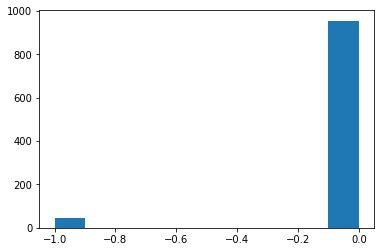

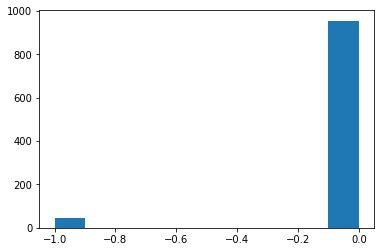

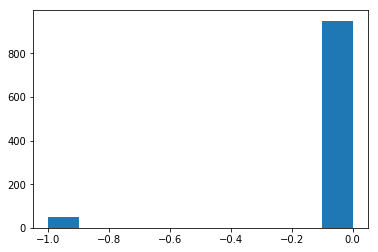

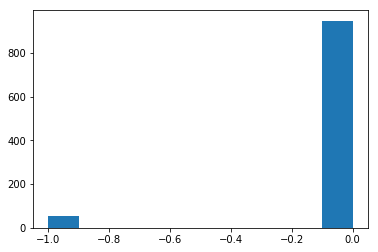

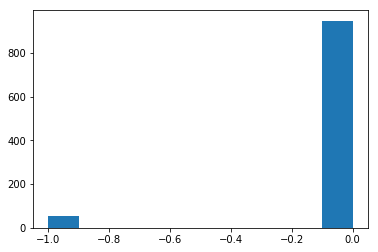

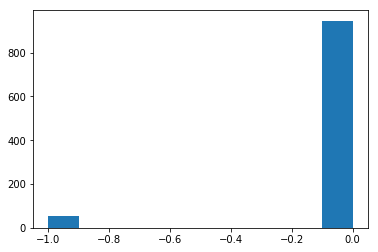

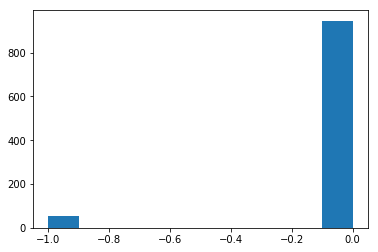

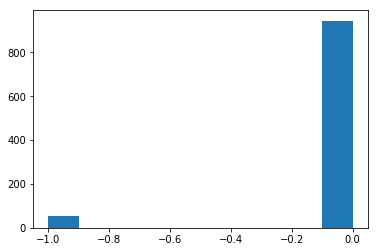

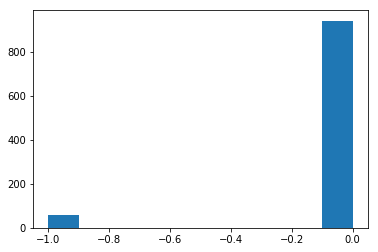

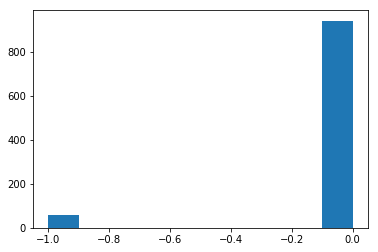

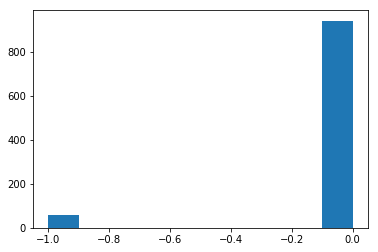

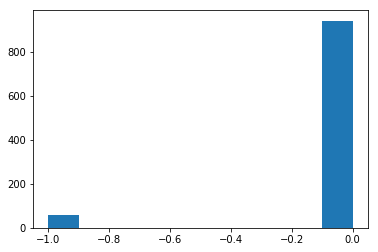

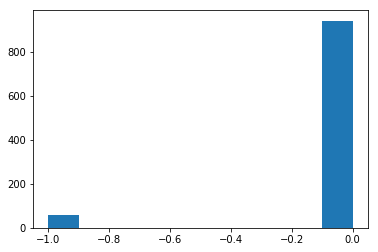

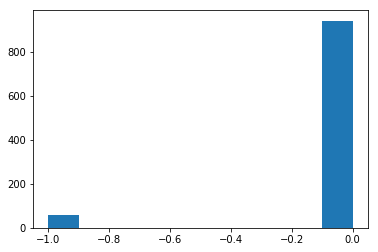

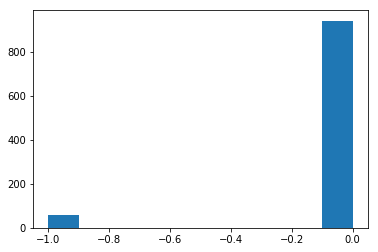

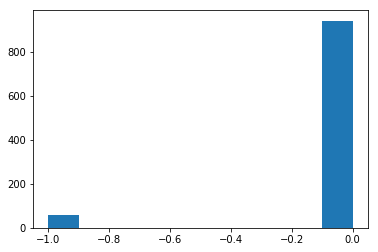

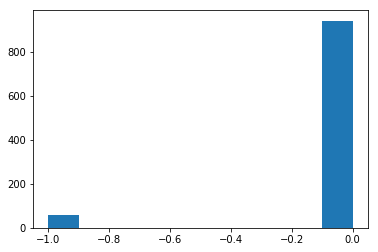

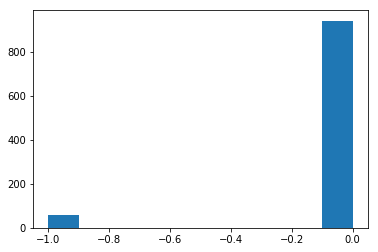

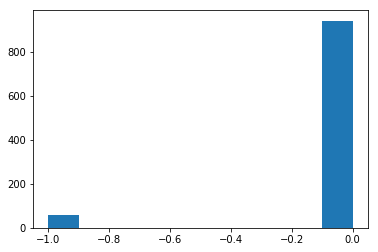

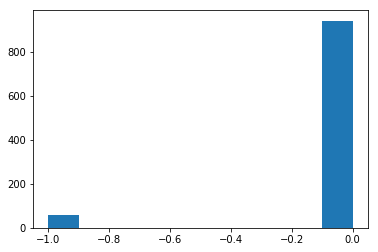

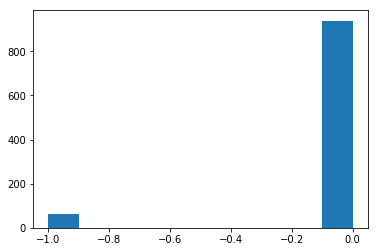

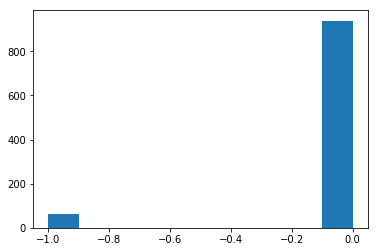

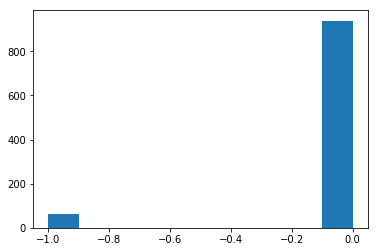

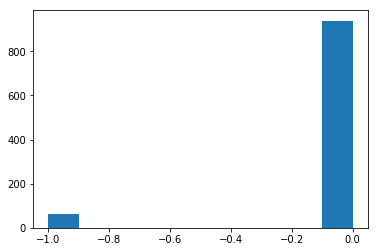

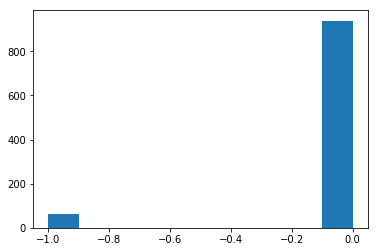

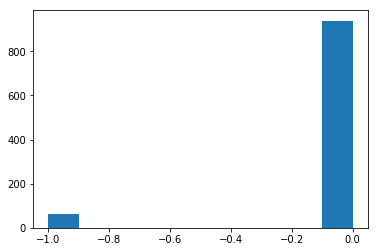

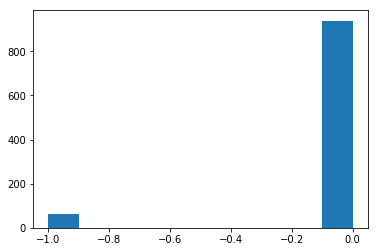

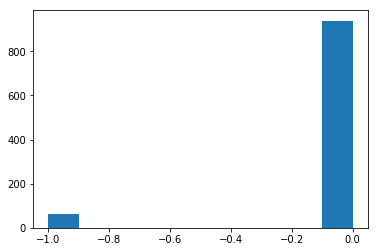

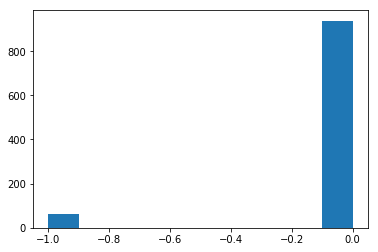

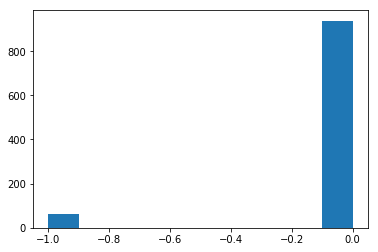

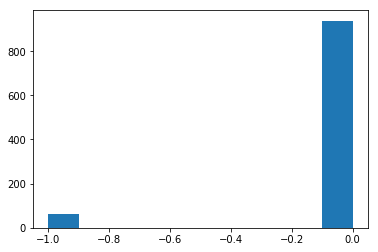

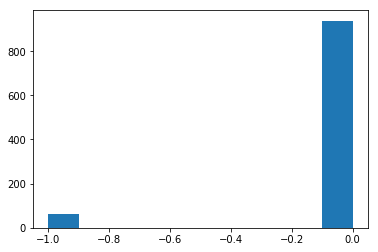

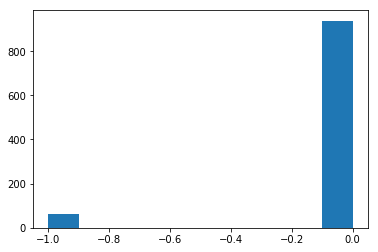

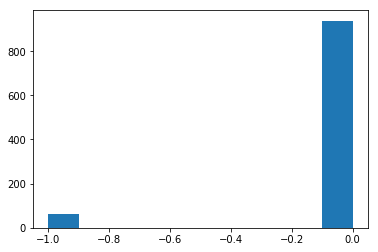

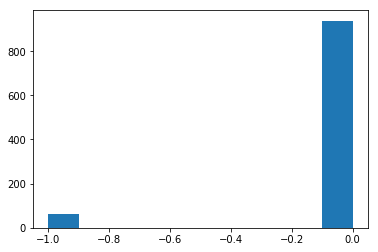

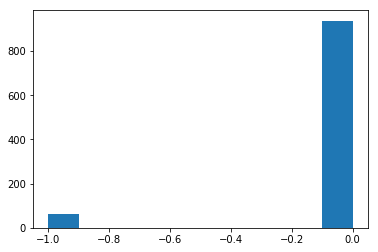

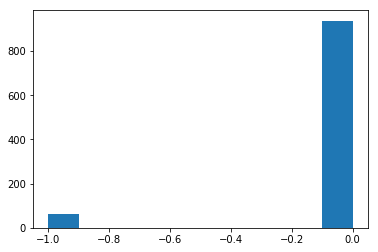

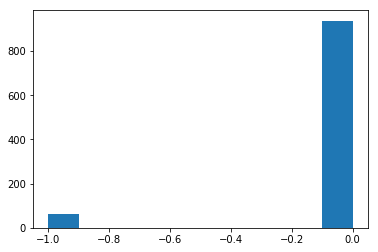

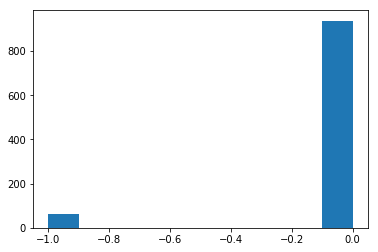

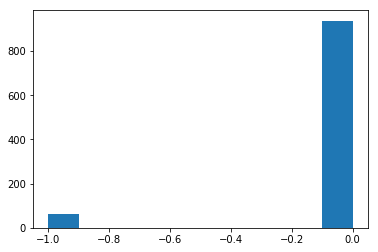

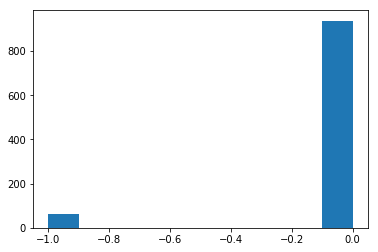

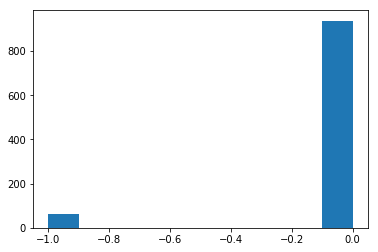

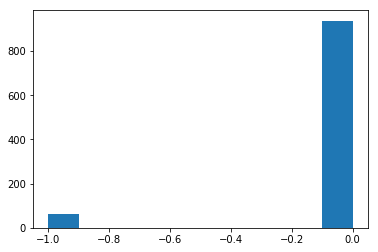

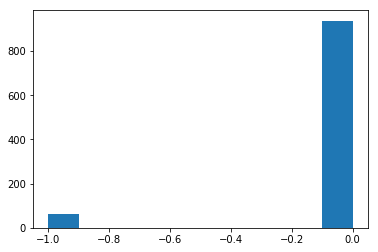

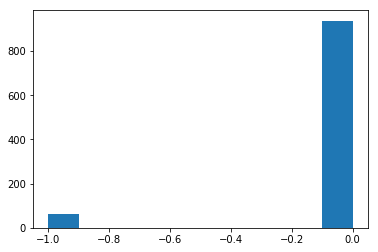

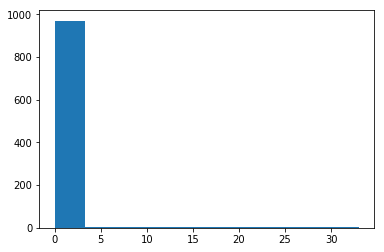

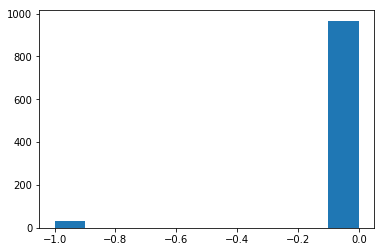

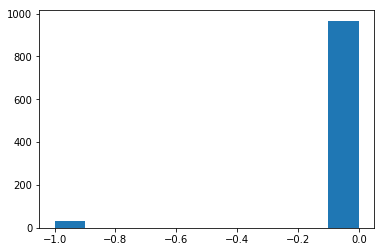

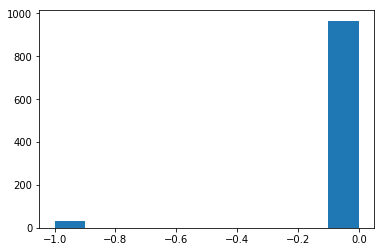

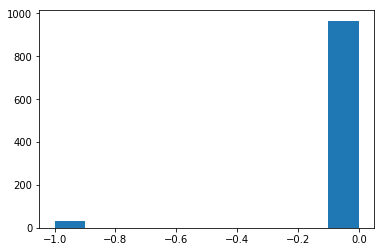

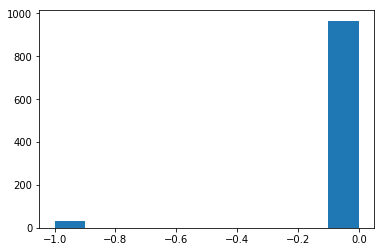

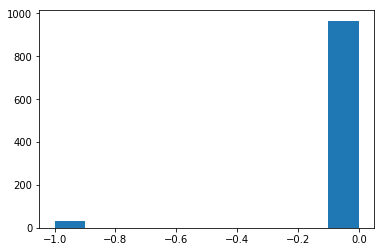

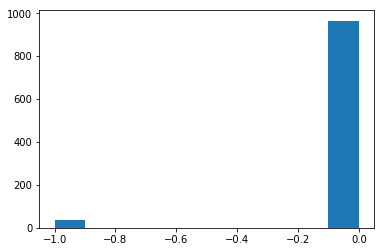

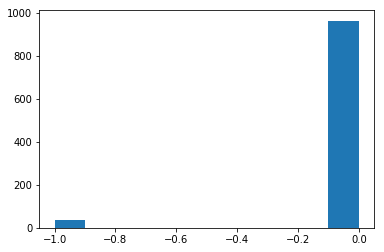

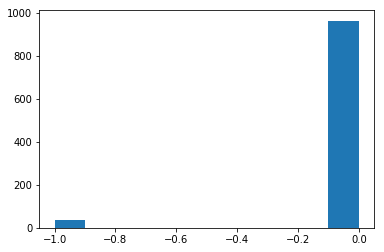

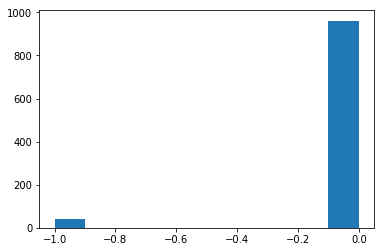

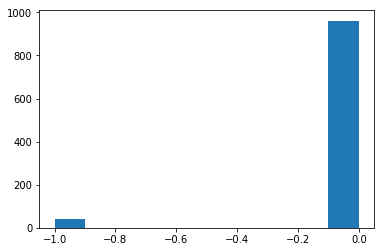

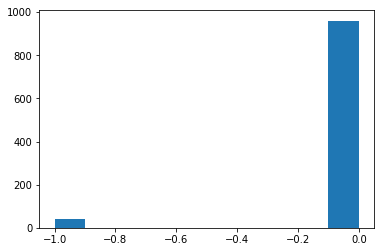

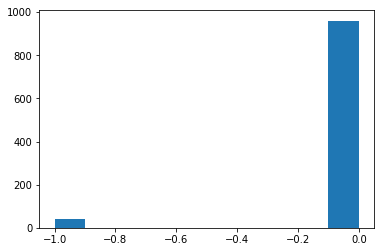

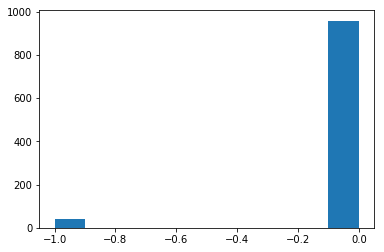

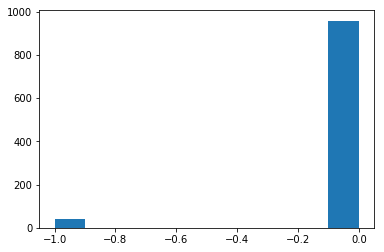

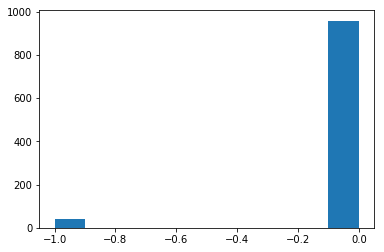

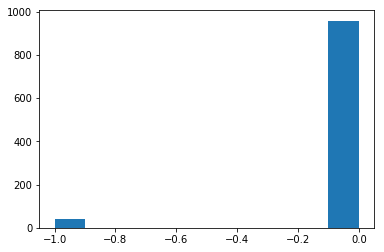

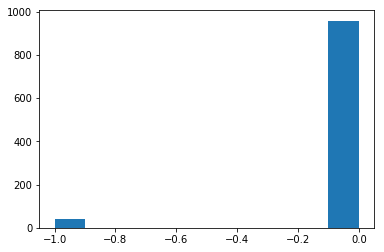

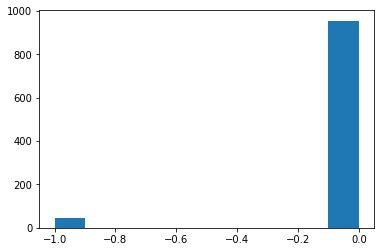

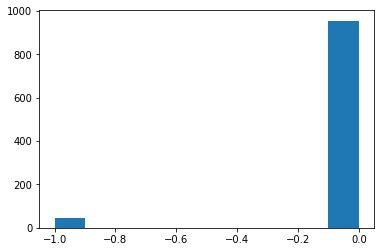

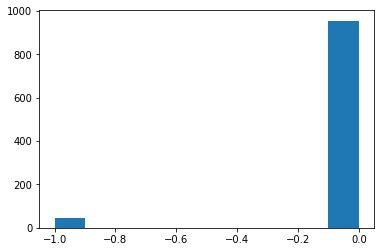

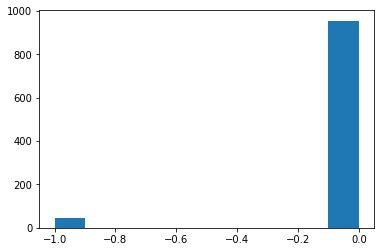

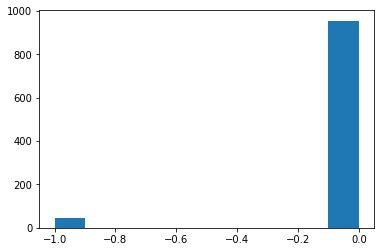

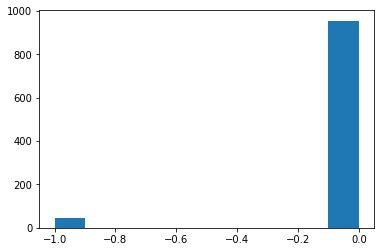

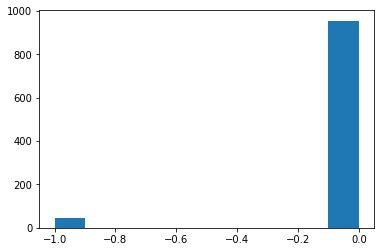

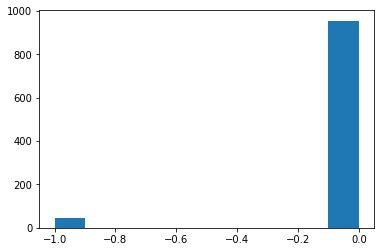

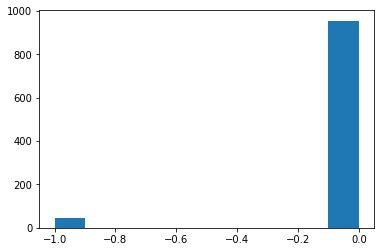

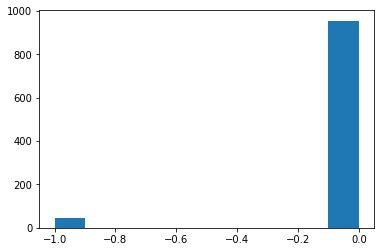

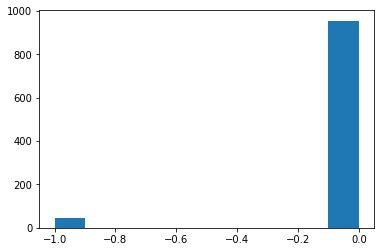

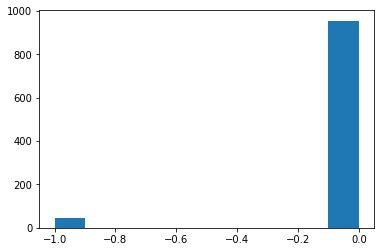

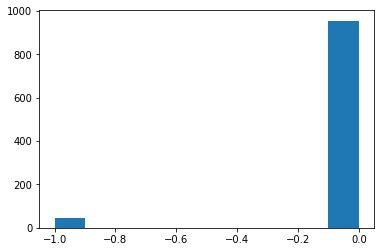

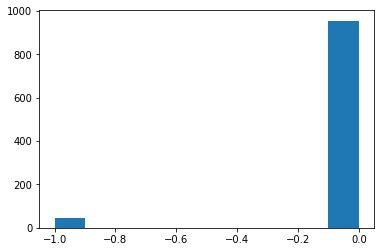

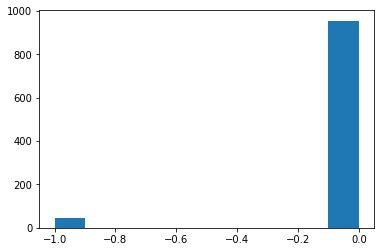

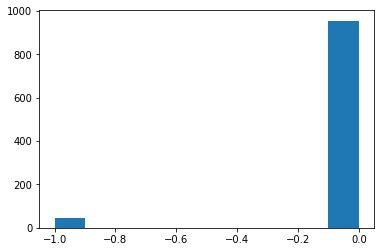

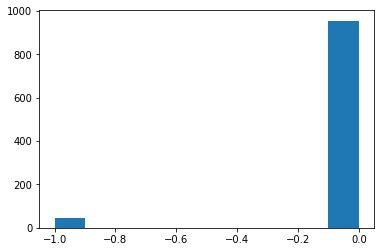

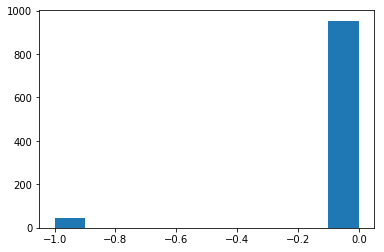

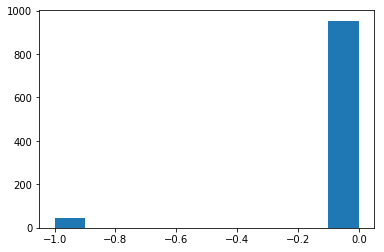

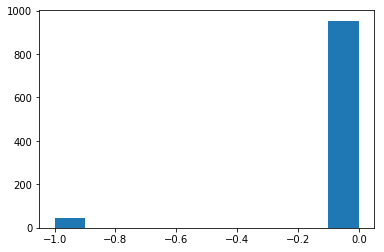

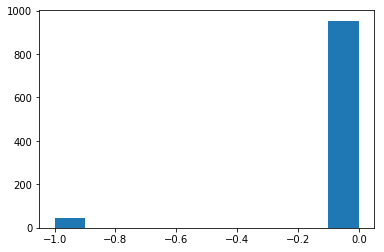

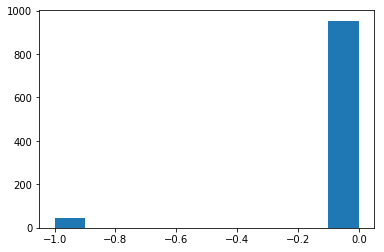

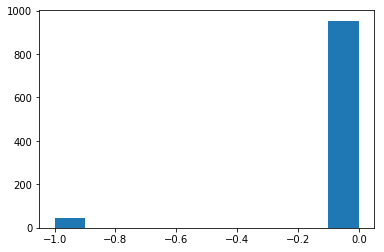

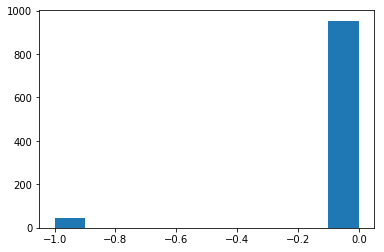

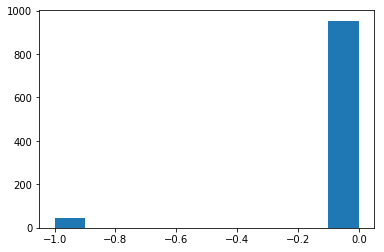

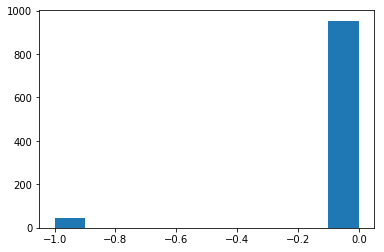

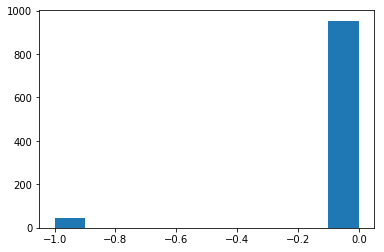

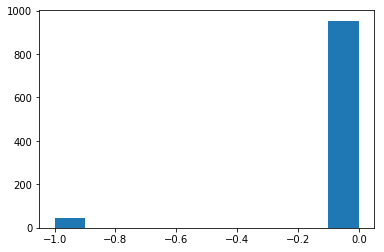

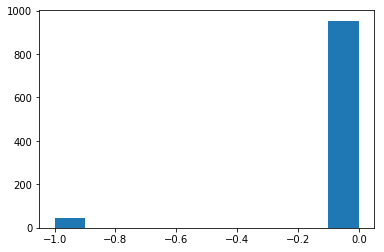

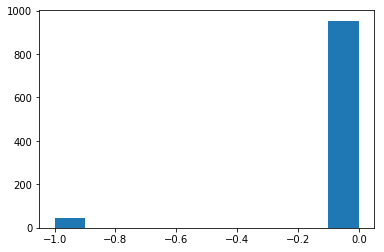

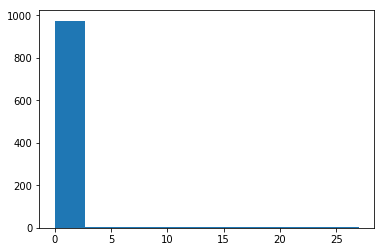

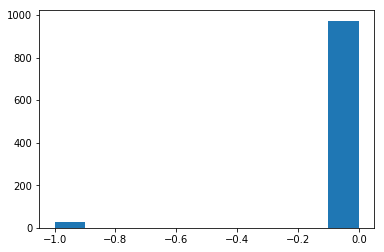

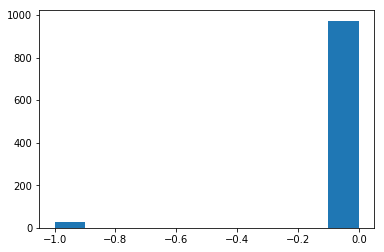

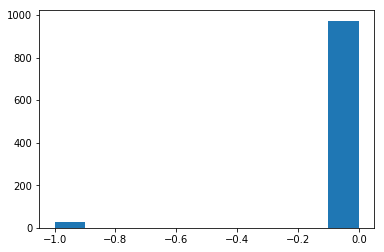

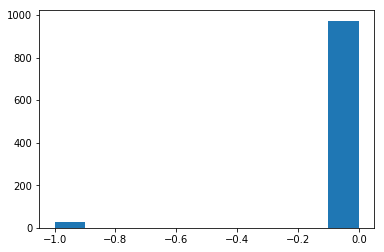

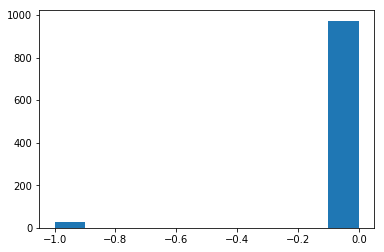

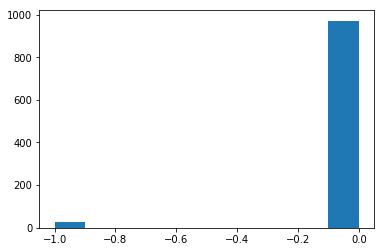

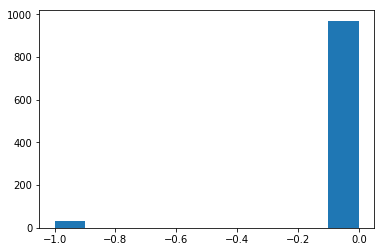

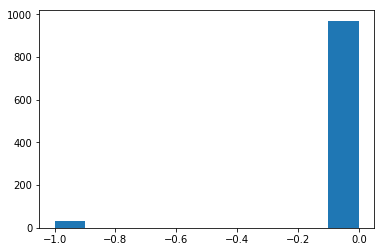

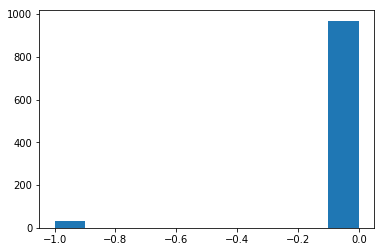

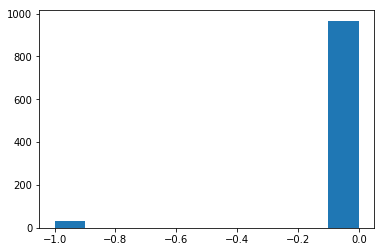

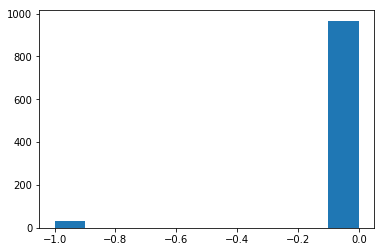

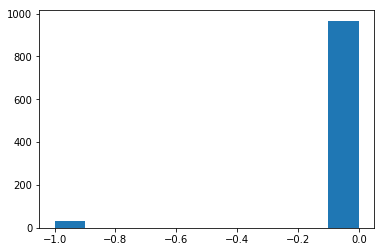

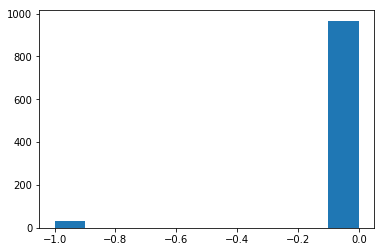

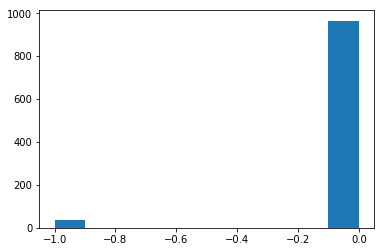

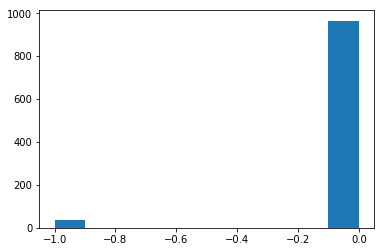

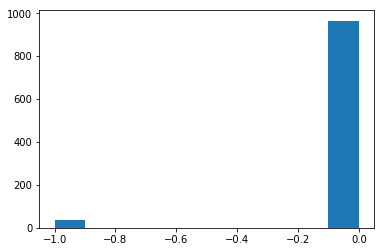

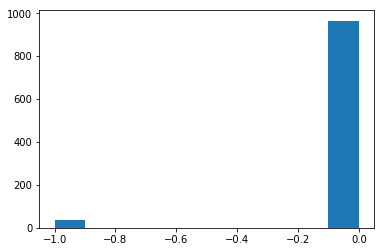

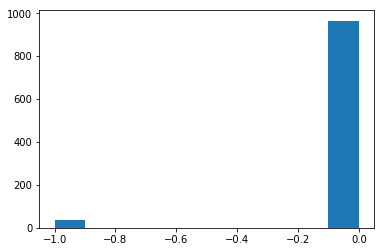

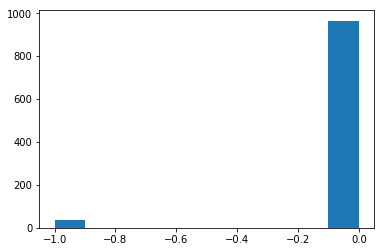

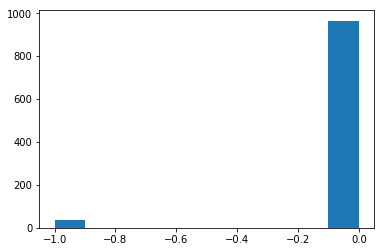

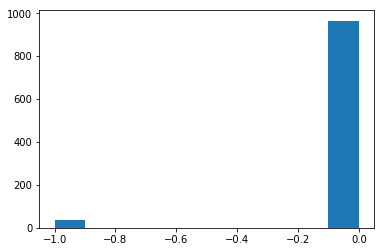

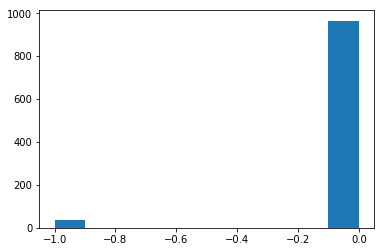

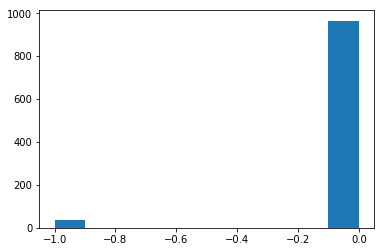

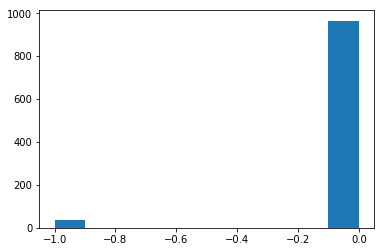

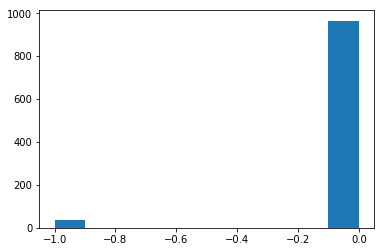

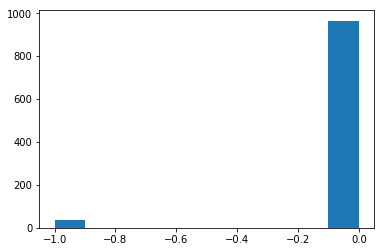

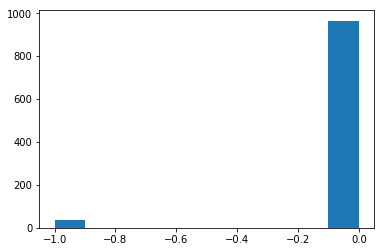

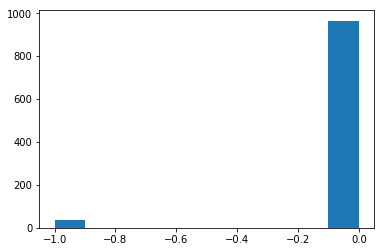

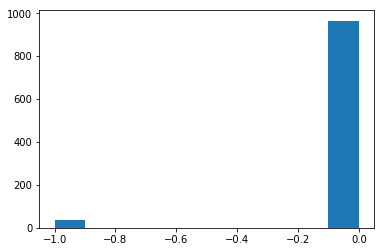

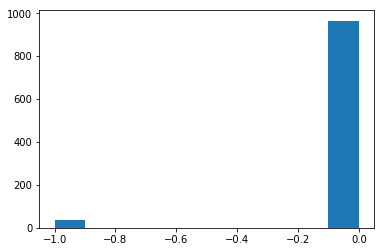

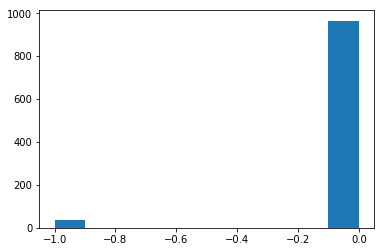

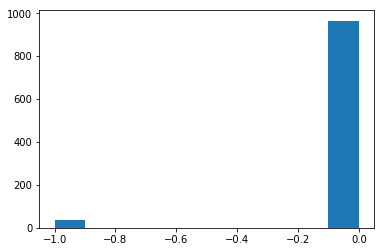

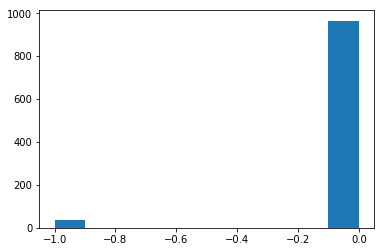

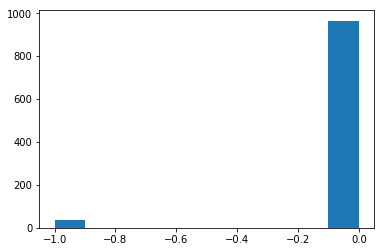

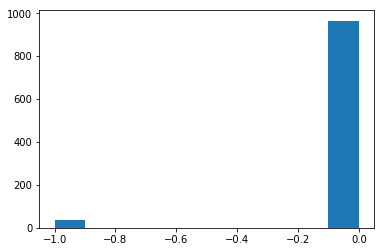

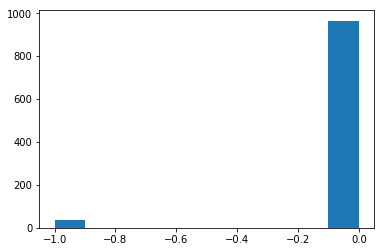

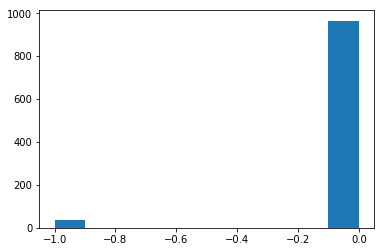

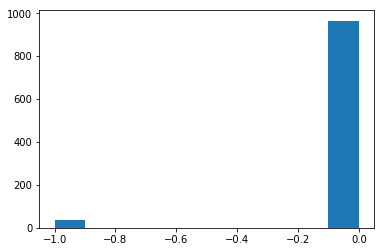

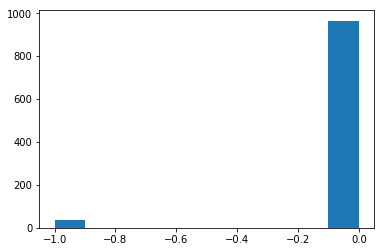

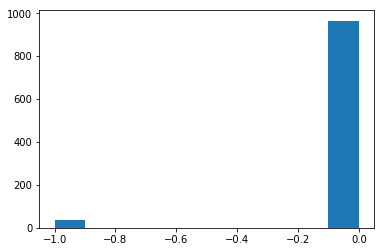

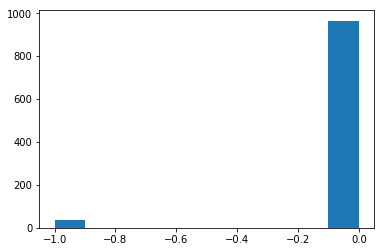

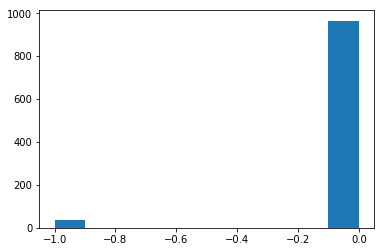

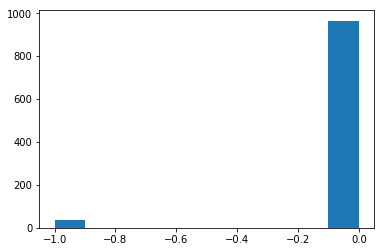

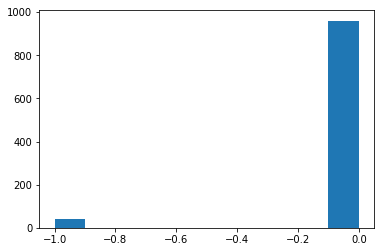

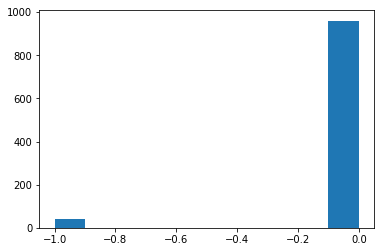

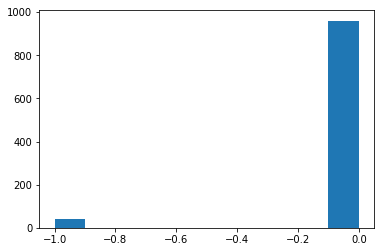

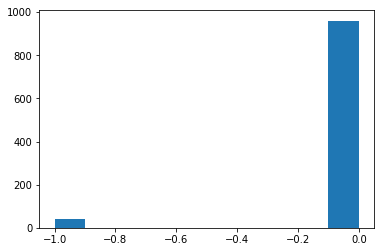

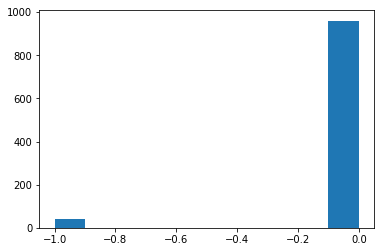

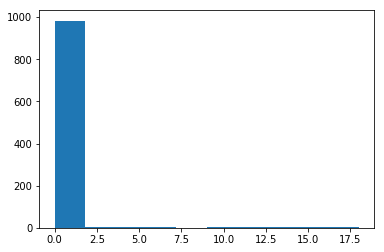

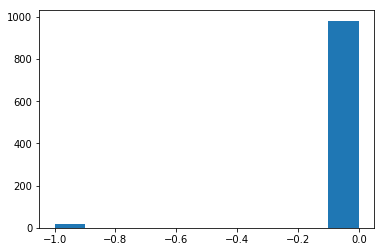

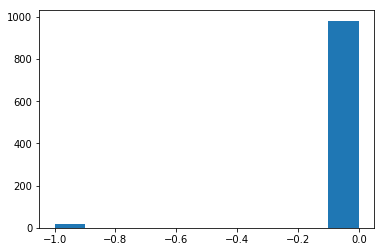

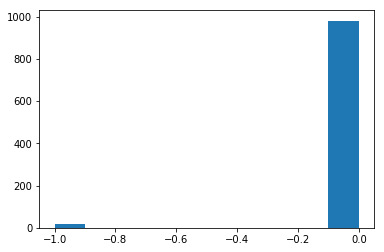

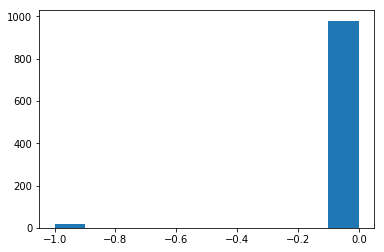

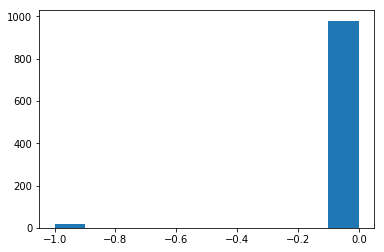

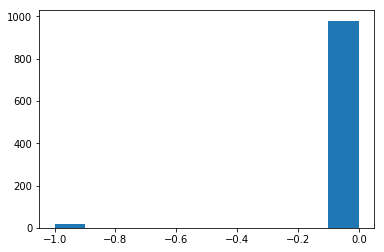

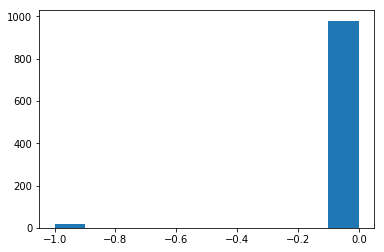

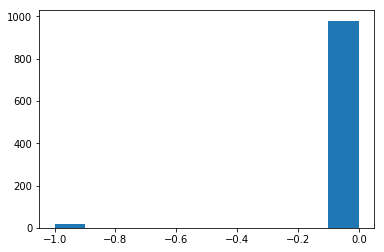

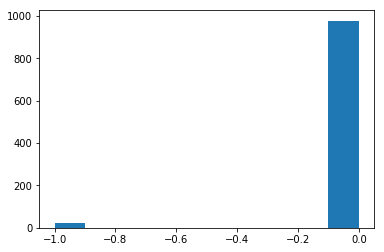

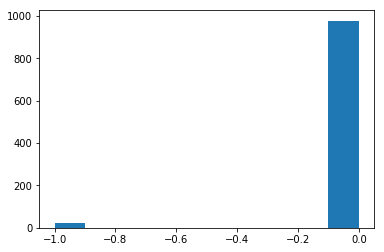

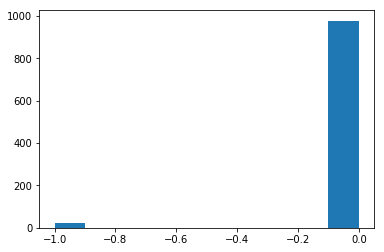

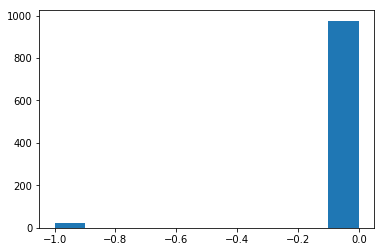

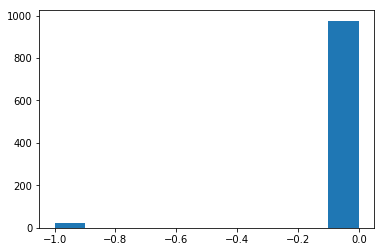

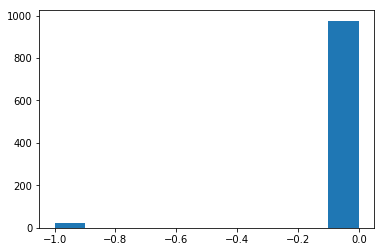

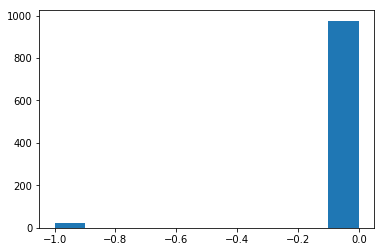

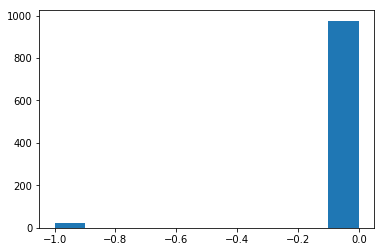

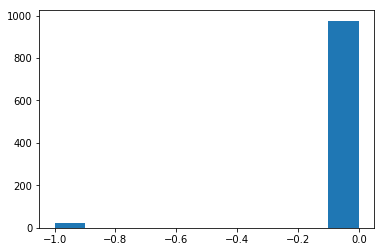

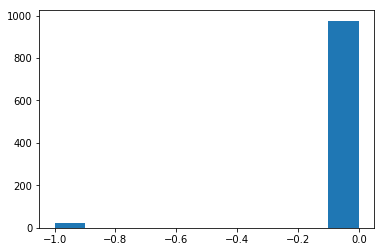

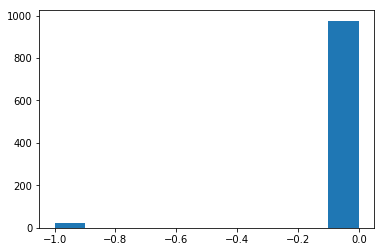

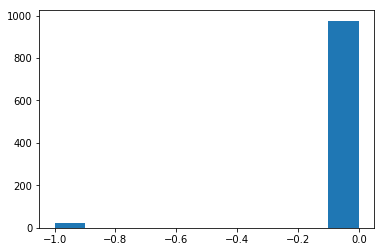

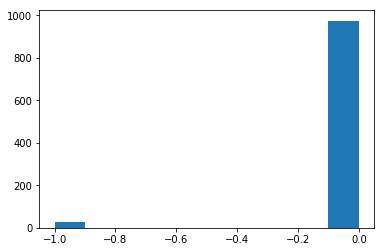

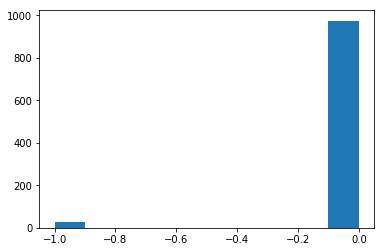

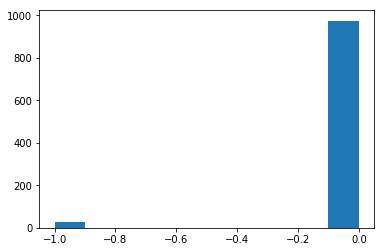

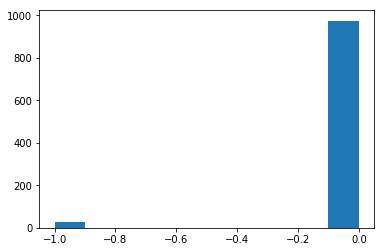

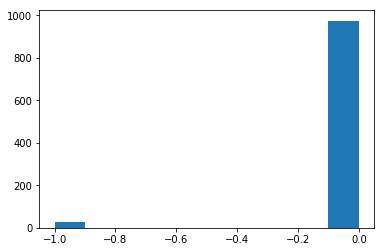

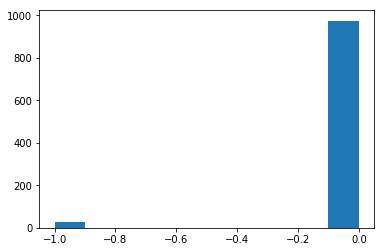

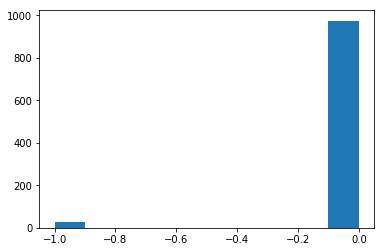

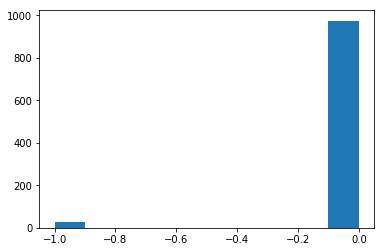

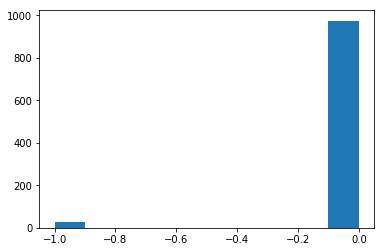

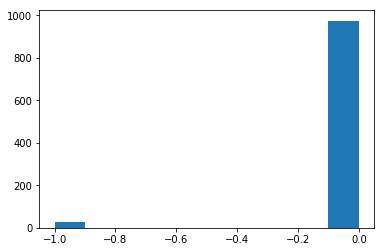

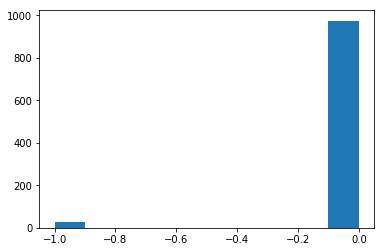

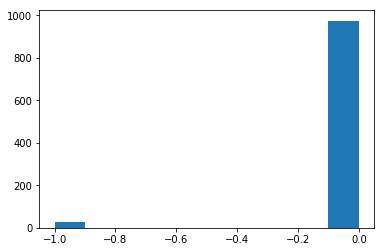

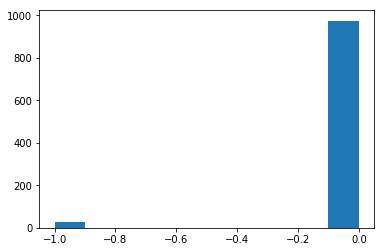

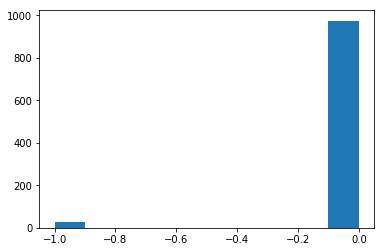

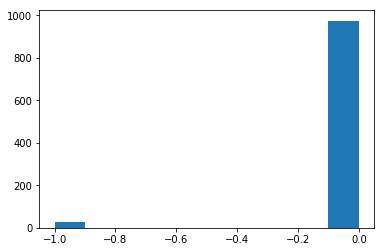

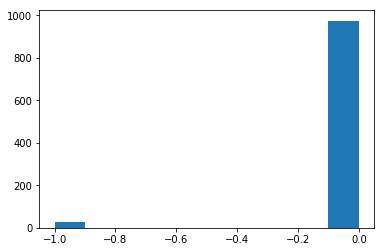

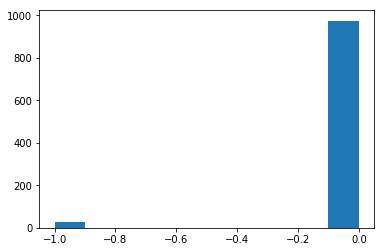

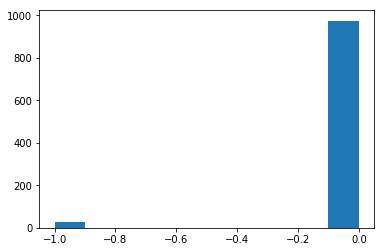

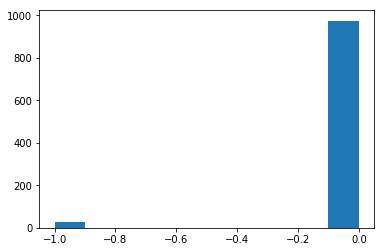

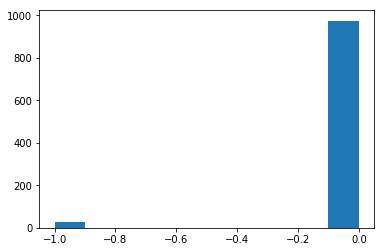

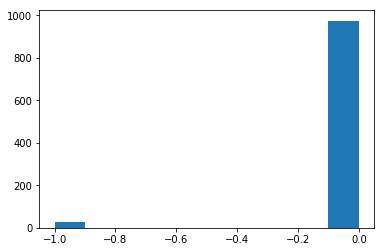

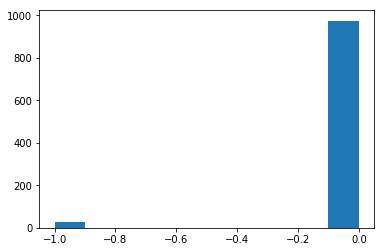

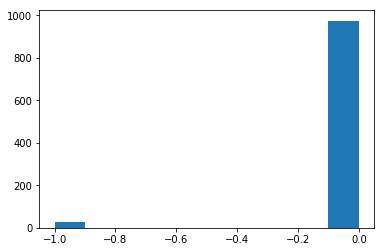

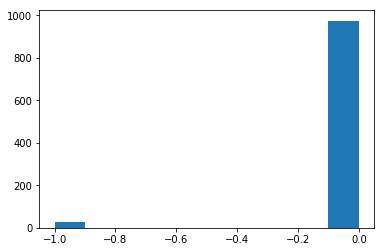

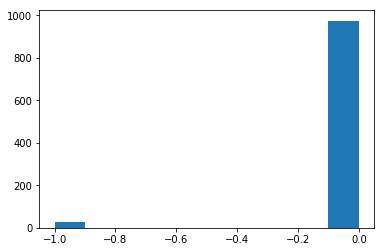

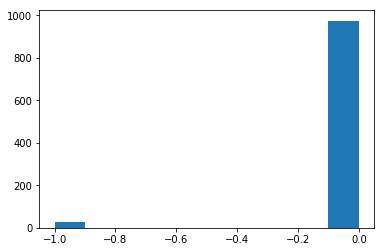

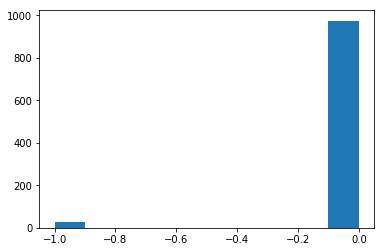

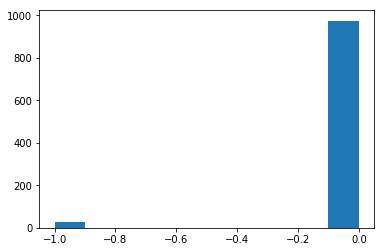

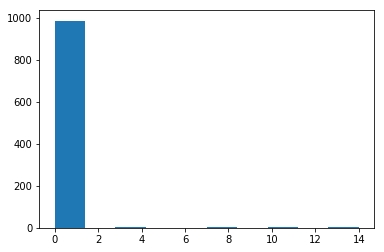

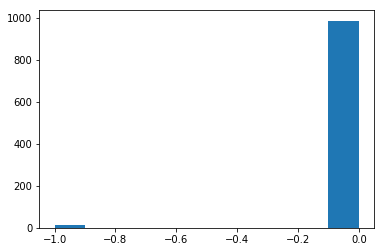

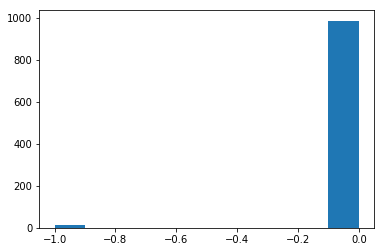

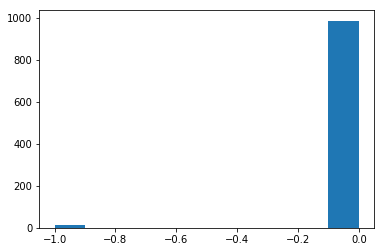

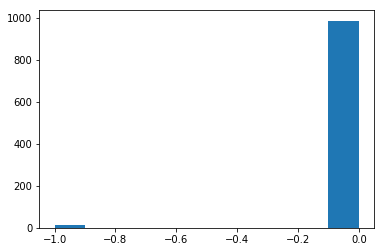

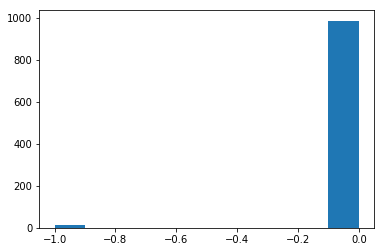

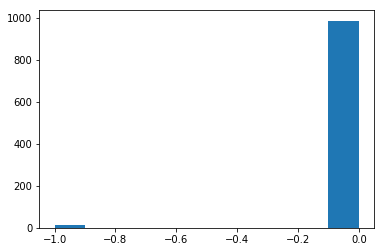

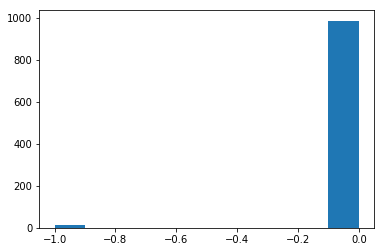

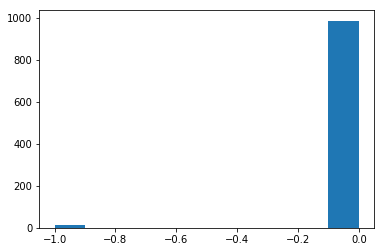

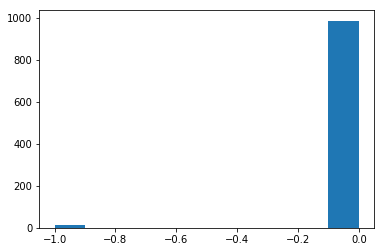

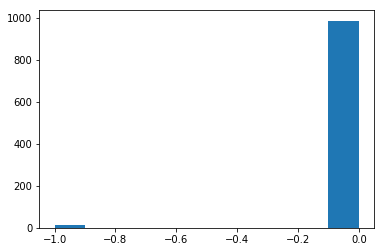

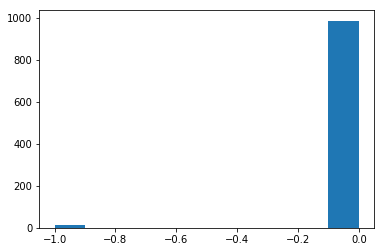

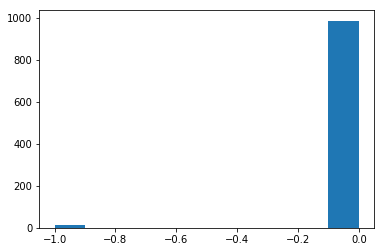

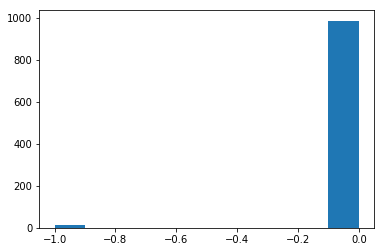

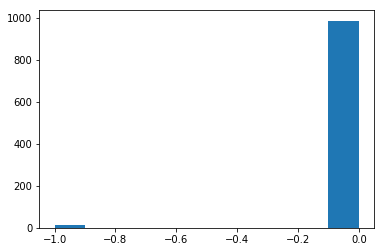

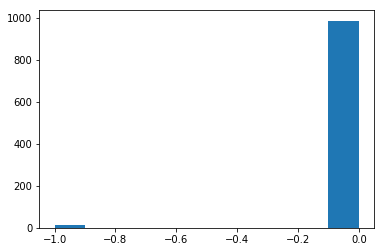

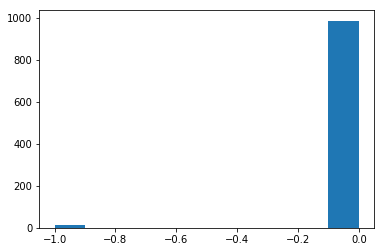

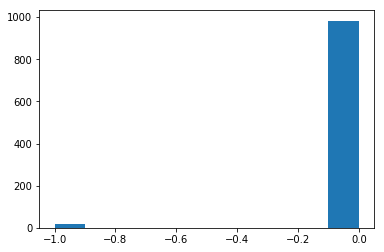

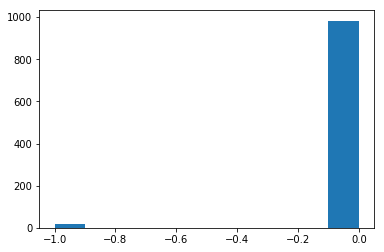

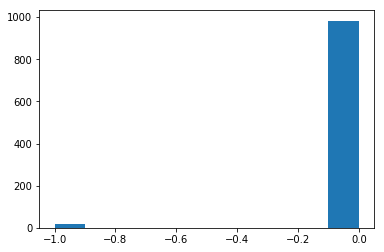

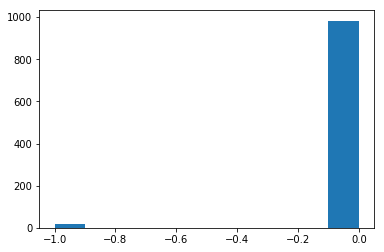

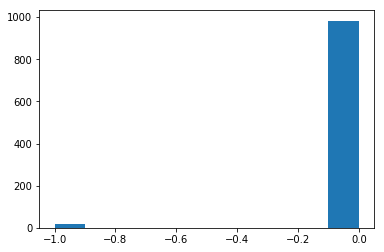

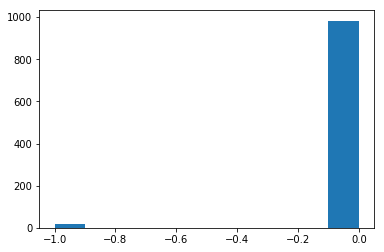

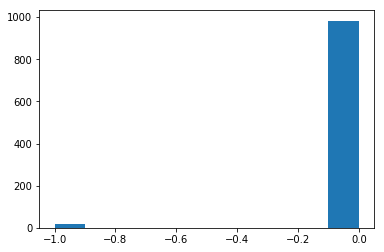

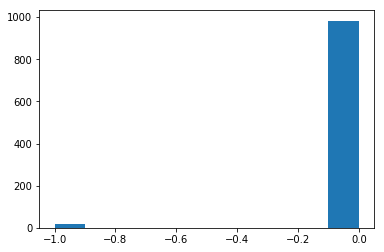

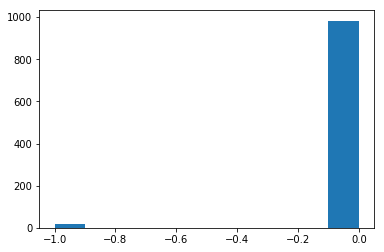

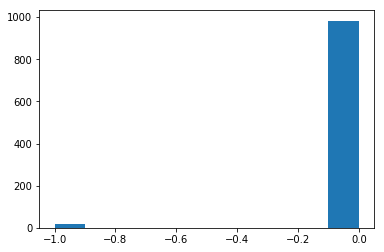

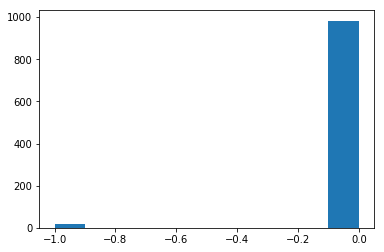

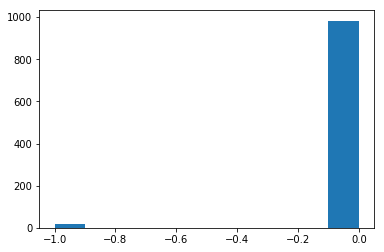

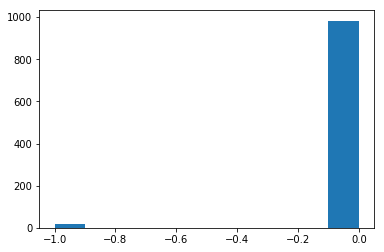

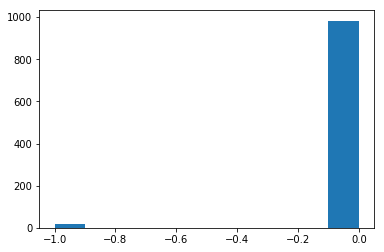

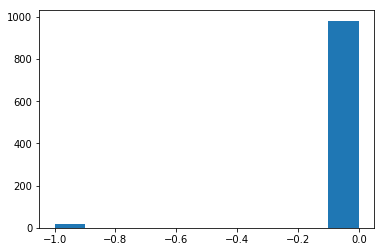

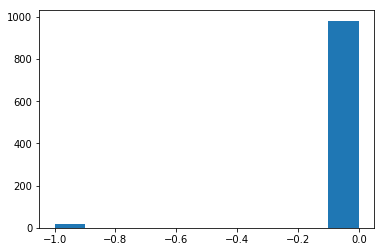

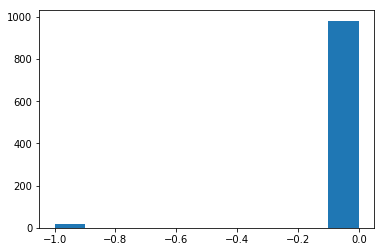

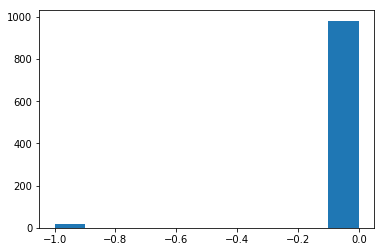

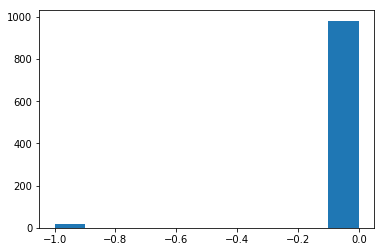

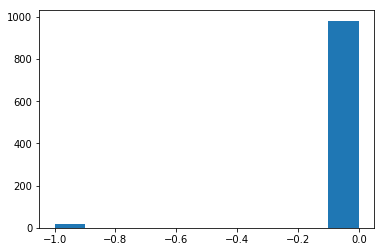

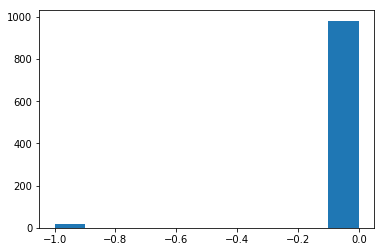

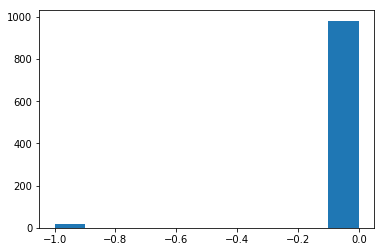

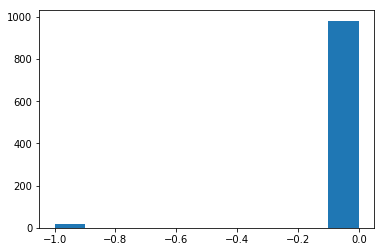

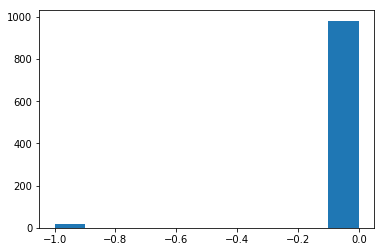

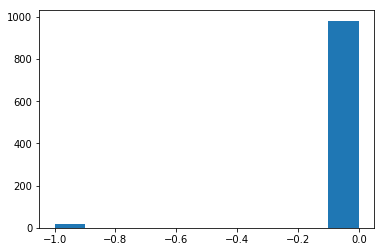

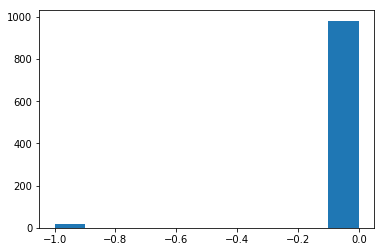

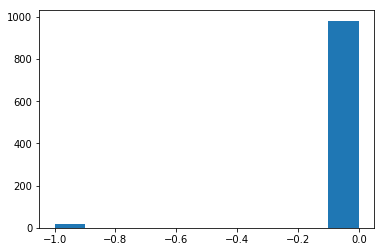

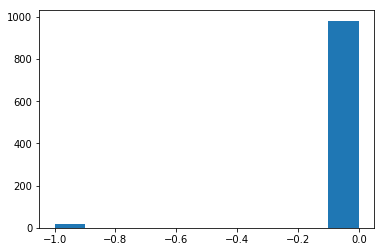

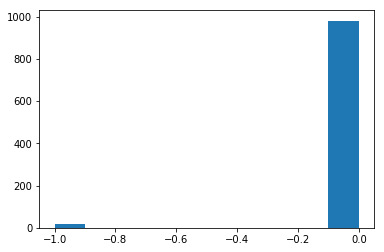

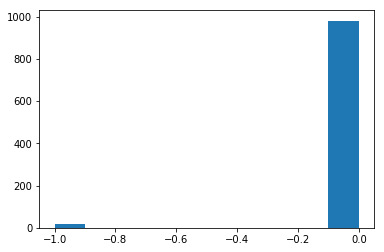

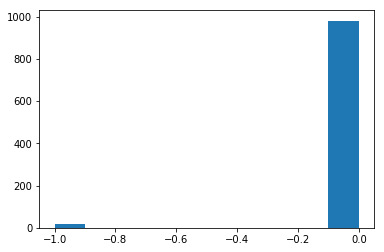

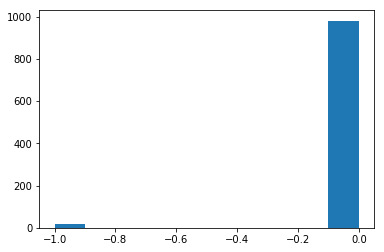

In [39]:
# Кластеризуем последовательности алгоритмом DBSCAN с различными параметрами

for eps in range(1, 20):
    for ms in range(1, 50):        
        clustering = DBSCAN(eps=eps, min_samples=ms, metric='precomputed').fit(pairwise)
        plt.hist(clustering.labels_)
        plt.show()